In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import time
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
class NeuralNetwork:
    def __init__(self, layers, activation, last_layer_activation = None, optimisation=None, beta=0.9, rms_decay=0.9, weights_initialize=None):
        """
        :param layers: A list specifying the number of neurons in each layer.
        :param activation: The activation function to use in the hidden layers.
        :param last_layer_activation : Activation function to use for the last layer.
        :param weights_initialize: Type of weight initialization (e.g., He, Xavier). If None -> random from uniform distribution U([0,1])
        :param optimisation: Type of the optimizer to be used (momentum/RMS/None). 
        :param beta: Beta parameter for momentum optimiser
        :param rms_decay: decay parameter for RMSProp
        """

        self.layers = layers
        self.weights = []
        self.bias = []
        self.beta = beta
        self.rms_decay = rms_decay
        self.velocity_weights = []
        self.velocity_biases = []
        self.rms_weights = []
        self.rms_biases = []
        print('INIT INFO : ------------------------------------------------------------------------------------')
        # Validate optimization method
        if optimisation is None:
            print('No optimisation method')
            self.optimisation = None
        elif optimisation == 'momentum':
            print('Selected optimisation method: Momentum')
            self.optimisation = optimisation
        elif optimisation == 'rms':
            print('Selected optimisation method: RMSProp')
            self.optimisation = optimisation
        else:
            raise NameError("Chosen optimiser is not available, try 'momentum' or 'rms'")
   
        # Weight initialization
        for i in range(len(layers)-1):
            if weights_initialize == "Xavier":
                std = np.sqrt(2 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            elif weights_initialize == "He":
                std = np.sqrt(2 / layers[i])
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * std)
            else:
                self.weights.append(np.random.uniform(-0.5, 0.5, size=(layers[i], layers[i+1])))

            self.velocity_weights.append(np.zeros_like(self.weights[i]))
            self.velocity_biases.append(np.zeros_like(np.random.uniform(-0.5, 0.5, size=(layers[i+1],))))

        self.bias = [np.random.uniform(-0.5, 0.5, size=(layers[i+1],)) for i in range(len(layers)-1)]
        
        self.velocity_weights = [np.zeros_like(w) for w in self.weights]
        self.velocity_biases = [np.zeros_like(b) for b in self.bias]

        self.rms_weights = [np.zeros_like(w) for w in self.weights]
        self.rms_biases = [np.zeros_like(b) for b in self.bias]

        # Activation functions
        activation_functions = {
            "sigmoid": self.sigmoid,
            "tanh": self.tanh,
            "relu": self.relu,
            "leaky_relu": self.leaky_relu,
            "softmax": self.softmax
        }

        activation_functions_derivatives = {
            "sigmoid": self.sigmoid_derivative,
            "tanh": self.tanh_derivative,
            "relu": self.relu_derivative,
            "leaky_relu": self.leaky_relu_derivative,
            
        }

        self.activation_function = activation_functions.get(activation)
        self.activation_function_derivative = activation_functions_derivatives.get(activation)

        if last_layer_activation is None:
            print('Identity function chosen for last layer')
            self.last_layer_activation = None
        else:
            print(f'{last_layer_activation} function chosen for last layer.')
            self.last_layer_activation = activation_functions.get(last_layer_activation)

    # Activation functions
    def sigmoid(self, x): 
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x): 
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x): 
        return np.tanh(x)
    def tanh_derivative(self, x): 
        return 1 - self.tanh(x)**2

    def relu(self, x):
        return np.maximum(0, x)
    def relu_derivative(self, x):
        return (x > 0).astype(int)
    
    def leaky_relu(self, x, alpha=0.01):
        return np.maximum(alpha * x, x)
    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)
    
    def softmax(self, x):
        # Stable softmax to prevent overflow
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    
    def forward(self, X):
        self.a = [X]
        self.z = [X]
        for i in range(len(self.weights)-1):
            z = np.dot(self.a[-1], self.weights[i]) + self.bias[i]
            self.z.append(z)
            a = self.activation_function(z)
            self.a.append(a)

        z = np.dot(self.a[-1], self.weights[-1]) + self.bias[-1]
        self.z.append(z)
        # last layer activation
        if self.last_layer_activation is None:
            self.a.append(z)
        else:
            self.a.append(self.last_layer_activation(z))

        return self.a[-1]

    def backpropagate(self, X, y, learning_rate):
        m = X.shape[0]
        # For multiclass, we use cross-entropy loss with softmax
        delta = [self.a[-1] - y]
        # Backpropagate errors
        for i in range(len(self.weights)-1, 0, -1):
            error = np.dot(delta[-1], self.weights[i].T) * self.activation_function_derivative(self.z[i])
            delta.append(error)
        delta = delta[::-1]

        epsilon = 1e-9
        # Update weights according to chosen optimizer
        for i in range(len(self.weights)):
            grad_weights = np.dot(self.a[i].T, delta[i]) / m
            grad_bias = np.sum(delta[i], axis=0) / m

            if self.optimisation is None:
                self.weights[i] -= learning_rate * grad_weights
                self.bias[i] -= learning_rate * grad_bias

            elif self.optimisation == 'momentum':
                self.velocity_weights[i] = self.beta * self.velocity_weights[i] + learning_rate * grad_weights
                self.velocity_biases[i] = self.beta * self.velocity_biases[i] + learning_rate * grad_bias
                self.weights[i] -= self.velocity_weights[i]
                self.bias[i] -= self.velocity_biases[i]

            elif self.optimisation == 'rms':
                self.rms_weights[i] = self.rms_decay * self.rms_weights[i] + (1 - self.rms_decay) * grad_weights**2
                self.rms_biases[i] = self.rms_decay * self.rms_biases[i] + (1 - self.rms_decay) * grad_bias**2
                self.weights[i] -= learning_rate * grad_weights / (np.sqrt(self.rms_weights[i]) + epsilon)
                self.bias[i] -= learning_rate * grad_bias / (np.sqrt(self.rms_biases[i]) + epsilon)

    def train(self, X_train, y_train, X_test, y_test, learning_rate, epochs, loss_func, loss_threshold, batch_size=32,report_frequency = 100,  y_scaler = None, plot=True):
        train_scores = []
        test_scores = []
        num_samples = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                self.forward(X_batch)
                self.backpropagate(X_batch, y_batch, learning_rate)

            if loss_func == 'mse':
                train_loss = self.MSE(X_train, y_train)
                train_scores.append(train_loss)

            elif loss_func =='F1':
                train_loss = self.cross_entropy_loss(X_train, y_train) #cross entropy for training
                train_scores.append(train_loss)
            else:
                raise ValueError("No such metric implemented")

            # Evaluate every k epochs
            if epoch % report_frequency == 0:
                if loss_func == 'F1':
                    y_pred_proba = self.predict(X_test)
                    y_pred = np.argmax(y_pred_proba, axis=1) #converting to class label
                    y_true = np.argmax(y_test, axis=1)
                    f1 = f1_score(y_true, y_pred, average='weighted') #weightes f1 score
                    test_scores.append(f1) 

                    print(f"Epoch {epoch}, Training F1: {train_loss:.8f}, Test F1: {f1:.4f}")
                    if f1 >=loss_threshold:
                        print(f'F1 SCORE ACHIEVED : {f1} stopping at epoch {epoch}')
                        break

                elif loss_func=='mse':
                    Y_pred_denorm=y_scaler.inverse_transform(self.predict(X_test))
                    mse = np.mean((Y_pred_denorm - y_test) ** 2)
                    test_scores.append(mse)
                    print(f"Epoch {epoch}, Training MSE: {train_loss:.8f}, Test MSE: {mse:.4f}")
                    if mse < loss_threshold:
                        print(f'MSE ACHIEVED : {mse} stopping at epoch {epoch}')
                        break

                
        end_time = time.time()
        print('Training Duration:', end_time - start_time)

        # Plotting
        if plot:
            if len(train_scores) >3:
                plt.figure(figsize=(12, 5))
                
                plt.subplot(1, 2, 1)
                plt.plot(train_scores)
                plt.title('Training Scores')
                plt.xlabel('Epochs')
                if loss_func=='mse':
                    plt.ylabel('MSE')
                elif loss_func=="F1":
                    plt.ylabel('Cross Entropy Loss')
                
                plt.subplot(1, 2, 2)
                plt.plot(test_scores)
                plt.title('Test Scores')
                plt.xlabel(f'Epochs per ({report_frequency})')
                if loss_func=='mse':
                    plt.ylabel('MSE')
                elif loss_func=="F1":
                    plt.ylabel('Weighted F1')
                plt.tight_layout()
                plt.show()
        return train_scores,test_scores, test_scores[-1], end_time-start_time, epoch


    def predict(self, X):
        return self.forward(X)
    
    def cross_entropy_loss(self, X, Y):
        # Compute cross-entropy loss for multiclass classification
        y_pred = self.predict(X)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(Y * np.log(y_pred), axis=1))
    def MSE(self, X, Y):
        return np.mean((self.predict(X) - Y) ** 2)





# Rings df

In [3]:
train_df = pd.read_csv('data/rings3-regular-training.csv')
test_df = pd.read_csv('data/rings3-regular-test.csv')

print(f"Number of classes: {train_df['c'].nunique()}")

Number of classes: 3


In [4]:
X_train = train_df[['x', 'y']].to_numpy()
Y_train = train_df['c'].to_numpy().reshape(-1,1)  
X_test = test_df[['x', 'y']].to_numpy()
Y_test = test_df['c'].to_numpy().reshape(-1,1)  

# # Normalizacja X
# x_scaler = MinMaxScaler()
# X_train_normalized = x_scaler.fit_transform(X_train)
# X_test_normalized = x_scaler.transform(X_test)

# # Kodowanie one-hot dla Y
y_encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = y_encoder.fit_transform(Y_train)  
Y_test_encoded = y_encoder.transform(Y_test) 

print(Y_test_encoded.shape)

(2000, 3)


Text(0.5, 1.0, 'Rings 3 data')

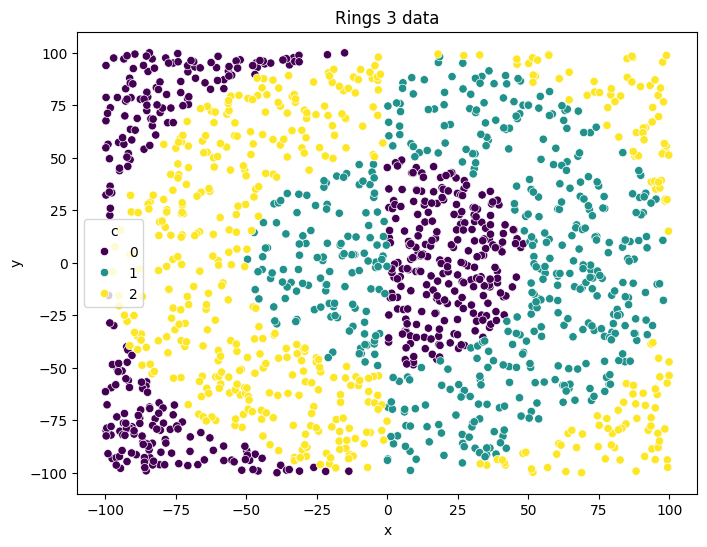

In [5]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='x', y='y', hue='c', palette='viridis')
plt.title('Rings 3 data')

# 4 8 4 Rings

## Softmax activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.10431811, Test F1: 0.2590
Epoch 10, Training F1: 1.07378213, Test F1: 0.2671
Epoch 20, Training F1: 0.99676332, Test F1: 0.3988
Epoch 30, Training F1: 0.95207403, Test F1: 0.4130
Epoch 40, Training F1: 0.93604475, Test F1: 0.4324
Epoch 50, Training F1: 0.91757106, Test F1: 0.4445
Epoch 60, Training F1: 0.91416089, Test F1: 0.4576
Epoch 70, Training F1: 0.89095019, Test F1: 0.5530
Epoch 80, Training F1: 0.87950068, Test F1: 0.5627
Epoch 90, Training F1: 0.86797226, Test F1: 0.5617
Epoch 100, Training F1: 0.85519021, Test F1: 0.5744
Epoch 110, Training F1: 0.84260077, Test F1: 0.5847
Epoch 120, Training F1: 0.82834302, Test F1: 0.5950
Epoch 130, Training F1: 0.84905351, Test F1: 0.5489
Epoch 140, Training F1: 0.82778701, Test F1: 0.5848
Epoch 150, Training F1: 0.74457097, Test F1: 0.6277
Epoch 160, Training

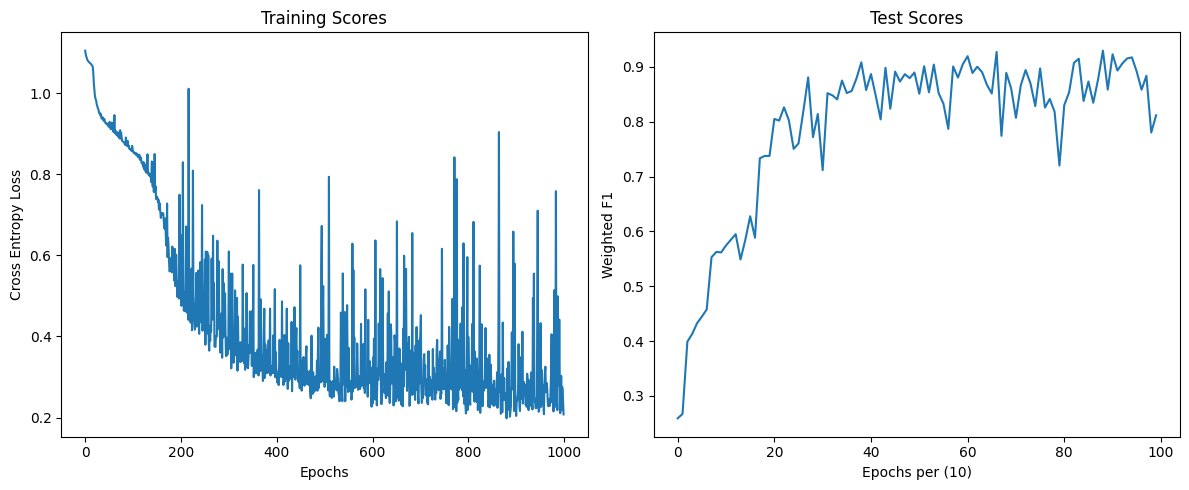

In [6]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='softmax')
soft1_train, soft1_test,soft1_final, soft1_time, soft1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.02136166, Test F1: 0.4680
Epoch 10, Training F1: 0.90825895, Test F1: 0.5270
Epoch 20, Training F1: 0.88168043, Test F1: 0.5891
Epoch 30, Training F1: 0.83404311, Test F1: 0.5318
Epoch 40, Training F1: 0.77206115, Test F1: 0.5928
Epoch 50, Training F1: 0.69037563, Test F1: 0.7056
Epoch 60, Training F1: 0.61493824, Test F1: 0.7460
Epoch 70, Training F1: 0.57635124, Test F1: 0.7381
Epoch 80, Training F1: 0.52753374, Test F1: 0.8041
Epoch 90, Training F1: 0.48585652, Test F1: 0.8364
Epoch 100, Training F1: 0.48003996, Test F1: 0.8110
Epoch 110, Training F1: 0.45688703, Test F1: 0.8587
Epoch 120, Training F1: 0.41755886, Test F1: 0.8438
Epoch 130, Training F1: 0.41064806, Test F1: 0.8672
Epoch 140, Training F1: 0.44786393, Test F1: 0.8557
Epoch 150, Training F1: 0.36837753, Test F1: 0.8698
Epoch 160, Training

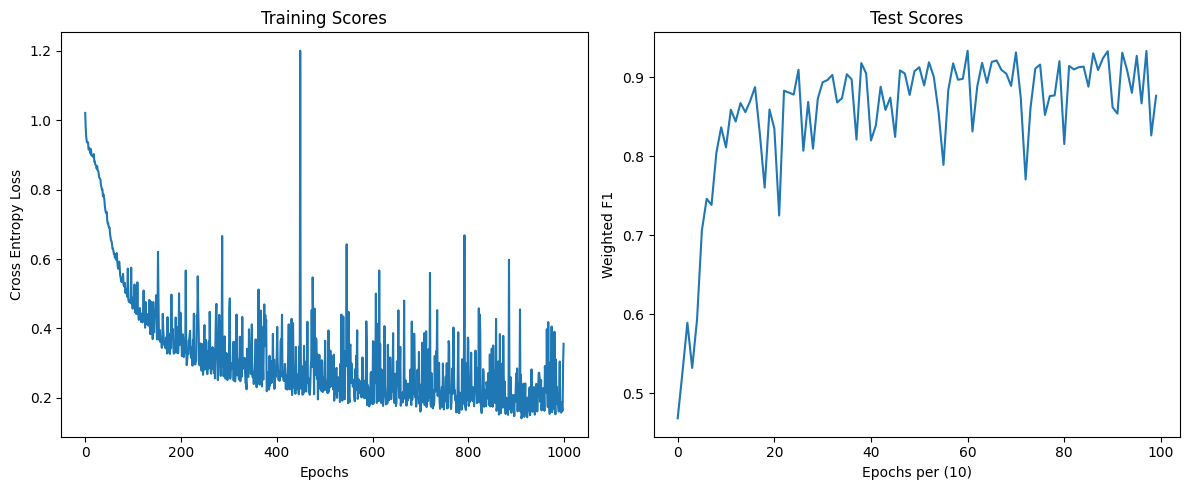

In [7]:
# wywolanie 2
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='softmax')
soft2_train, soft2_test,soft2_final, soft2_time, soft2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.09060891, Test F1: 0.2484
Epoch 10, Training F1: 0.97177330, Test F1: 0.3376
Epoch 20, Training F1: 0.95988848, Test F1: 0.3628
Epoch 30, Training F1: 0.92256878, Test F1: 0.4105
Epoch 40, Training F1: 0.84684836, Test F1: 0.5689
Epoch 50, Training F1: 0.72829647, Test F1: 0.7026
Epoch 60, Training F1: 0.62047678, Test F1: 0.7970
Epoch 70, Training F1: 0.55211177, Test F1: 0.8142
Epoch 80, Training F1: 0.55252154, Test F1: 0.7340
Epoch 90, Training F1: 0.47835219, Test F1: 0.8308
Epoch 100, Training F1: 0.49344307, Test F1: 0.8091
Epoch 110, Training F1: 0.44927062, Test F1: 0.7989
Epoch 120, Training F1: 0.64563487, Test F1: 0.6873
Epoch 130, Training F1: 0.36905716, Test F1: 0.8719
Epoch 140, Training F1: 0.42800045, Test F1: 0.8096
Epoch 150, Training F1: 0.34384950, Test F1: 0.8757
Epoch 160, Training

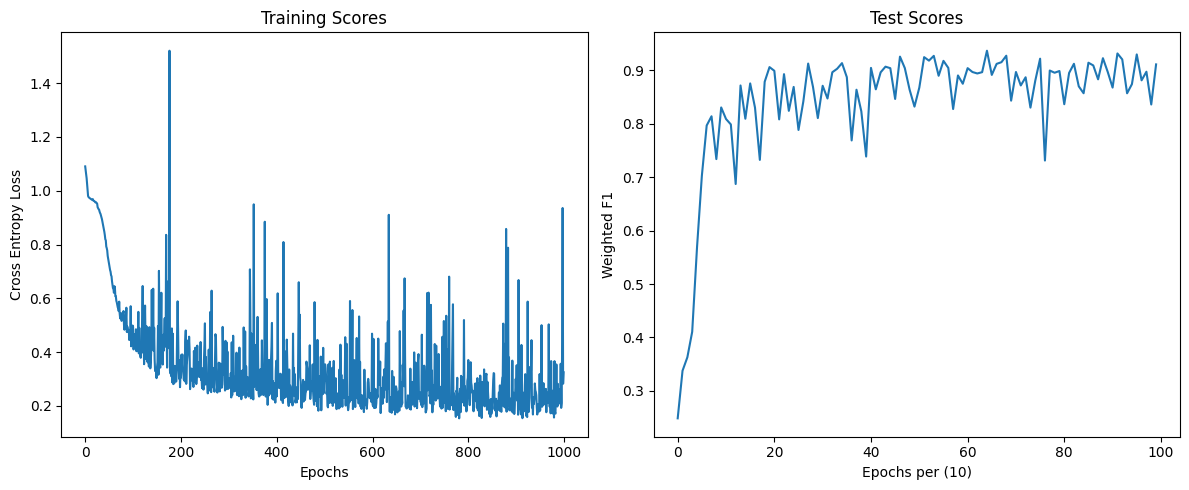

In [8]:
#wywolanie 3
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='softmax')
soft3_train, soft3_test,soft3_final, soft3_time, soft3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.00124394, Test F1: 0.4486
Epoch 10, Training F1: 0.90640430, Test F1: 0.4474
Epoch 20, Training F1: 0.87881745, Test F1: 0.4737
Epoch 30, Training F1: 0.85198083, Test F1: 0.5408
Epoch 40, Training F1: 0.83422455, Test F1: 0.5840
Epoch 50, Training F1: 0.81696779, Test F1: 0.5708
Epoch 60, Training F1: 0.80476172, Test F1: 0.5559
Epoch 70, Training F1: 0.77567298, Test F1: 0.6111
Epoch 80, Training F1: 0.76146618, Test F1: 0.6048
Epoch 90, Training F1: 0.73189480, Test F1: 0.6452
Epoch 100, Training F1: 0.71211069, Test F1: 0.6580
Epoch 110, Training F1: 0.65700248, Test F1: 0.7196
Epoch 120, Training F1: 0.59664780, Test F1: 0.7029
Epoch 130, Training F1: 0.59991385, Test F1: 0.6962
Epoch 140, Training F1: 0.52552245, Test F1: 0.8519
Epoch 150, Training F1: 0.52159076, Test F1: 0.7880
Epoch 160, Training

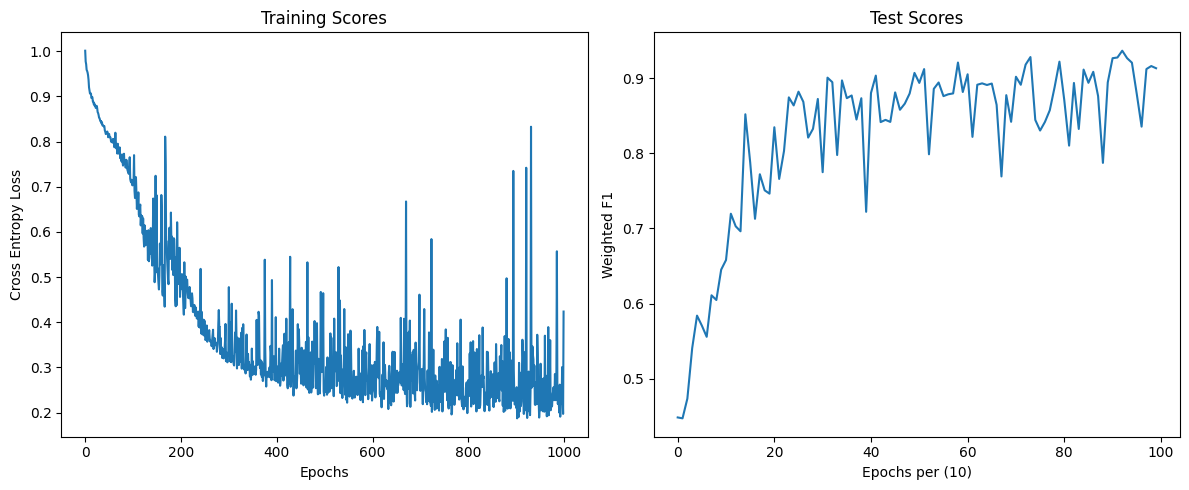

In [9]:
#wywolanie 4 
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='softmax')
soft4_train, soft4_test,soft4_final, soft4_time, soft4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.75)

In [10]:
# results 1
soft_epoch = [soft1_epoch, soft2_epoch, soft3_epoch, soft4_epoch]
soft_time = [soft1_time, soft2_time, soft3_time, soft4_time]

print(f'Mean epoch number {np.mean(soft_epoch)}')
print(f'Mean time : {np.mean(soft_time)}')

Mean epoch number 999.0
Mean time : 4.4583088755607605


## Sigmoid activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.67685630, Test F1: 0.2360
Epoch 10, Training F1: 1.05705325, Test F1: 0.2360
Epoch 20, Training F1: 1.09437571, Test F1: 0.3036
Epoch 30, Training F1: 1.09769408, Test F1: 0.3929
Epoch 40, Training F1: 1.09793835, Test F1: 0.3929
Epoch 50, Training F1: 1.09789141, Test F1: 0.2986
Epoch 60, Training F1: 1.09781548, Test F1: 0.3088
Epoch 70, Training F1: 1.09773775, Test F1: 0.3103
Epoch 80, Training F1: 1.09764817, Test F1: 0.3060
Epoch 90, Training F1: 1.09751691, Test F1: 0.4043
Epoch 100, Training F1: 1.09741036, Test F1: 0.2985
Epoch 110, Training F1: 1.09722714, Test F1: 0.2984
Epoch 120, Training F1: 1.09703894, Test F1: 0.4714
Epoch 130, Training F1: 1.09680366, Test F1: 0.2979
Epoch 140, Training F1: 1.09651077, Test F1: 0.4315
Epoch 150, Training F1: 1.09618960, Test F1: 0.4547
Epoch 160, Training

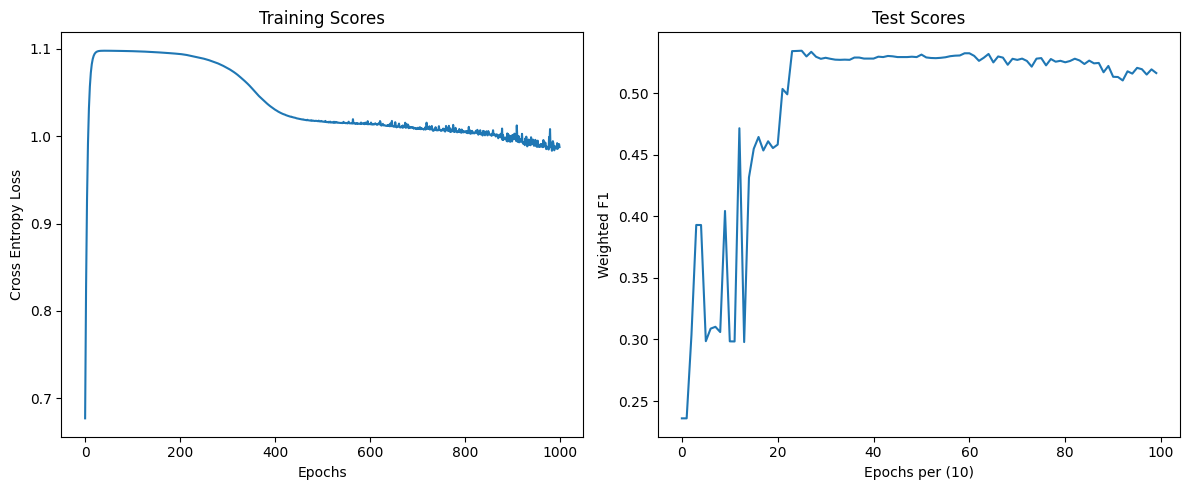

In [11]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm1_train, sigm1_test, sigm1_final, sigm1_time, sigm1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.84455309, Test F1: 0.2360
Epoch 10, Training F1: 1.06929050, Test F1: 0.2360
Epoch 20, Training F1: 1.09528413, Test F1: 0.3319
Epoch 30, Training F1: 1.09789133, Test F1: 0.3784
Epoch 40, Training F1: 1.09810118, Test F1: 0.3584
Epoch 50, Training F1: 1.09803229, Test F1: 0.2569
Epoch 60, Training F1: 1.09792282, Test F1: 0.3568
Epoch 70, Training F1: 1.09779754, Test F1: 0.3468
Epoch 80, Training F1: 1.09768285, Test F1: 0.2834
Epoch 90, Training F1: 1.09750448, Test F1: 0.3735
Epoch 100, Training F1: 1.09733516, Test F1: 0.3743
Epoch 110, Training F1: 1.09713222, Test F1: 0.4695
Epoch 120, Training F1: 1.09688496, Test F1: 0.4463
Epoch 130, Training F1: 1.09664072, Test F1: 0.4923
Epoch 140, Training F1: 1.09631370, Test F1: 0.5081
Epoch 150, Training F1: 1.09591551, Test F1: 0.5118
Epoch 160, Training

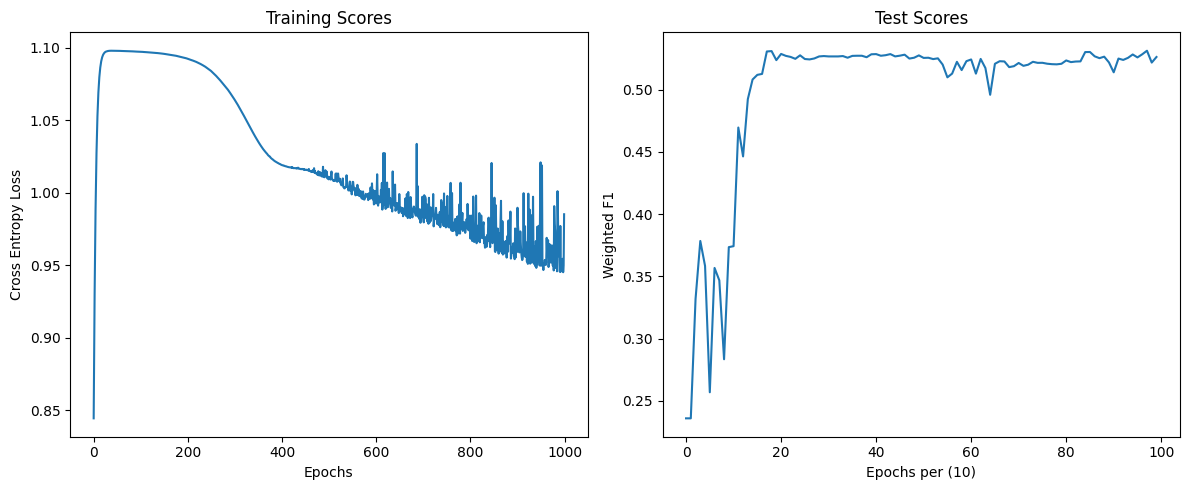

In [12]:
#proba 2
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm2_train, sigm2_test, sigm2_final, sigm2_time, sigm2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.76293736, Test F1: 0.2136
Epoch 10, Training F1: 1.06674104, Test F1: 0.2136
Epoch 20, Training F1: 1.09494793, Test F1: 0.4217
Epoch 30, Training F1: 1.09728435, Test F1: 0.4243
Epoch 40, Training F1: 1.09727135, Test F1: 0.2936
Epoch 50, Training F1: 1.09724892, Test F1: 0.4197
Epoch 60, Training F1: 1.09706080, Test F1: 0.4311
Epoch 70, Training F1: 1.09688288, Test F1: 0.2939
Epoch 80, Training F1: 1.09668581, Test F1: 0.2964
Epoch 90, Training F1: 1.09652315, Test F1: 0.4366
Epoch 100, Training F1: 1.09621517, Test F1: 0.4517
Epoch 110, Training F1: 1.09585978, Test F1: 0.3011
Epoch 120, Training F1: 1.09555507, Test F1: 0.4597
Epoch 130, Training F1: 1.09520708, Test F1: 0.4491
Epoch 140, Training F1: 1.09487053, Test F1: 0.4609
Epoch 150, Training F1: 1.09456431, Test F1: 0.4646
Epoch 160, Training

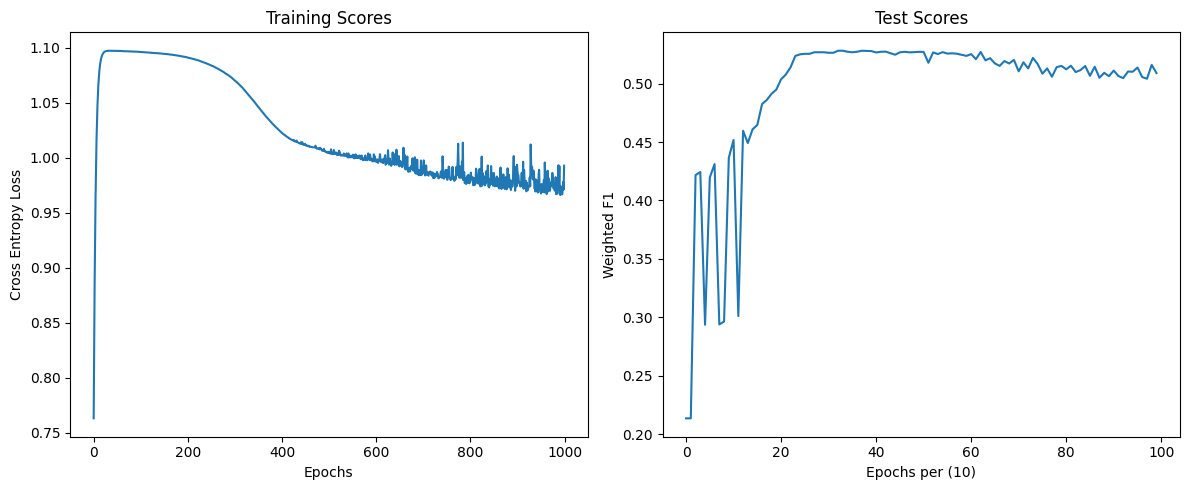

In [13]:
# 3
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm3_train, sigm3_test, sigm3_final, sigm3_time, sigm3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.69110819, Test F1: 0.2136
Epoch 10, Training F1: 1.04092147, Test F1: 0.2136
Epoch 20, Training F1: 1.09170529, Test F1: 0.2415
Epoch 30, Training F1: 1.09764206, Test F1: 0.2103
Epoch 40, Training F1: 1.09803251, Test F1: 0.2112
Epoch 50, Training F1: 1.09783255, Test F1: 0.5040
Epoch 60, Training F1: 1.09758326, Test F1: 0.4765
Epoch 70, Training F1: 1.09732858, Test F1: 0.5030
Epoch 80, Training F1: 1.09702002, Test F1: 0.4849
Epoch 90, Training F1: 1.09672956, Test F1: 0.5073
Epoch 100, Training F1: 1.09628094, Test F1: 0.5122
Epoch 110, Training F1: 1.09577422, Test F1: 0.5132
Epoch 120, Training F1: 1.09517458, Test F1: 0.5135
Epoch 130, Training F1: 1.09441677, Test F1: 0.5161
Epoch 140, Training F1: 1.09354507, Test F1: 0.5175
Epoch 150, Training F1: 1.09243788, Test F1: 0.5162
Epoch 160, Training

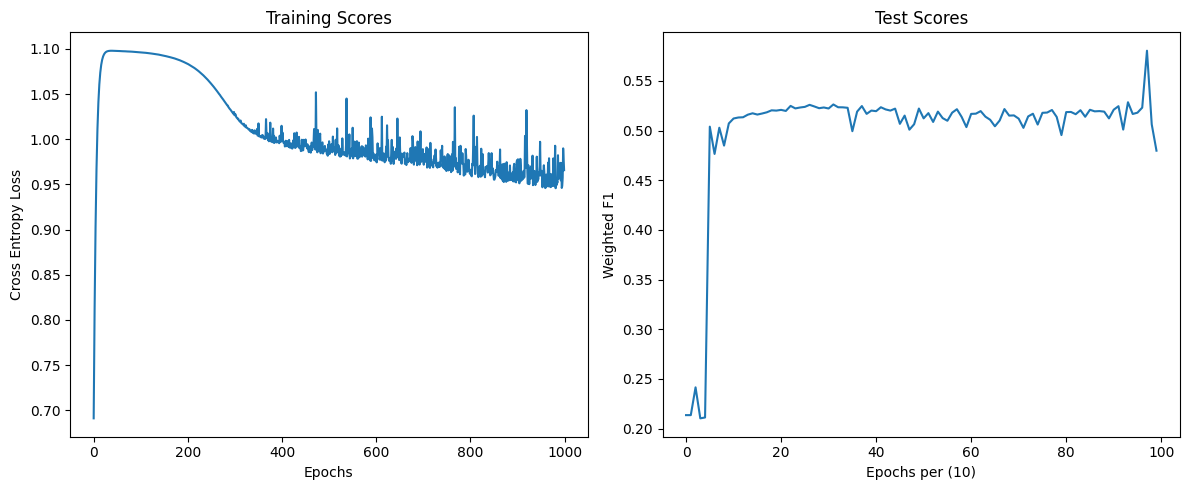

In [14]:
#4
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm4_train, sigm4_test, sigm4_final, sigm4_time, sigm4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

In [15]:
#results
sigm_epoch = [sigm1_epoch, sigm2_epoch, sigm3_epoch, sigm4_epoch]
sigm_time = [sigm1_time, sigm2_time, sigm3_time, sigm4_time]

print('Mean epoch number', np.mean(sigm_epoch))
print('Mean time', np.mean(sigm_time))

Mean epoch number 999.0
Mean time 5.584677755832672


## Tanh

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 1.47222542, Test F1: 0.3587
Epoch 10, Training F1: 1.05666601, Test F1: 0.3758
Epoch 20, Training F1: 1.01019281, Test F1: 0.3127
Epoch 30, Training F1: 0.94492820, Test F1: 0.3099
Epoch 40, Training F1: 0.87165755, Test F1: 0.3382
Epoch 50, Training F1: 0.83471048, Test F1: 0.3494
Epoch 60, Training F1: 0.84546968, Test F1: 0.4128
Epoch 70, Training F1: 0.80421499, Test F1: 0.4415
Epoch 80, Training F1: 0.78309297, Test F1: 0.4535
Epoch 90, Training F1: 0.76296031, Test F1: 0.4584
Epoch 100, Training F1: 0.77807231, Test F1: 0.4858
Epoch 110, Training F1: 0.81650652, Test F1: 0.4544
Epoch 120, Training F1: 0.79261061, Test F1: 0.4905
Epoch 130, Training F1: 0.80277487, Test F1: 0.4997
Epoch 140, Training F1: 0.83748777, Test F1: 0.5043
Epoch 150, Training F1: 0.80698116, Test F1: 0.5173
Epoch 160, Training F1

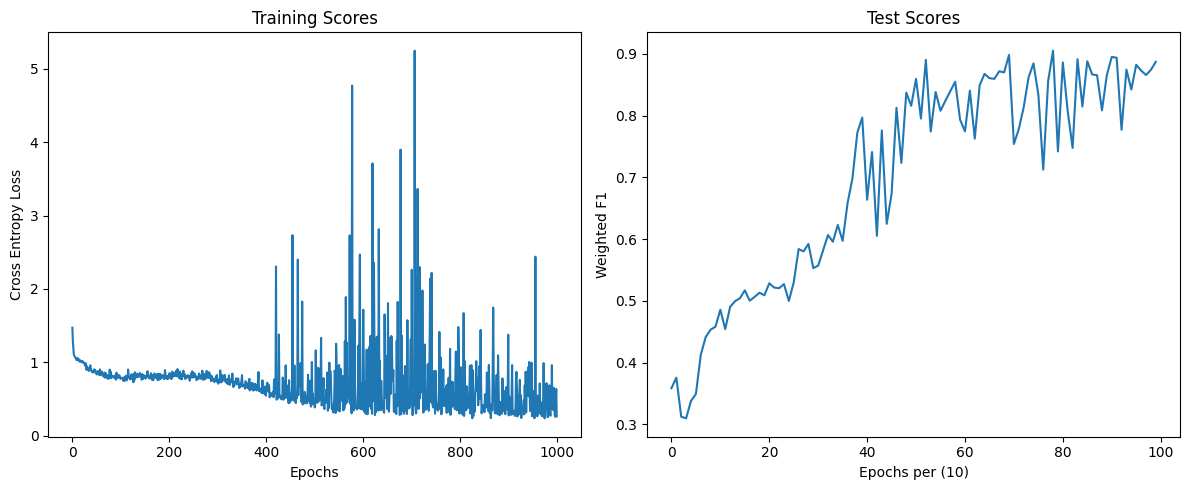

In [16]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='tanh')
tanh1_train, tanh1_test, tanh1_final, tanh1_time, tanh1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 19.45600856, Test F1: 0.3099
Epoch 10, Training F1: 1.07902802, Test F1: 0.4006
Epoch 20, Training F1: 1.05775768, Test F1: 0.4222
Epoch 30, Training F1: 1.00807758, Test F1: 0.4205
Epoch 40, Training F1: 1.00035202, Test F1: 0.4508
Epoch 50, Training F1: 0.98044250, Test F1: 0.4564
Epoch 60, Training F1: 0.95275186, Test F1: 0.4619
Epoch 70, Training F1: 0.93522116, Test F1: 0.4629
Epoch 80, Training F1: 0.92501096, Test F1: 0.5194
Epoch 90, Training F1: 0.92785649, Test F1: 0.4783
Epoch 100, Training F1: 0.90856106, Test F1: 0.5354
Epoch 110, Training F1: 0.87051979, Test F1: 0.5480
Epoch 120, Training F1: 0.86787867, Test F1: 0.5929
Epoch 130, Training F1: 0.83353691, Test F1: 0.6074
Epoch 140, Training F1: 0.80321528, Test F1: 0.6115
Epoch 150, Training F1: 0.76139244, Test F1: 0.6279
Epoch 160, Training F

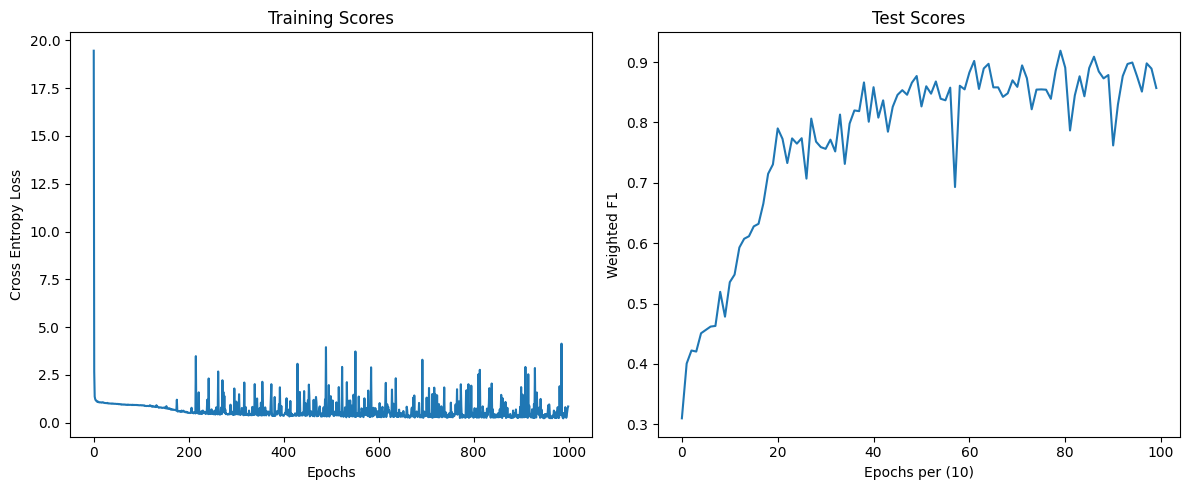

In [17]:
#2
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='tanh')
tanh2_train, tanh2_test, tanh2_final, tanh2_time, tanh2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 3.10913127, Test F1: 0.4323
Epoch 10, Training F1: 1.04636882, Test F1: 0.4703
Epoch 20, Training F1: 0.87309866, Test F1: 0.6435
Epoch 30, Training F1: 0.82198210, Test F1: 0.6480
Epoch 40, Training F1: 0.77497903, Test F1: 0.6664
Epoch 50, Training F1: 0.79899086, Test F1: 0.6332
Epoch 60, Training F1: 0.73056360, Test F1: 0.7406
Epoch 70, Training F1: 0.69927421, Test F1: 0.7217
Epoch 80, Training F1: 0.66206745, Test F1: 0.7489
Epoch 90, Training F1: 0.62730834, Test F1: 0.7421
Epoch 100, Training F1: 0.58467138, Test F1: 0.7692
Epoch 110, Training F1: 0.57585211, Test F1: 0.7466
Epoch 120, Training F1: 0.54138922, Test F1: 0.7885
Epoch 130, Training F1: 0.53660431, Test F1: 0.7326
Epoch 140, Training F1: 0.52436021, Test F1: 0.7222
Epoch 150, Training F1: 0.52185365, Test F1: 0.7391
Epoch 160, Training F1

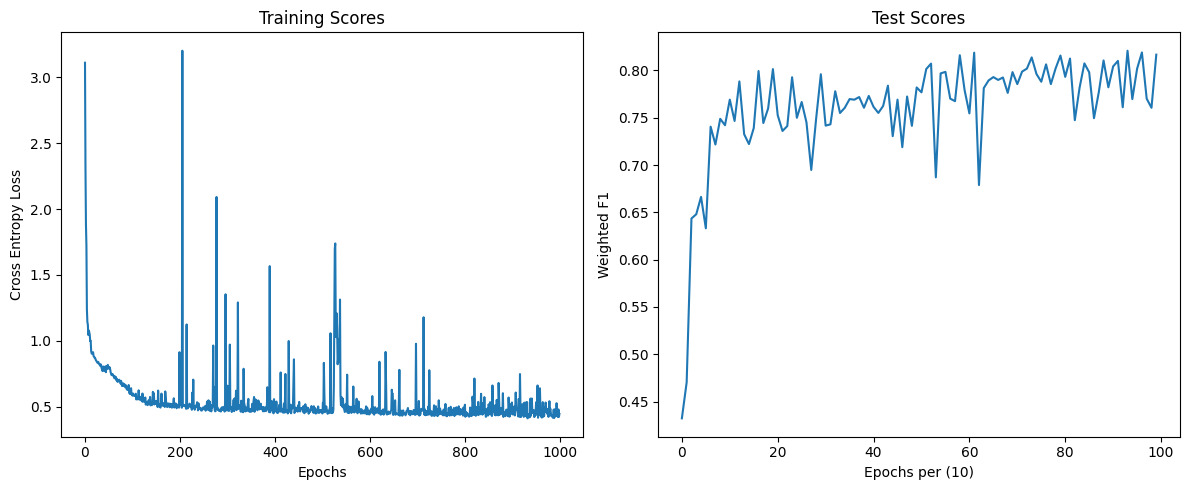

In [18]:
#3
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='tanh')
tanh3_train, tanh3_test, tanh3_final, tanh3_time, tanh3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 7.35797554, Test F1: 0.4673
Epoch 10, Training F1: 1.00019189, Test F1: 0.5367
Epoch 20, Training F1: 0.94803005, Test F1: 0.5656
Epoch 30, Training F1: 0.94242979, Test F1: 0.5538
Epoch 40, Training F1: 0.90293177, Test F1: 0.5912
Epoch 50, Training F1: 0.85681696, Test F1: 0.6362
Epoch 60, Training F1: 0.85072590, Test F1: 0.6134
Epoch 70, Training F1: 0.77429784, Test F1: 0.6744
Epoch 80, Training F1: 0.80960582, Test F1: 0.6124
Epoch 90, Training F1: 0.72528688, Test F1: 0.7411
Epoch 100, Training F1: 0.69499734, Test F1: 0.7920
Epoch 110, Training F1: 0.64151111, Test F1: 0.7805
Epoch 120, Training F1: 0.57569777, Test F1: 0.7998
Epoch 130, Training F1: 0.53748904, Test F1: 0.8281
Epoch 140, Training F1: 0.47381184, Test F1: 0.8616
Epoch 150, Training F1: 0.45207153, Test F1: 0.8344
Epoch 160, Training F1

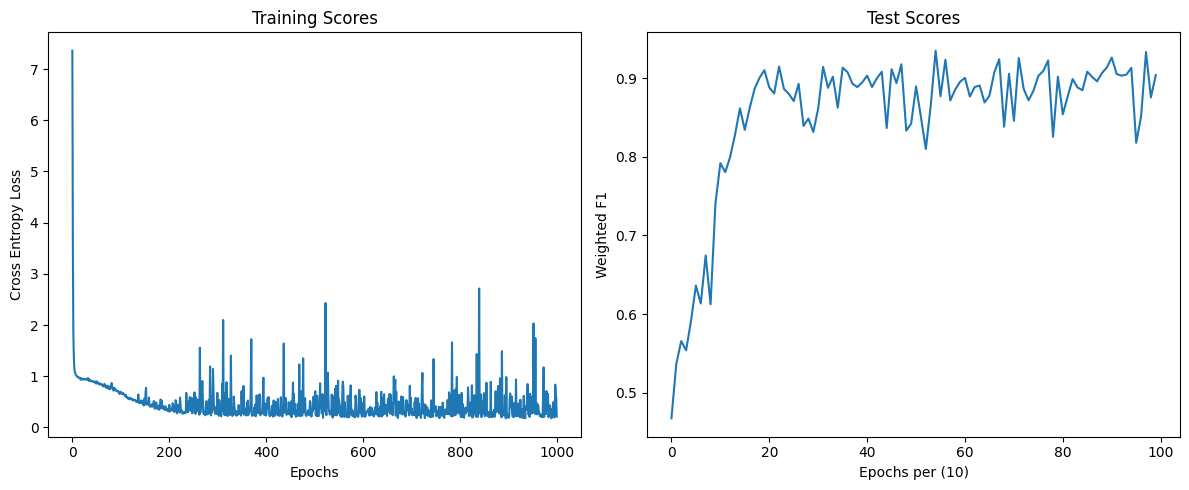

In [19]:
#4
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="relu", last_layer_activation='tanh')
tanh4_train, tanh4_test, tanh4_final, tanh4_time, tanh4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

In [20]:
tanh_epoch =[tanh1_epoch, tanh2_epoch, tanh3_epoch, tanh4_epoch]
tanh_time = [tanh1_time, tanh2_time, tanh3_time, tanh4_time]
print('Mean epoch number', np.mean(tanh_epoch))
print('Mean time', np.mean(tanh_time))

Mean epoch number 999.0
Mean time 4.161352694034576


## Relu

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 1.94955977, Test F1: 0.0716
Epoch 10, Training F1: 1.10215516, Test F1: 0.1725
Epoch 20, Training F1: 1.10135383, Test F1: 0.2216
Epoch 30, Training F1: 1.10060399, Test F1: 0.1132
Epoch 40, Training F1: 1.09985972, Test F1: 0.2202
Epoch 50, Training F1: 1.09924034, Test F1: 0.0720
Epoch 60, Training F1: 1.09849786, Test F1: 0.3871
Epoch 70, Training F1: 1.09758260, Test F1: 0.1902
Epoch 80, Training F1: 1.09680517, Test F1: 0.2549
Epoch 90, Training F1: 1.09617538, Test F1: 0.4282
Epoch 100, Training F1: 1.09516115, Test F1: 0.5138
Epoch 110, Training F1: 1.09430017, Test F1: 0.5219
Epoch 120, Training F1: 1.09318870, Test F1: 0.3028
Epoch 130, Training F1: 1.09203624, Test F1: 0.5333
Epoch 140, Training F1: 1.09087234, Test F1: 0.5290
Epoch 150, Training F1: 1.08976261, Test F1: 0.5289
Epoch 160, Training F1

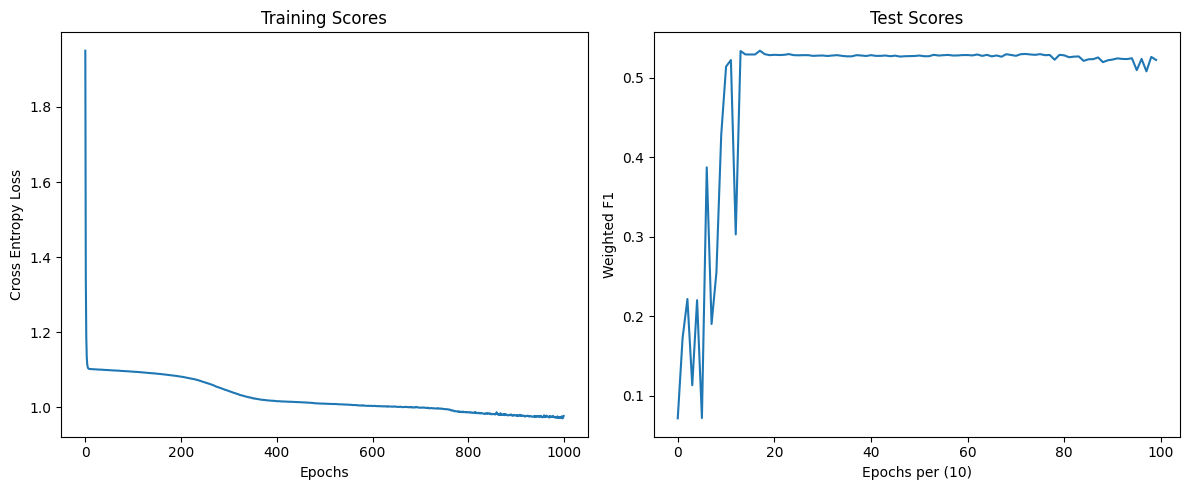

In [21]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='relu')
relu1_train, relu1_test, relu1_final, relu1_time, relu1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 12.17927043, Test F1: 0.2136
Epoch 10, Training F1: 1.09854684, Test F1: 0.1945
Epoch 20, Training F1: 1.09843957, Test F1: 0.3251
Epoch 30, Training F1: 1.09825583, Test F1: 0.2051
Epoch 40, Training F1: 1.09818745, Test F1: 0.2034
Epoch 50, Training F1: 1.09811688, Test F1: 0.2070
Epoch 60, Training F1: 1.09798057, Test F1: 0.2052
Epoch 70, Training F1: 1.09782044, Test F1: 0.2639
Epoch 80, Training F1: 1.09786681, Test F1: 0.2067
Epoch 90, Training F1: 1.09772313, Test F1: 0.2075
Epoch 100, Training F1: 1.09798377, Test F1: 0.2798
Epoch 110, Training F1: 1.09772014, Test F1: 0.2057
Epoch 120, Training F1: 1.09772411, Test F1: 0.2774
Epoch 130, Training F1: 1.09752397, Test F1: 0.4021
Epoch 140, Training F1: 1.09744261, Test F1: 0.2081
Epoch 150, Training F1: 1.09734619, Test F1: 0.1867
Epoch 160, Training F

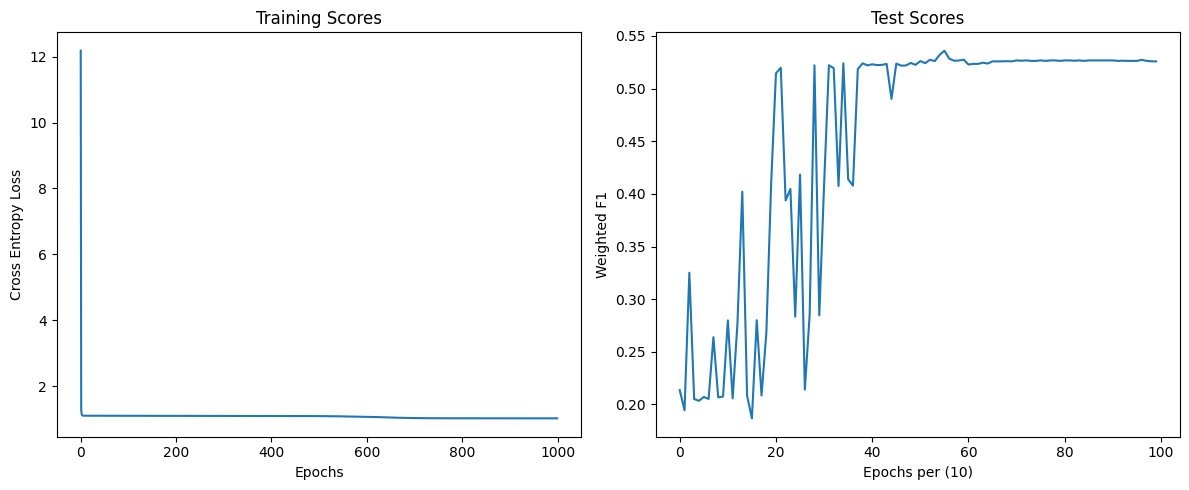

In [22]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='relu')
relu2_train, relu2_test, relu2_final, relu2_time, relu2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 1.78388412, Test F1: 0.2136
Epoch 10, Training F1: 1.10010656, Test F1: 0.2816
Epoch 20, Training F1: 1.09869795, Test F1: 0.3484
Epoch 30, Training F1: 1.09691389, Test F1: 0.4029
Epoch 40, Training F1: 1.09541247, Test F1: 0.4129
Epoch 50, Training F1: 1.09399532, Test F1: 0.4189
Epoch 60, Training F1: 1.09276237, Test F1: 0.4259
Epoch 70, Training F1: 1.09145550, Test F1: 0.4315
Epoch 80, Training F1: 1.09020011, Test F1: 0.4218
Epoch 90, Training F1: 1.08867864, Test F1: 0.4246
Epoch 100, Training F1: 1.08705036, Test F1: 0.4434
Epoch 110, Training F1: 1.08519220, Test F1: 0.4444
Epoch 120, Training F1: 1.08339681, Test F1: 0.5570
Epoch 130, Training F1: 1.08128491, Test F1: 0.4424
Epoch 140, Training F1: 1.07893478, Test F1: 0.5510
Epoch 150, Training F1: 1.07635028, Test F1: 0.4487
Epoch 160, Training F1

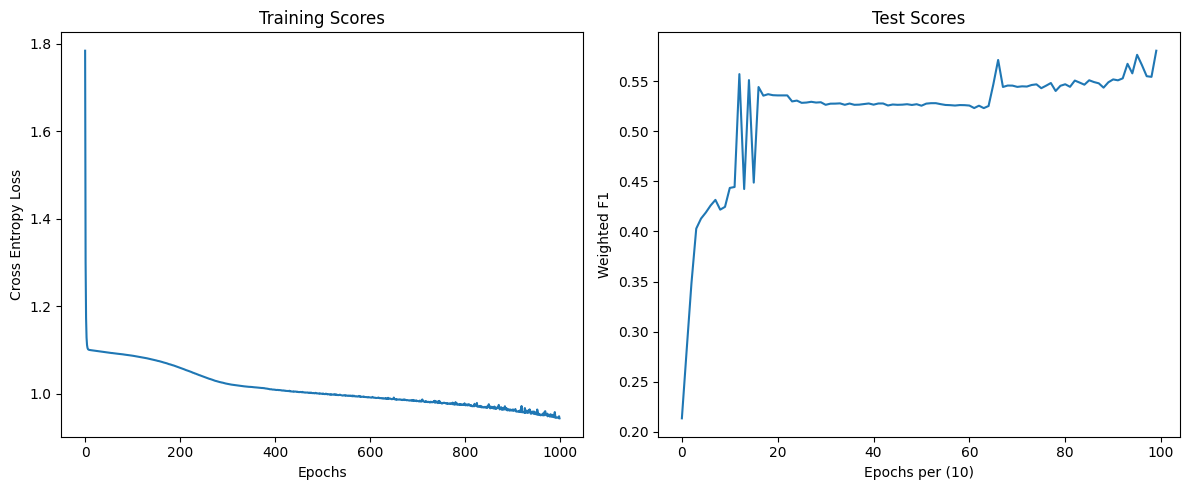

In [23]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='relu')
relu3_train, relu3_test, relu3_final, relu3_time, relu3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 13.13608980, Test F1: 0.0716
Epoch 10, Training F1: 1.09959984, Test F1: 0.2413
Epoch 20, Training F1: 1.09885473, Test F1: 0.1991
Epoch 30, Training F1: 1.09845527, Test F1: 0.2438
Epoch 40, Training F1: 1.09808876, Test F1: 0.4599
Epoch 50, Training F1: 1.09759586, Test F1: 0.4224
Epoch 60, Training F1: 1.09718427, Test F1: 0.2499
Epoch 70, Training F1: 1.09671609, Test F1: 0.5087
Epoch 80, Training F1: 1.09639778, Test F1: 0.4023
Epoch 90, Training F1: 1.09592774, Test F1: 0.4949
Epoch 100, Training F1: 1.09537145, Test F1: 0.4465
Epoch 110, Training F1: 1.09506510, Test F1: 0.5209
Epoch 120, Training F1: 1.09457566, Test F1: 0.5206
Epoch 130, Training F1: 1.09388536, Test F1: 0.4605
Epoch 140, Training F1: 1.09330479, Test F1: 0.4555
Epoch 150, Training F1: 1.09288529, Test F1: 0.5393
Epoch 160, Training F

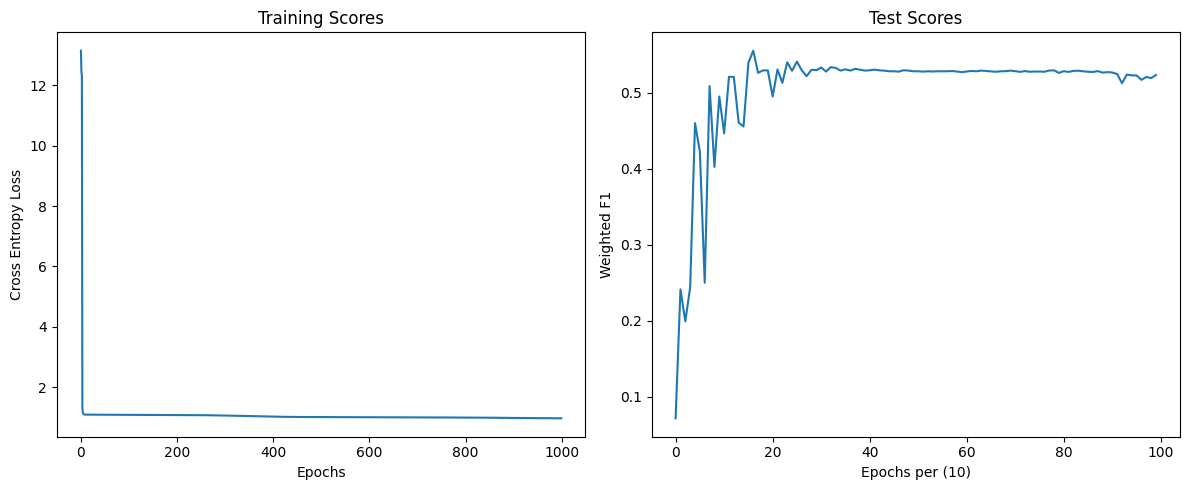

In [24]:
nn = NeuralNetwork(layers=[2, 4,8,4, 3], activation="sigmoid", last_layer_activation='relu')
relu4_train, relu4_test, relu4_final, relu4_time, relu4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000,report_frequency=10, loss_threshold=1.75)

In [26]:
relu_epoch = [relu1_epoch, relu2_epoch, relu3_epoch, relu4_epoch]
relu_time = [relu1_time, relu2_time, relu3_time, relu4_time]
print('mean epoch', np.mean(relu_epoch))
print('mean time', np.mean(relu_time))

mean epoch 999.0
mean time 5.617423713207245


## Comparison

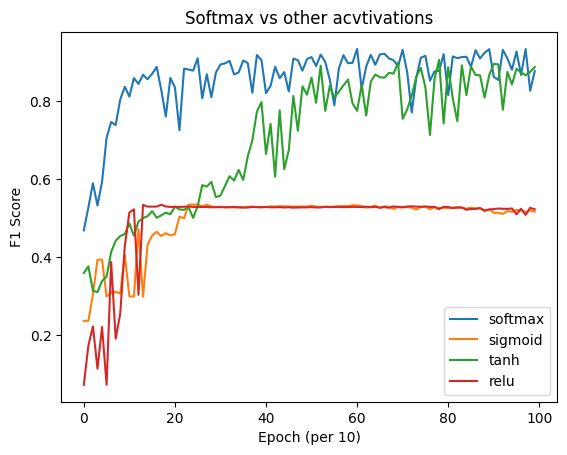

In [27]:
plt.plot(soft2_test, label='softmax')
plt.plot(sigm1_test, label='sigmoid')
plt.plot(tanh1_test, label='tanh')
plt.plot(relu1_test, label='relu')
plt.title('Softmax vs other acvtivations')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

Text(0.5, 1.0, 'Final F1 for each attempt')

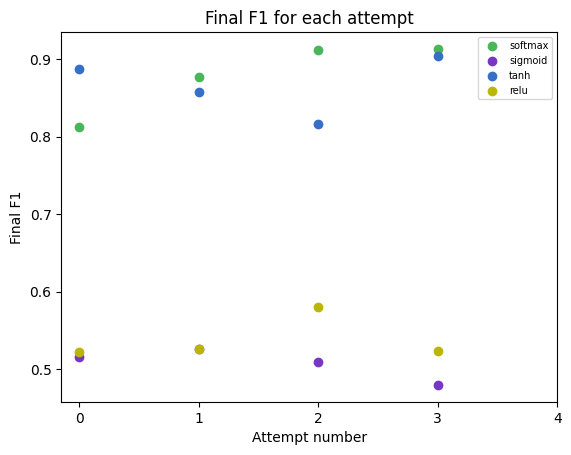

In [28]:
soft_final = [soft1_final, soft2_final, soft3_final, soft4_final]
sigm_final = [ sigm1_final, sigm2_final, sigm3_final, sigm4_final]
tanh_final = [tanh1_final, tanh2_final, tanh3_final, tanh4_final]
relu_final = [relu1_final, relu2_final, relu3_final, relu4_final]

plt.scatter(np.arange(len(soft_final)),soft_final, color='#4ab659', label='softmax')
plt.scatter(np.arange(len(sigm_final)),sigm_final, color='#7835c6', label='sigmoid')
plt.scatter(np.arange(len(tanh_final)),tanh_final, color='#3570c6', label='tanh')
plt.scatter(np.arange(len(relu_final)),relu_final, color='#bbb604', label='relu')
plt.xticks([0,1,2,3,4])
plt.xlabel('Attempt number')
plt.ylabel('Final F1')
plt.legend(loc='upper right', fontsize = 7)
plt.title('Final F1 for each attempt')

# 64 32 Rings

## Softmax

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.08047920, Test F1: 0.4896
Epoch 10, Training F1: 0.86712123, Test F1: 0.5201
Epoch 20, Training F1: 0.79536489, Test F1: 0.5699
Epoch 30, Training F1: 0.75861173, Test F1: 0.6344
Epoch 40, Training F1: 0.78285711, Test F1: 0.5972
Epoch 50, Training F1: 0.76817606, Test F1: 0.6463
Epoch 60, Training F1: 0.74486780, Test F1: 0.6342
Epoch 70, Training F1: 0.78147825, Test F1: 0.5494
Epoch 80, Training F1: 0.72511016, Test F1: 0.5889
Epoch 90, Training F1: 0.86677078, Test F1: 0.5915
Epoch 100, Training F1: 0.63558347, Test F1: 0.6792
Epoch 110, Training F1: 0.75302044, Test F1: 0.6317
Epoch 120, Training F1: 0.64131579, Test F1: 0.7136
Epoch 130, Training F1: 0.70760396, Test F1: 0.6788
Epoch 140, Training F1: 0.57315764, Test F1: 0.7305
Epoch 150, Training F1: 0.62546760, Test F1: 0.6853
Epoch 160, Training

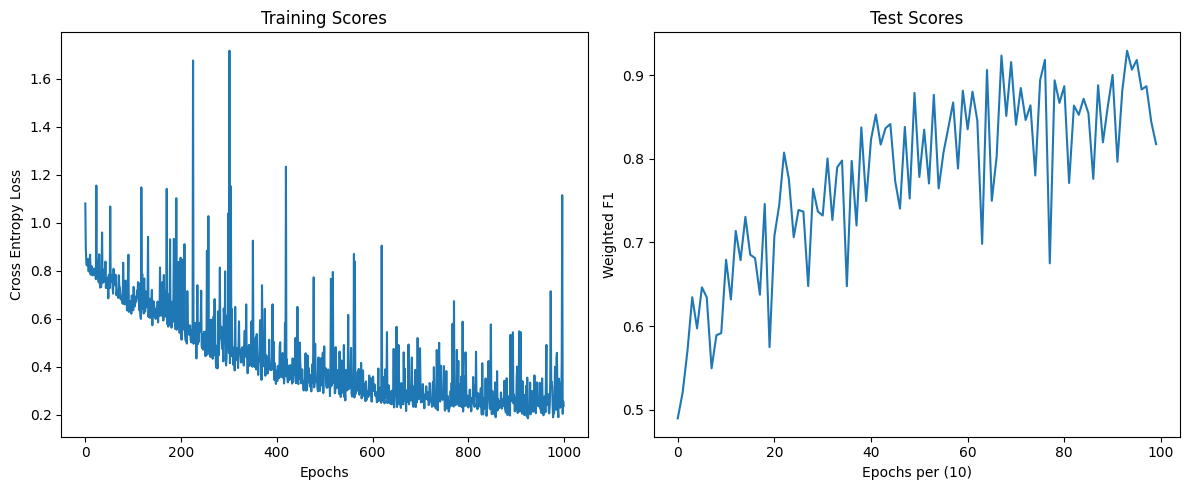

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.99422297, Test F1: 0.5326
Epoch 10, Training F1: 0.84478346, Test F1: 0.5529
Epoch 20, Training F1: 0.84360623, Test F1: 0.5190
Epoch 30, Training F1: 0.78781584, Test F1: 0.5725
Epoch 40, Training F1: 0.79529997, Test F1: 0.5674
Epoch 50, Training F1: 0.72070801, Test F1: 0.6381
Epoch 60, Training F1: 0.75822917, Test F1: 0.6021
Epoch 70, Training F1: 0.74592139, Test F1: 0.6138
Epoch 80, Training F1: 0.75072804, Test F1: 0.6238
Epoch 90, Training F1: 0.88635282, Test F1: 0.5067
Epoch 100, Training F1: 0.73085042, Test F1: 0.6483
Epoch 110, Training F1: 0.67724596, Test F1: 0.6666
Epoch 120, Training F1: 0.67027526, Test F1: 0.6314
Epoch 130, Training F1: 0.66628534, Test F1: 0.6556
Epoch 140, Training F1: 0.60167002, Test F1: 0.6940
Epoch 150, Training F1: 0.61477272, Test F1: 0.6743
Epoch 160, Training

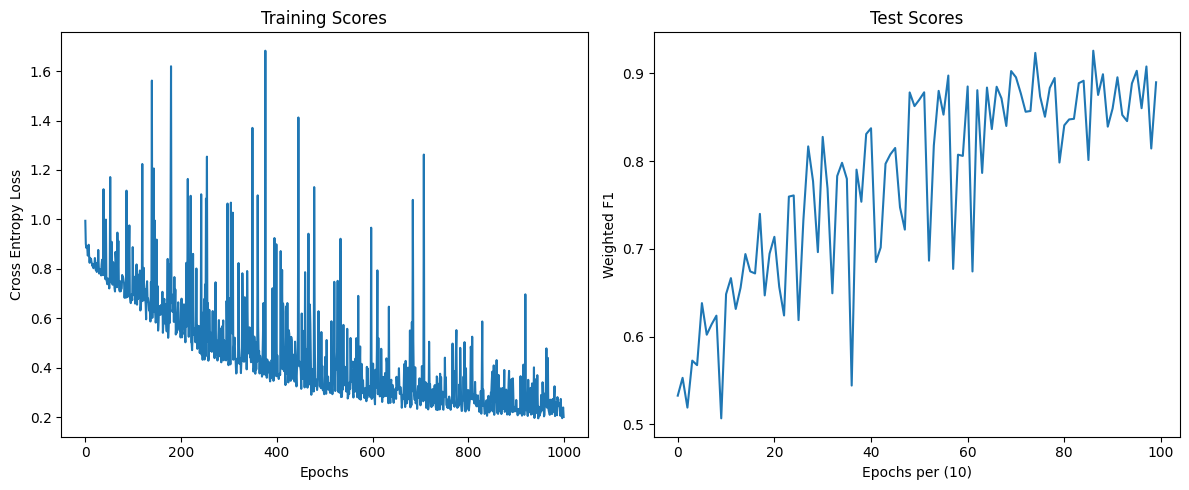

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.92483716, Test F1: 0.4804
Epoch 10, Training F1: 0.85253433, Test F1: 0.5265
Epoch 20, Training F1: 0.80154001, Test F1: 0.6053
Epoch 30, Training F1: 0.77872819, Test F1: 0.6034
Epoch 40, Training F1: 0.83078894, Test F1: 0.5722
Epoch 50, Training F1: 0.74869663, Test F1: 0.6182
Epoch 60, Training F1: 0.79909536, Test F1: 0.6406
Epoch 70, Training F1: 0.82456879, Test F1: 0.5260
Epoch 80, Training F1: 0.75576327, Test F1: 0.6181
Epoch 90, Training F1: 0.79116293, Test F1: 0.6374
Epoch 100, Training F1: 1.00755582, Test F1: 0.5305
Epoch 110, Training F1: 0.71681217, Test F1: 0.6447
Epoch 120, Training F1: 0.68907517, Test F1: 0.6702
Epoch 130, Training F1: 0.67629224, Test F1: 0.6848
Epoch 140, Training F1: 0.69591101, Test F1: 0.7143
Epoch 150, Training F1: 0.60747421, Test F1: 0.6869
Epoch 160, Training

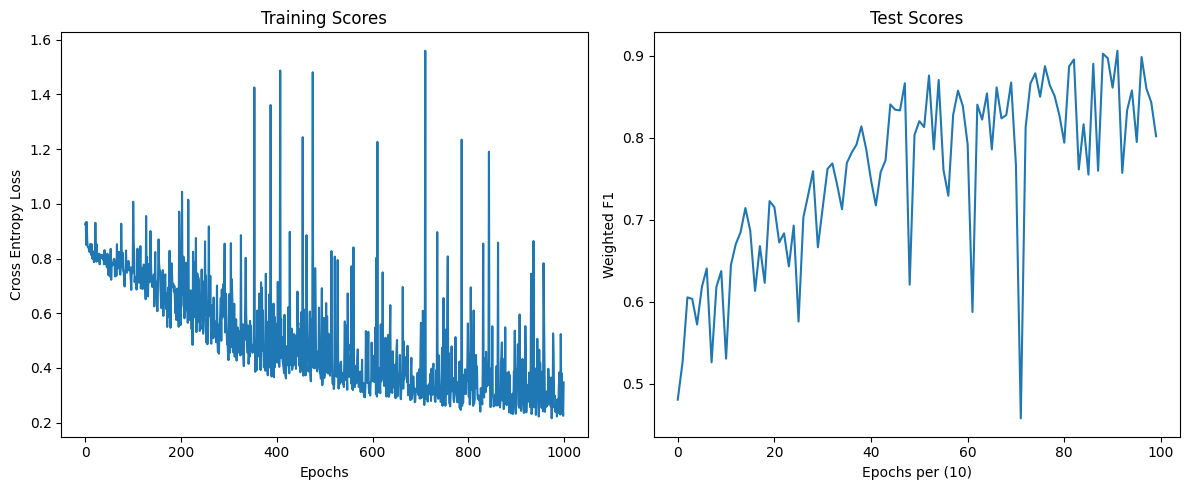

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.89374253, Test F1: 0.5060
Epoch 10, Training F1: 0.82283967, Test F1: 0.5905
Epoch 20, Training F1: 0.82127109, Test F1: 0.5848
Epoch 30, Training F1: 0.79575847, Test F1: 0.5717
Epoch 40, Training F1: 0.80594854, Test F1: 0.5693
Epoch 50, Training F1: 0.79897764, Test F1: 0.6219
Epoch 60, Training F1: 0.75176298, Test F1: 0.6040
Epoch 70, Training F1: 0.75223611, Test F1: 0.6154
Epoch 80, Training F1: 0.83224099, Test F1: 0.6134
Epoch 90, Training F1: 0.76030231, Test F1: 0.5902
Epoch 100, Training F1: 0.76556953, Test F1: 0.6247
Epoch 110, Training F1: 0.73021221, Test F1: 0.6904
Epoch 120, Training F1: 0.80649711, Test F1: 0.6116
Epoch 130, Training F1: 0.67380858, Test F1: 0.6636
Epoch 140, Training F1: 0.83868422, Test F1: 0.5545
Epoch 150, Training F1: 0.71445864, Test F1: 0.6093
Epoch 160, Training

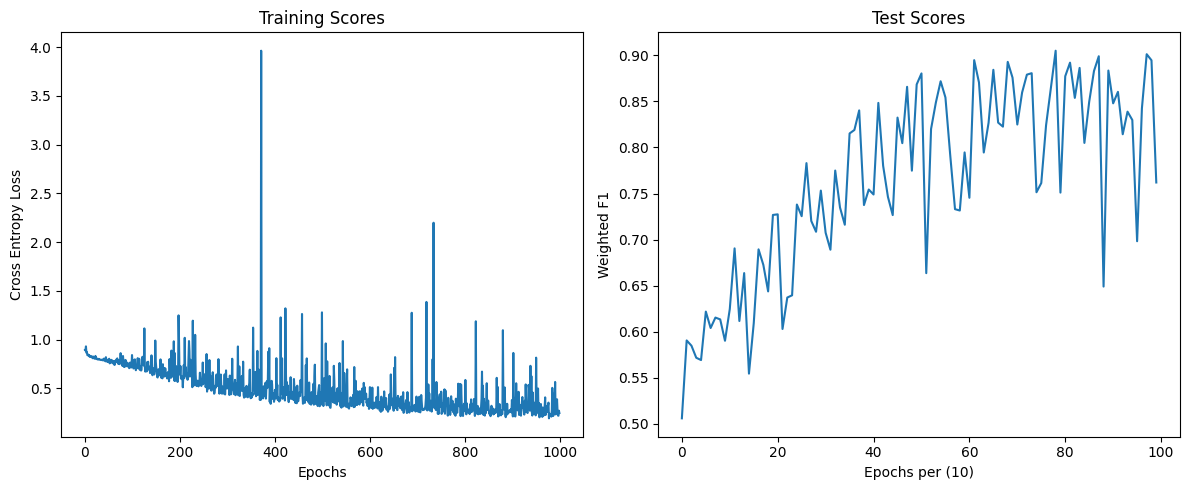

In [29]:
nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='softmax')
soft1_train, soft1_test,soft1_final, soft1_time, soft1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='softmax')
soft2_train, soft2_test,soft2_final, soft2_time, soft2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='softmax')
soft3_train, soft3_test,soft3_final, soft3_time, soft3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='softmax')
soft4_train, soft4_test,soft4_final, soft4_time, soft4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

## Sigmoid

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 1.11066446, Test F1: 0.2707
Epoch 10, Training F1: 1.00446685, Test F1: 0.5304
Epoch 20, Training F1: 0.98548506, Test F1: 0.5559
Epoch 30, Training F1: 0.96974074, Test F1: 0.5725
Epoch 40, Training F1: 0.95742718, Test F1: 0.5960
Epoch 50, Training F1: 0.94691742, Test F1: 0.6029
Epoch 60, Training F1: 0.93354542, Test F1: 0.6009
Epoch 70, Training F1: 0.91940744, Test F1: 0.5932
Epoch 80, Training F1: 0.90510224, Test F1: 0.6167
Epoch 90, Training F1: 0.88027899, Test F1: 0.6201
Epoch 100, Training F1: 0.86043367, Test F1: 0.6440
Epoch 110, Training F1: 0.84366353, Test F1: 0.6352
Epoch 120, Training F1: 0.82578381, Test F1: 0.6633
Epoch 130, Training F1: 0.80364411, Test F1: 0.6575
Epoch 140, Training F1: 0.78699878, Test F1: 0.6578
Epoch 150, Training F1: 0.80757232, Test F1: 0.6049
Epoch 160, Training

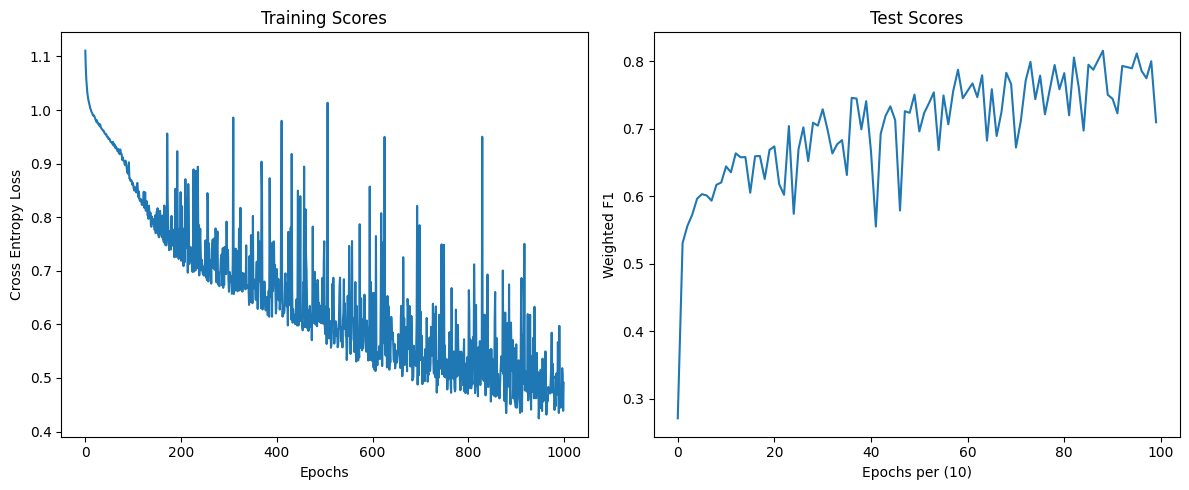

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.93684284, Test F1: 0.3915
Epoch 10, Training F1: 1.00977398, Test F1: 0.5368
Epoch 20, Training F1: 0.99057952, Test F1: 0.5883
Epoch 30, Training F1: 0.97711954, Test F1: 0.5891
Epoch 40, Training F1: 0.96367063, Test F1: 0.5891
Epoch 50, Training F1: 0.94792143, Test F1: 0.5881
Epoch 60, Training F1: 0.93575597, Test F1: 0.5819
Epoch 70, Training F1: 0.92404968, Test F1: 0.5817
Epoch 80, Training F1: 0.91775642, Test F1: 0.5952
Epoch 90, Training F1: 0.90697739, Test F1: 0.5963
Epoch 100, Training F1: 0.89446852, Test F1: 0.5830
Epoch 110, Training F1: 0.88494229, Test F1: 0.5830
Epoch 120, Training F1: 0.86716532, Test F1: 0.5989
Epoch 130, Training F1: 0.85642175, Test F1: 0.5977
Epoch 140, Training F1: 0.83823679, Test F1: 0.6111
Epoch 150, Training F1: 0.82787282, Test F1: 0.6130
Epoch 160, Training

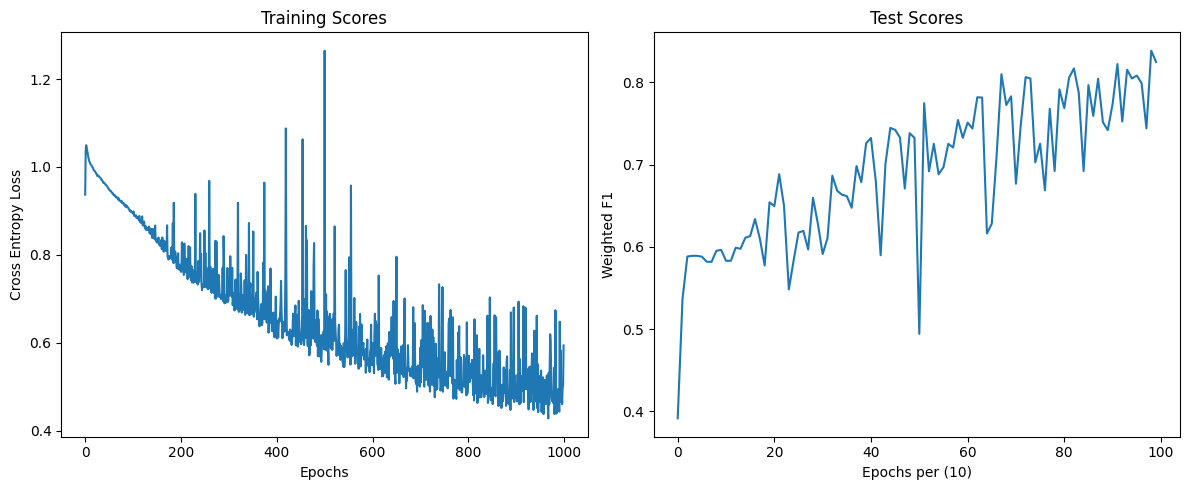

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 1.14445622, Test F1: 0.4829
Epoch 10, Training F1: 1.00408601, Test F1: 0.5590
Epoch 20, Training F1: 0.98100911, Test F1: 0.5709
Epoch 30, Training F1: 0.96762714, Test F1: 0.6023
Epoch 40, Training F1: 0.95356699, Test F1: 0.5912
Epoch 50, Training F1: 0.94161340, Test F1: 0.5891
Epoch 60, Training F1: 0.92743687, Test F1: 0.5873
Epoch 70, Training F1: 0.91506507, Test F1: 0.5909
Epoch 80, Training F1: 0.89984907, Test F1: 0.5967
Epoch 90, Training F1: 0.88957971, Test F1: 0.5976
Epoch 100, Training F1: 0.87713106, Test F1: 0.6109
Epoch 110, Training F1: 0.86377044, Test F1: 0.5994
Epoch 120, Training F1: 0.83791044, Test F1: 0.6182
Epoch 130, Training F1: 0.84033480, Test F1: 0.5969
Epoch 140, Training F1: 0.82989307, Test F1: 0.5638
Epoch 150, Training F1: 0.77947308, Test F1: 0.6612
Epoch 160, Training

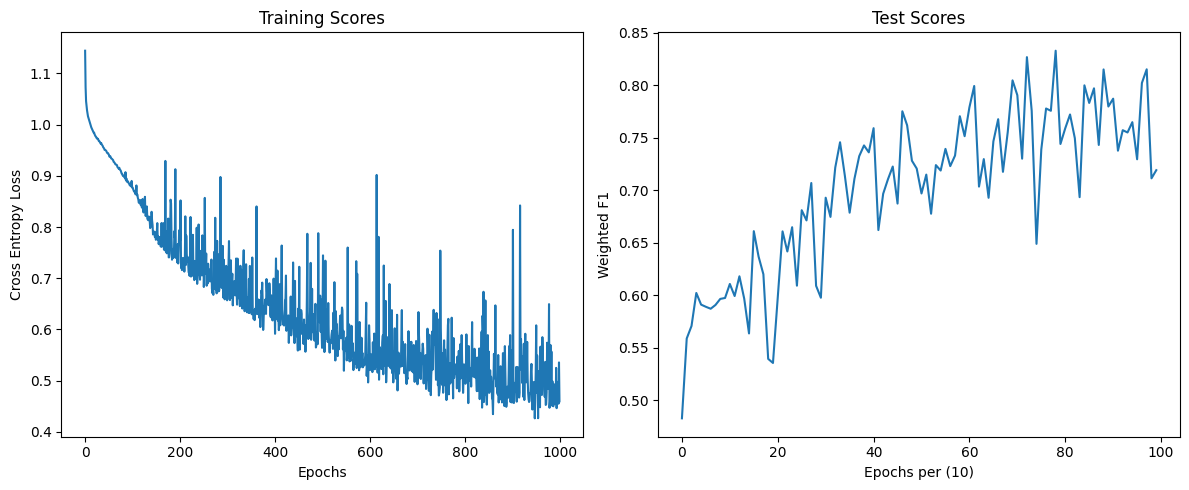

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.96310950, Test F1: 0.4505
Epoch 10, Training F1: 1.00873601, Test F1: 0.5883
Epoch 20, Training F1: 0.98437881, Test F1: 0.5913
Epoch 30, Training F1: 0.97170005, Test F1: 0.5870
Epoch 40, Training F1: 0.96132014, Test F1: 0.5892
Epoch 50, Training F1: 0.95222229, Test F1: 0.5909
Epoch 60, Training F1: 0.94417946, Test F1: 0.5865
Epoch 70, Training F1: 0.93187803, Test F1: 0.5878
Epoch 80, Training F1: 0.92480273, Test F1: 0.5938
Epoch 90, Training F1: 0.91451906, Test F1: 0.5857
Epoch 100, Training F1: 0.90461130, Test F1: 0.5967
Epoch 110, Training F1: 0.89501756, Test F1: 0.6073
Epoch 120, Training F1: 0.89514531, Test F1: 0.5902
Epoch 130, Training F1: 0.86738454, Test F1: 0.6059
Epoch 140, Training F1: 0.85377804, Test F1: 0.6241
Epoch 150, Training F1: 0.84769692, Test F1: 0.6378
Epoch 160, Training

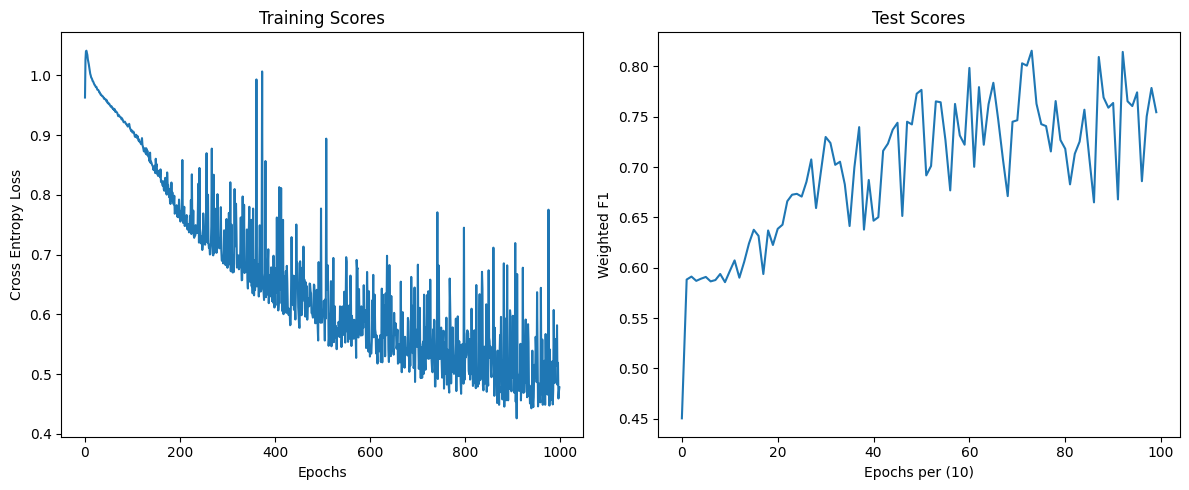

In [30]:
nn = NeuralNetwork(layers=[2, 64,32, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm1_train, sigm1_test,sigm1_final, sigm1_time, sigm1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm2_train, sigm2_test,sigm2_final, sigm2_time, sigm2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm3_train, sigm3_test,sigm3_final, sigm3_time, sigm3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="sigmoid", last_layer_activation='sigmoid')
sigm4_train, sigm4_test,sigm4_final, sigm4_time, sigm4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)


## Tanh

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 6.67790765, Test F1: 0.3775
Epoch 10, Training F1: 1.05892960, Test F1: 0.5341
Epoch 20, Training F1: 1.17509984, Test F1: 0.5326
Epoch 30, Training F1: 0.93067369, Test F1: 0.5376
Epoch 40, Training F1: 1.12798957, Test F1: 0.5340
Epoch 50, Training F1: 1.09531975, Test F1: 0.5415
Epoch 60, Training F1: 1.01089843, Test F1: 0.5418
Epoch 70, Training F1: 0.93701125, Test F1: 0.5304
Epoch 80, Training F1: 1.37708775, Test F1: 0.5497
Epoch 90, Training F1: 1.98972394, Test F1: 0.4558
Epoch 100, Training F1: 0.98758974, Test F1: 0.5411
Epoch 110, Training F1: 1.20948929, Test F1: 0.5710
Epoch 120, Training F1: 0.96594996, Test F1: 0.5365
Epoch 130, Training F1: 0.95080104, Test F1: 0.5354
Epoch 140, Training F1: 0.89170010, Test F1: 0.5407
Epoch 150, Training F1: 0.95362801, Test F1: 0.5350
Epoch 160, Training F1

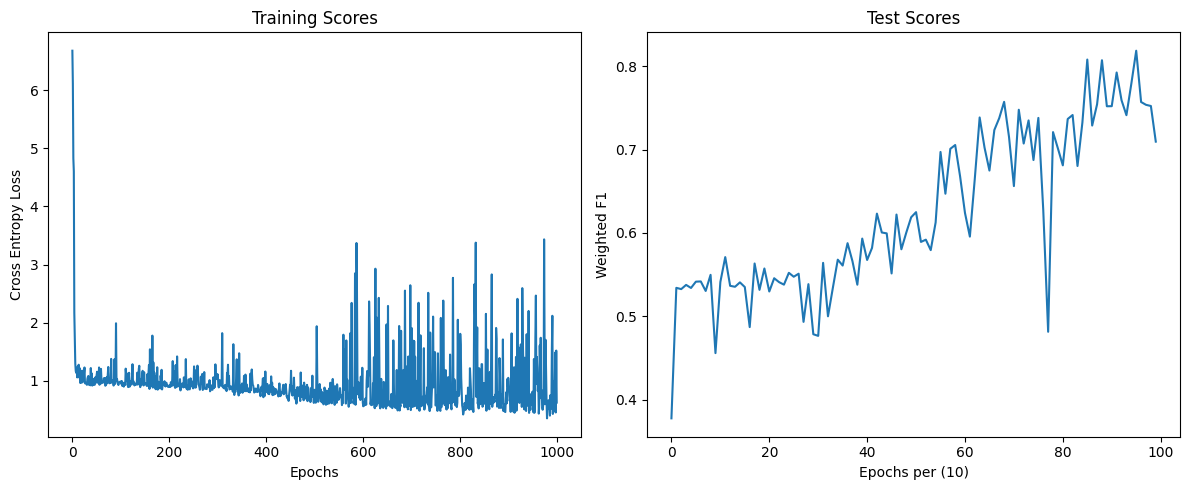

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 15.20485568, Test F1: 0.3755
Epoch 10, Training F1: 1.14201403, Test F1: 0.5485
Epoch 20, Training F1: 0.97188453, Test F1: 0.5656
Epoch 30, Training F1: 0.88930696, Test F1: 0.5884
Epoch 40, Training F1: 0.96205694, Test F1: 0.6054
Epoch 50, Training F1: 0.86264338, Test F1: 0.6160
Epoch 60, Training F1: 0.98032479, Test F1: 0.6116
Epoch 70, Training F1: 0.87024467, Test F1: 0.6118
Epoch 80, Training F1: 0.86890525, Test F1: 0.5798
Epoch 90, Training F1: 1.03051769, Test F1: 0.6016
Epoch 100, Training F1: 0.93305482, Test F1: 0.6077
Epoch 110, Training F1: 0.85820219, Test F1: 0.5748
Epoch 120, Training F1: 1.02452830, Test F1: 0.5648
Epoch 130, Training F1: 1.06275727, Test F1: 0.6127
Epoch 140, Training F1: 0.84218556, Test F1: 0.5704
Epoch 150, Training F1: 1.08046333, Test F1: 0.6135
Epoch 160, Training F

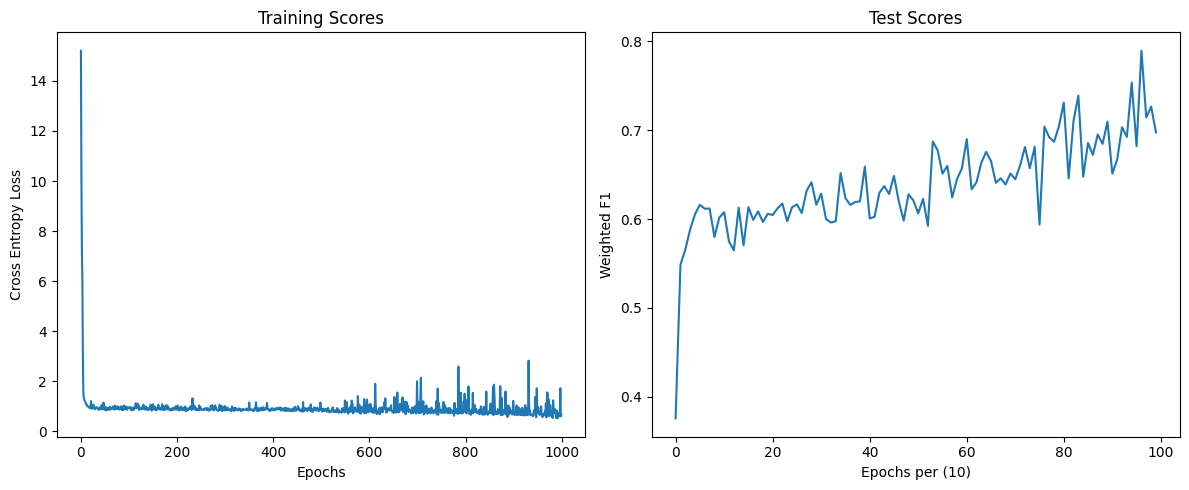

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 6.56609588, Test F1: 0.5124
Epoch 10, Training F1: 1.07457907, Test F1: 0.5661
Epoch 20, Training F1: 0.94906512, Test F1: 0.5802
Epoch 30, Training F1: 0.93186255, Test F1: 0.5658
Epoch 40, Training F1: 0.93303540, Test F1: 0.5882
Epoch 50, Training F1: 0.84190187, Test F1: 0.6117
Epoch 60, Training F1: 1.00387065, Test F1: 0.6061
Epoch 70, Training F1: 0.82261508, Test F1: 0.5547
Epoch 80, Training F1: 0.84359451, Test F1: 0.5624
Epoch 90, Training F1: 0.85076252, Test F1: 0.5910
Epoch 100, Training F1: 0.87359870, Test F1: 0.6244
Epoch 110, Training F1: 0.81355050, Test F1: 0.5655
Epoch 120, Training F1: 1.27234372, Test F1: 0.6180
Epoch 130, Training F1: 0.85287675, Test F1: 0.6254
Epoch 140, Training F1: 0.82425055, Test F1: 0.5376
Epoch 150, Training F1: 0.92033020, Test F1: 0.5949
Epoch 160, Training F1

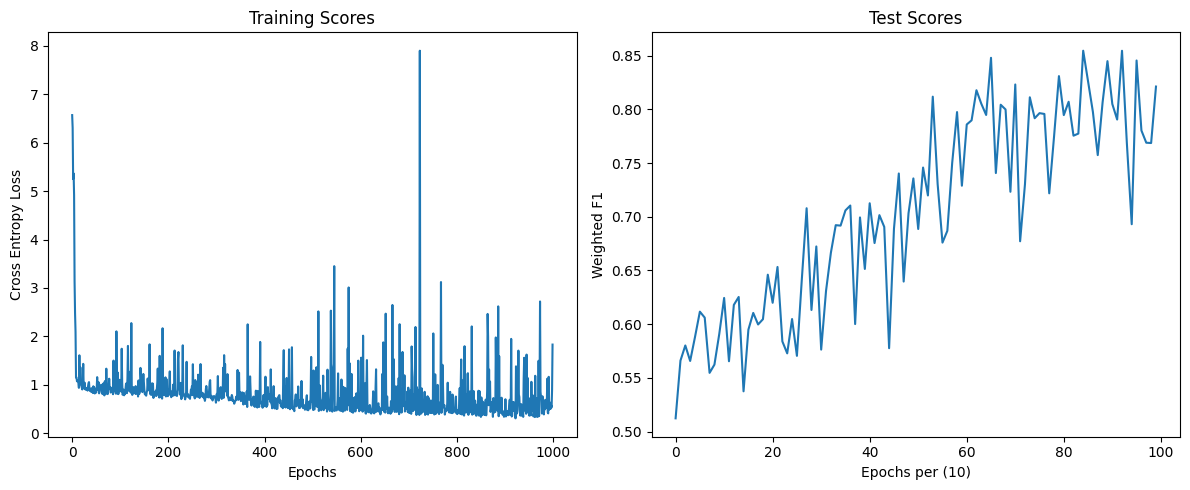

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 3.92415243, Test F1: 0.4701
Epoch 10, Training F1: 0.96864416, Test F1: 0.4526
Epoch 20, Training F1: 0.89903268, Test F1: 0.5040
Epoch 30, Training F1: 0.90780516, Test F1: 0.5643
Epoch 40, Training F1: 1.01337578, Test F1: 0.5377
Epoch 50, Training F1: 1.04008674, Test F1: 0.6111
Epoch 60, Training F1: 0.91242919, Test F1: 0.5799
Epoch 70, Training F1: 0.97504929, Test F1: 0.6121
Epoch 80, Training F1: 1.25950517, Test F1: 0.5926
Epoch 90, Training F1: 0.95015724, Test F1: 0.5888
Epoch 100, Training F1: 0.95662649, Test F1: 0.5999
Epoch 110, Training F1: 0.94983436, Test F1: 0.5684
Epoch 120, Training F1: 0.85607985, Test F1: 0.5575
Epoch 130, Training F1: 1.24332010, Test F1: 0.6072
Epoch 140, Training F1: 0.89354151, Test F1: 0.5824
Epoch 150, Training F1: 0.83005183, Test F1: 0.5959
Epoch 160, Training F1

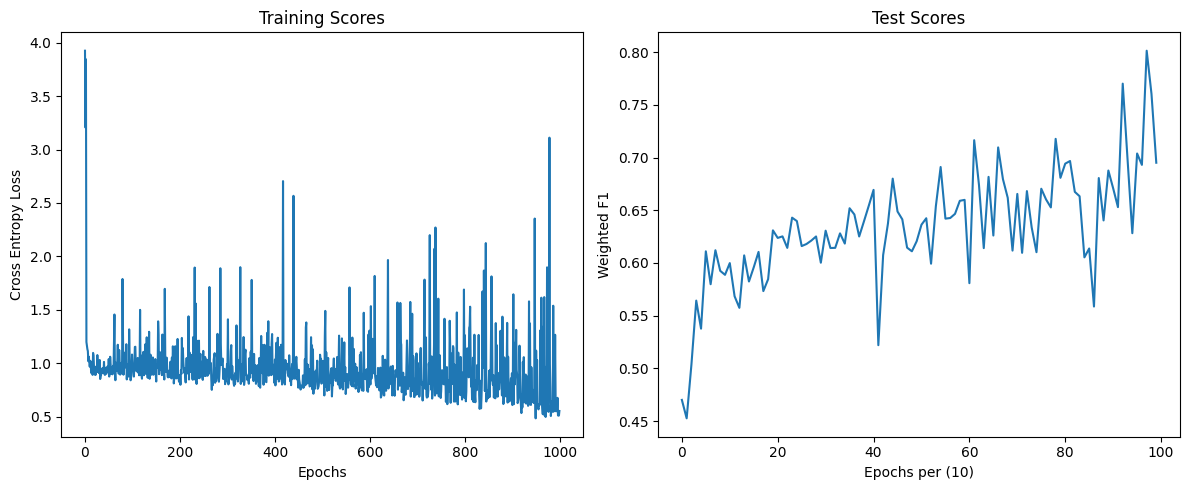

In [31]:
nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='tanh')
tanh1_train, tanh1_test,tanh1_final, tanh1_time, tanh1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='tanh')
tanh2_train, tanh2_test,tanh2_final, tanh2_time, tanh2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='tanh')
tanh3_train, tanh3_test,tanh3_final, tanh3_time, tanh3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="relu", last_layer_activation='tanh')
tanh4_train, tanh4_test,tanh4_final, tanh4_time, tanh4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)




## Relu

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 13.41659013, Test F1: 0.5009
Epoch 10, Training F1: 1.73074548, Test F1: 0.5648
Epoch 20, Training F1: 1.18279553, Test F1: 0.5842
Epoch 30, Training F1: 1.12198902, Test F1: 0.6072
Epoch 40, Training F1: 1.19504916, Test F1: 0.6240
Epoch 50, Training F1: 1.16449033, Test F1: 0.6323
Epoch 60, Training F1: 1.22293242, Test F1: 0.6205
Epoch 70, Training F1: 1.09930005, Test F1: 0.6028
Epoch 80, Training F1: 0.76969683, Test F1: 0.6234
Epoch 90, Training F1: 1.06064780, Test F1: 0.6450
Epoch 100, Training F1: 0.90755863, Test F1: 0.6531
Epoch 110, Training F1: 0.82176343, Test F1: 0.6456
Epoch 120, Training F1: 0.79816581, Test F1: 0.6942
Epoch 130, Training F1: 0.67619198, Test F1: 0.6958
Epoch 140, Training F1: 1.75118356, Test F1: 0.6129
Epoch 150, Training F1: 0.82081339, Test F1: 0.6588
Epoch 160, Training F

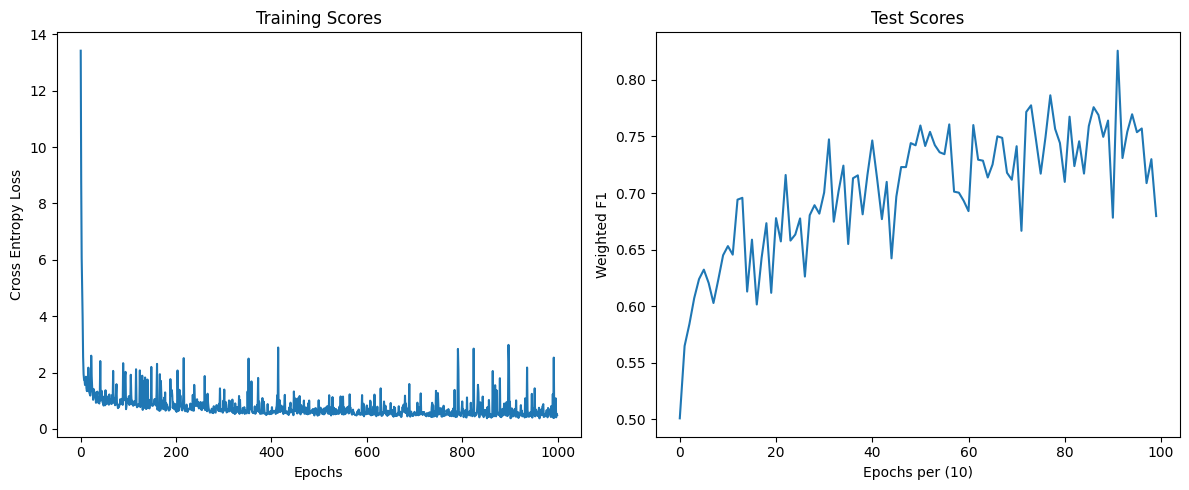

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 3.66810395, Test F1: 0.5268
Epoch 10, Training F1: 1.36967731, Test F1: 0.5573
Epoch 20, Training F1: 0.96698152, Test F1: 0.5767
Epoch 30, Training F1: 0.87378084, Test F1: 0.5909
Epoch 40, Training F1: 0.84813289, Test F1: 0.6055
Epoch 50, Training F1: 0.82958190, Test F1: 0.6209
Epoch 60, Training F1: 1.07825055, Test F1: 0.5572
Epoch 70, Training F1: 0.91507633, Test F1: 0.6068
Epoch 80, Training F1: 0.88252230, Test F1: 0.6164
Epoch 90, Training F1: 0.74957697, Test F1: 0.6246
Epoch 100, Training F1: 0.72006488, Test F1: 0.6301
Epoch 110, Training F1: 0.83065704, Test F1: 0.6254
Epoch 120, Training F1: 0.79765333, Test F1: 0.6667
Epoch 130, Training F1: 0.81412519, Test F1: 0.6816
Epoch 140, Training F1: 1.11946943, Test F1: 0.6254
Epoch 150, Training F1: 0.84024772, Test F1: 0.6695
Epoch 160, Training F1

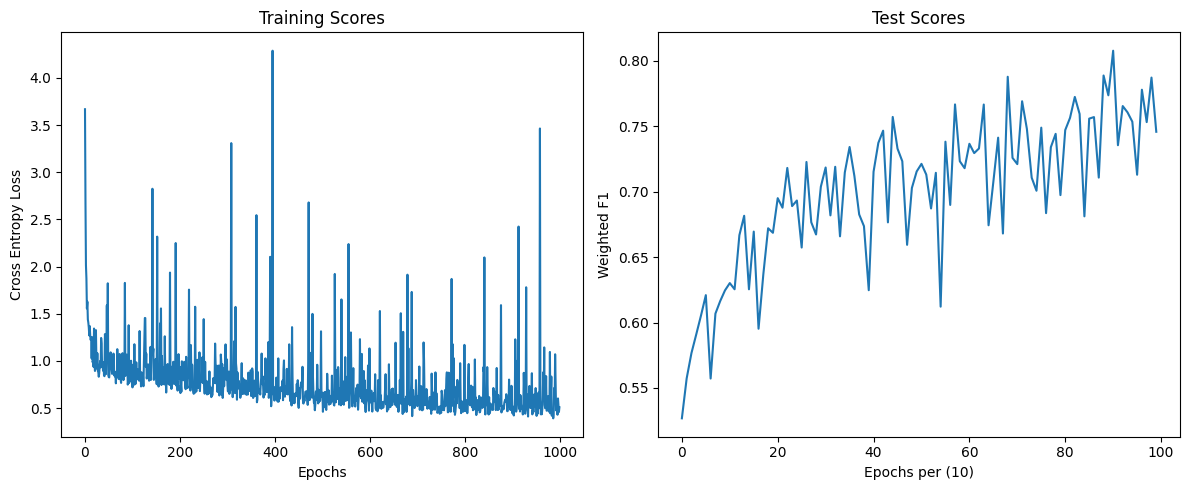

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 7.91497021, Test F1: 0.4819
Epoch 10, Training F1: 1.24382285, Test F1: 0.5732
Epoch 20, Training F1: 1.11022545, Test F1: 0.5943
Epoch 30, Training F1: 0.85746567, Test F1: 0.6053
Epoch 40, Training F1: 1.38191819, Test F1: 0.5773
Epoch 50, Training F1: 1.09133124, Test F1: 0.6344
Epoch 60, Training F1: 0.96113836, Test F1: 0.6384
Epoch 70, Training F1: 0.91421163, Test F1: 0.7056
Epoch 80, Training F1: 1.20700393, Test F1: 0.6606
Epoch 90, Training F1: 0.72786708, Test F1: 0.6872
Epoch 100, Training F1: 1.01663197, Test F1: 0.6639
Epoch 110, Training F1: 1.71242970, Test F1: 0.6275
Epoch 120, Training F1: 0.71317864, Test F1: 0.6749
Epoch 130, Training F1: 0.94611502, Test F1: 0.6178
Epoch 140, Training F1: 1.23356592, Test F1: 0.5897
Epoch 150, Training F1: 0.75848097, Test F1: 0.6662
Epoch 160, Training F1

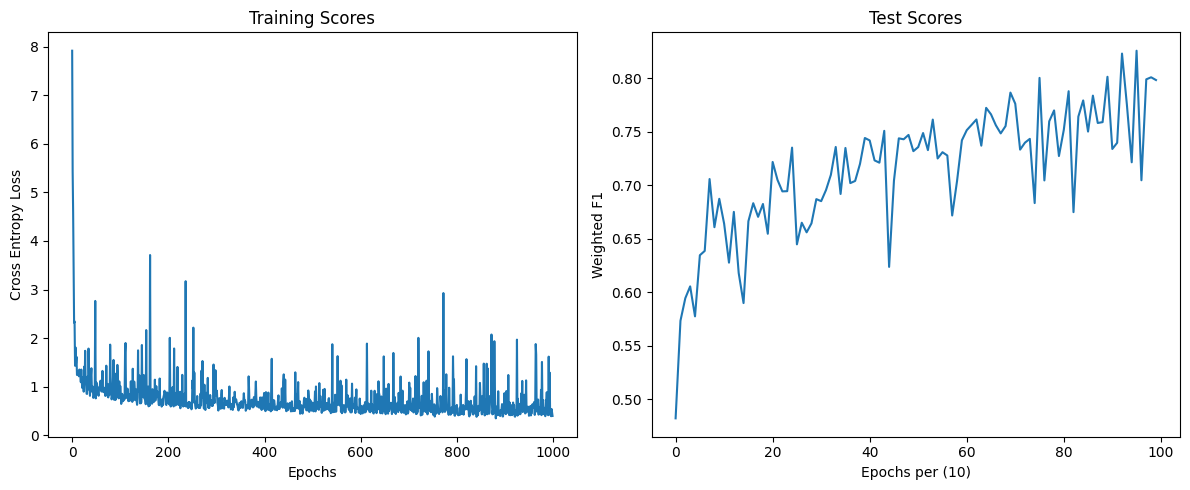

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 7.25465517, Test F1: 0.4991
Epoch 10, Training F1: 1.48398931, Test F1: 0.5899
Epoch 20, Training F1: 1.14713161, Test F1: 0.5987
Epoch 30, Training F1: 0.90051346, Test F1: 0.6128
Epoch 40, Training F1: 0.87340698, Test F1: 0.6488
Epoch 50, Training F1: 0.93988775, Test F1: 0.6541
Epoch 60, Training F1: 1.12504256, Test F1: 0.5904
Epoch 70, Training F1: 1.19765215, Test F1: 0.6202
Epoch 80, Training F1: 0.88665867, Test F1: 0.6846
Epoch 90, Training F1: 0.97030513, Test F1: 0.6848
Epoch 100, Training F1: 0.76478984, Test F1: 0.6981
Epoch 110, Training F1: 0.90081107, Test F1: 0.6959
Epoch 120, Training F1: 0.80312914, Test F1: 0.6334
Epoch 130, Training F1: 0.71243005, Test F1: 0.6804
Epoch 140, Training F1: 0.72046990, Test F1: 0.6979
Epoch 150, Training F1: 0.70528065, Test F1: 0.6771
Epoch 160, Training F1

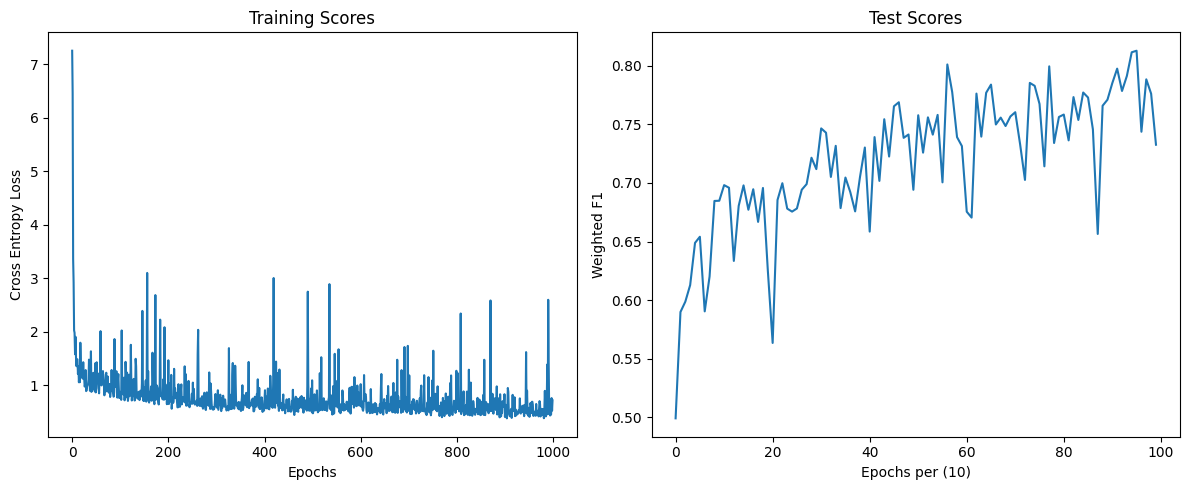

In [32]:
nn = NeuralNetwork(layers=[2, 64,32, 3], activation="tanh", last_layer_activation='relu')
relu1_train, relu1_test,relu1_final, relu1_time, relu1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="tanh", last_layer_activation='relu')
relu2_train, relu2_test,relu2_final, relu2_time, relu2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="tanh", last_layer_activation='relu')
relu3_train, relu3_test,relu3_final, relu3_time, relu3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)

nn = NeuralNetwork(layers=[2, 64,32, 3], activation="tanh", last_layer_activation='relu')
relu4_train, relu4_test,relu4_final, relu4_time, relu4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=1000, report_frequency=10, loss_threshold=1.9)




## Comparison

Text(0.5, 1.0, 'Final F1 for each attempt')

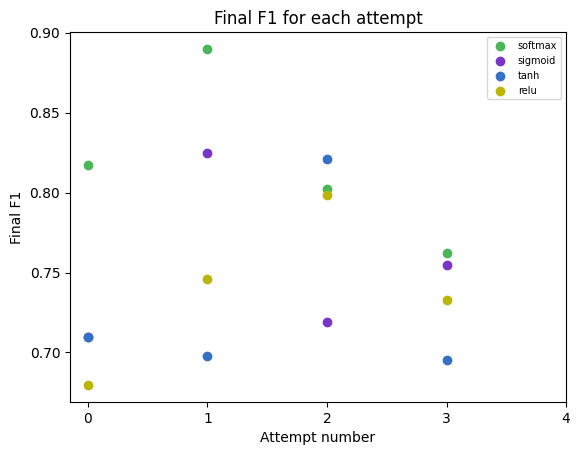

In [33]:
soft_final = [soft1_final, soft2_final, soft3_final, soft4_final]
sigm_final = [ sigm1_final, sigm2_final, sigm3_final, sigm4_final]
tanh_final = [tanh1_final, tanh2_final, tanh3_final, tanh4_final]
relu_final = [relu1_final, relu2_final, relu3_final, relu4_final]

plt.scatter(np.arange(len(soft_final)),soft_final, color='#4ab659', label='softmax')
plt.scatter(np.arange(len(sigm_final)),sigm_final, color='#7835c6', label='sigmoid')
plt.scatter(np.arange(len(tanh_final)),tanh_final, color='#3570c6', label='tanh')
plt.scatter(np.arange(len(relu_final)),relu_final, color='#bbb604', label='relu')
plt.xticks([0,1,2,3,4])
plt.xlabel('Attempt number')
plt.ylabel('Final F1')
plt.legend(loc='upper right', fontsize = 7)
plt.title('Final F1 for each attempt')

# Easy df

In [26]:
train_df = pd.read_csv('data/easy-training.csv')
test_df = pd.read_csv('data/easy-test.csv')

print(f"Number of classes {train_df['c'].nunique()}")

Number of classes 2


In [27]:
X_train = train_df[['x', 'y']].to_numpy()
Y_train = train_df['c'].to_numpy().reshape(-1,1)  
X_test = test_df[['x', 'y']].to_numpy()
Y_test = test_df['c'].to_numpy().reshape(-1,1)  

# # Kodowanie one-hot dla Y
y_encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = y_encoder.fit_transform(Y_train)  
Y_test_encoded = y_encoder.transform(Y_test) 

print(Y_train_encoded.shape)

(500, 2)


## Softmax activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.26041435, Test F1: 0.9175
Epoch 10, Training F1: 0.04890990, Test F1: 0.9920
F1 SCORE ACHIEVED : 0.991998975737789 stopping at epoch 10
Training Duration: 0.028184175491333008


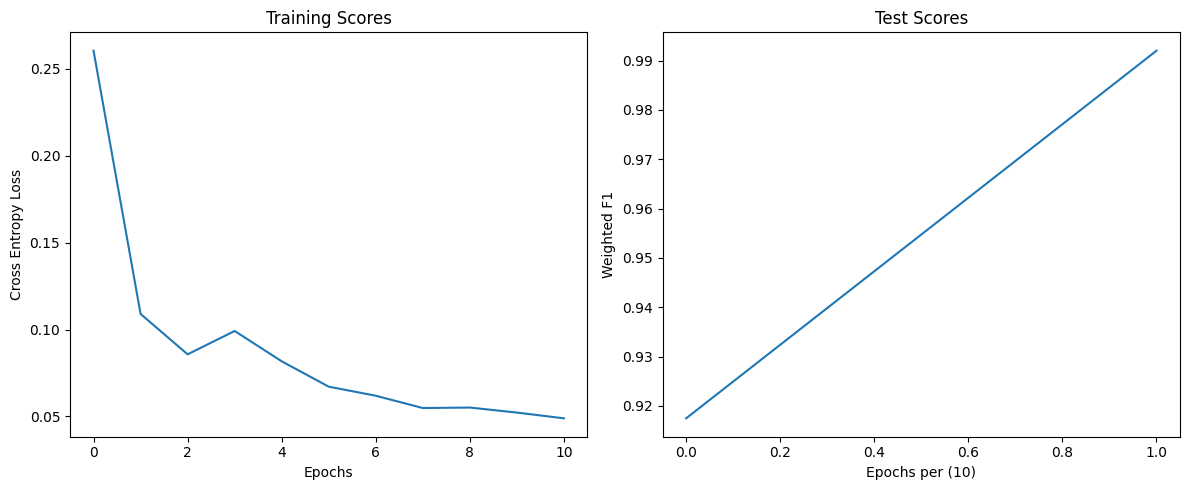

In [25]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="relu", last_layer_activation='softmax')
soft_train,soft_tes = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, report_frequency=10, loss_threshold=0.99)

## Tanh activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 3.18709879, Test F1: 0.8139
Epoch 10, Training F1: 0.20478470, Test F1: 0.9880
Epoch 20, Training F1: 0.12579398, Test F1: 0.9900
Epoch 30, Training F1: 0.26663826, Test F1: 0.9760
Epoch 40, Training F1: 0.19211138, Test F1: 0.9660
Epoch 50, Training F1: 0.06149278, Test F1: 0.9920
F1 SCORE ACHIEVED : 0.991998975737789 stopping at epoch 50
Training Duration: 0.08852291107177734


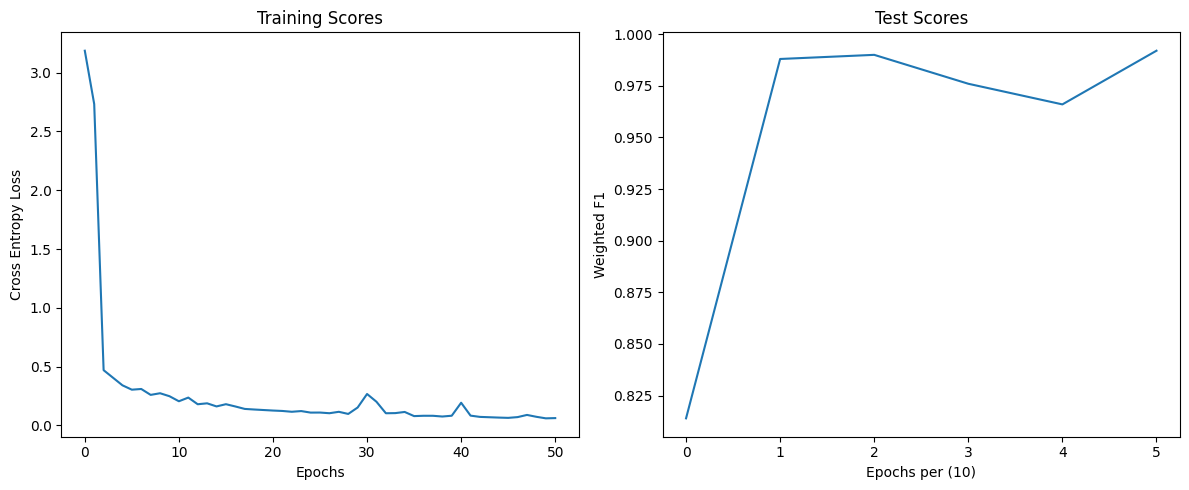

In [26]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='tanh')
tanh_train, tanh_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Sigmoid activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.84471120, Test F1: 0.3899
Epoch 10, Training F1: 0.44287593, Test F1: 0.9840
Epoch 20, Training F1: 0.22768631, Test F1: 0.9800
Epoch 30, Training F1: 0.13153605, Test F1: 0.9940
F1 SCORE ACHIEVED : 0.9939998799879989 stopping at epoch 30
Training Duration: 0.06879568099975586


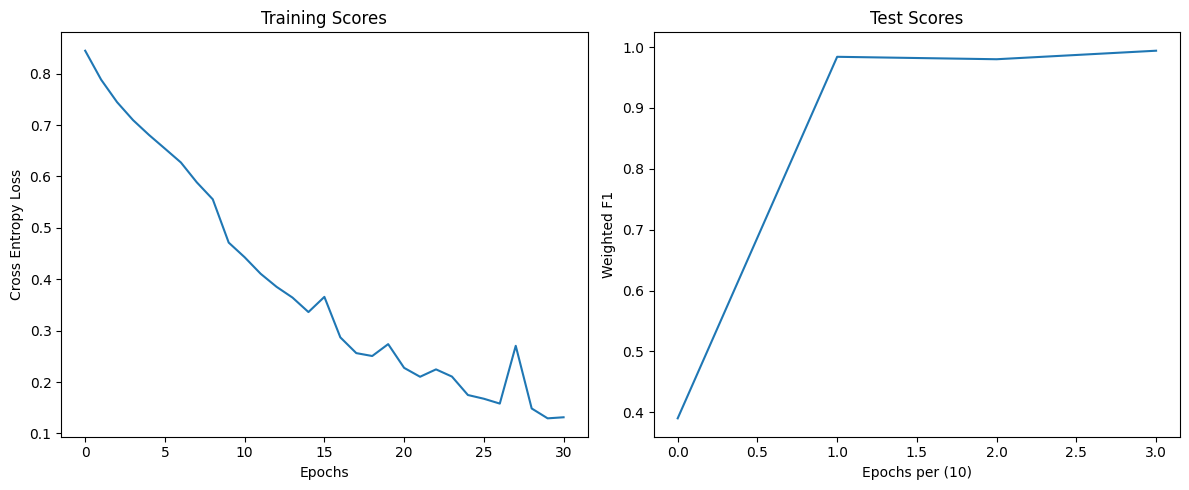

In [27]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='sigmoid')
sigmoid_train, sigmoid_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Relu activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 22.43637180, Test F1: 0.5160
Epoch 10, Training F1: 0.22856961, Test F1: 0.9980
F1 SCORE ACHIEVED : 0.998000024000864 stopping at epoch 10
Training Duration: 0.029500246047973633


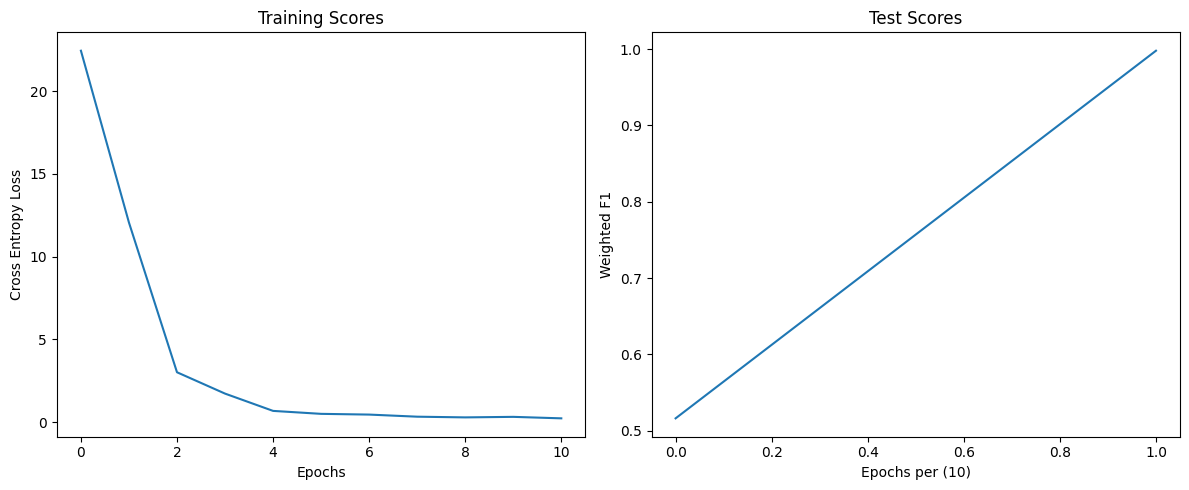

In [28]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='relu')
relu_train, relu_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Comparison

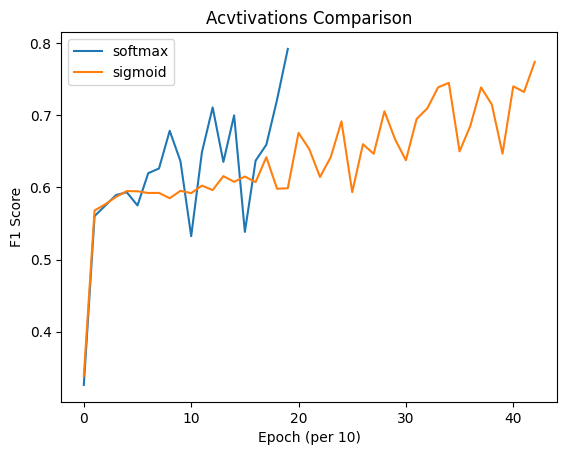

In [30]:
plt.plot(soft_test, label='softmax')
#plt.plot(relu_test, label='relu')
plt.plot(sigm_test, label='sigmoid')
#plt.plot(tanh_test, label='tanh')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

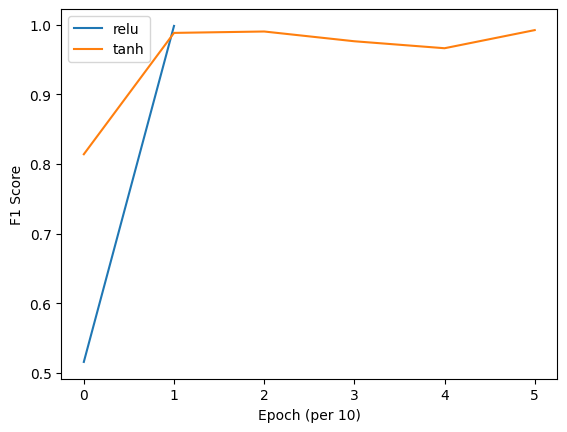

In [31]:
#plt.plot(soft_test, label='softmax')
plt.plot(relu_test, label='relu')
#plt.plot(sigm_test, label='sigmoid')
plt.plot(tanh_test, label='tanh')
#plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

## Softmax 2

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.68564817, Test F1: 0.3639
Epoch 10, Training F1: 0.16310516, Test F1: 0.9940
F1 SCORE ACHIEVED : 0.9939994959011966 stopping at epoch 10
Training Duration: 0.019298076629638672


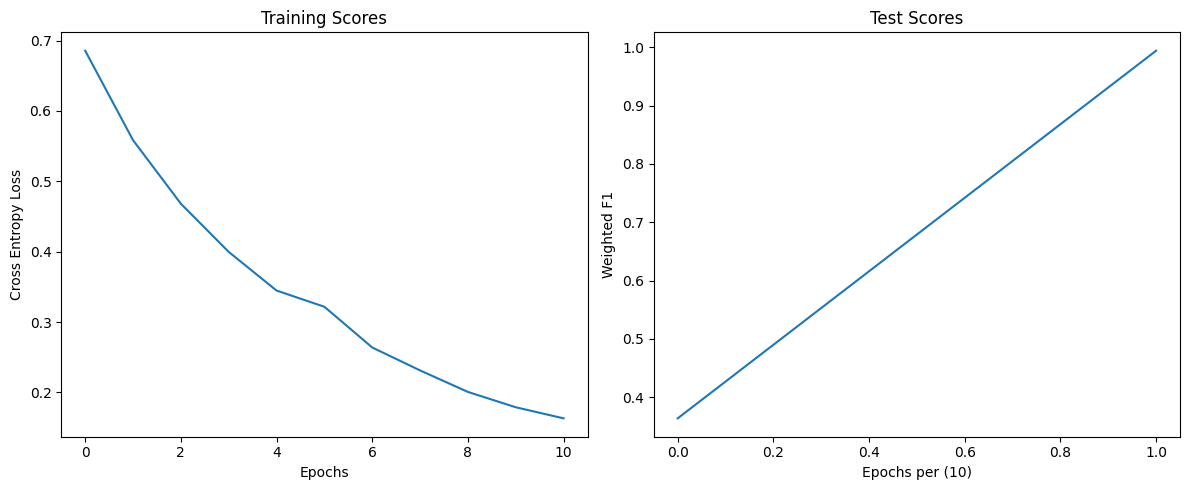

In [14]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='softmax')
soft_train, soft_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Sigmoid 2

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.68389009, Test F1: 0.9599
Epoch 10, Training F1: 0.39571974, Test F1: 0.9980
F1 SCORE ACHIEVED : 0.998000024000864 stopping at epoch 10
Training Duration: 0.016405582427978516


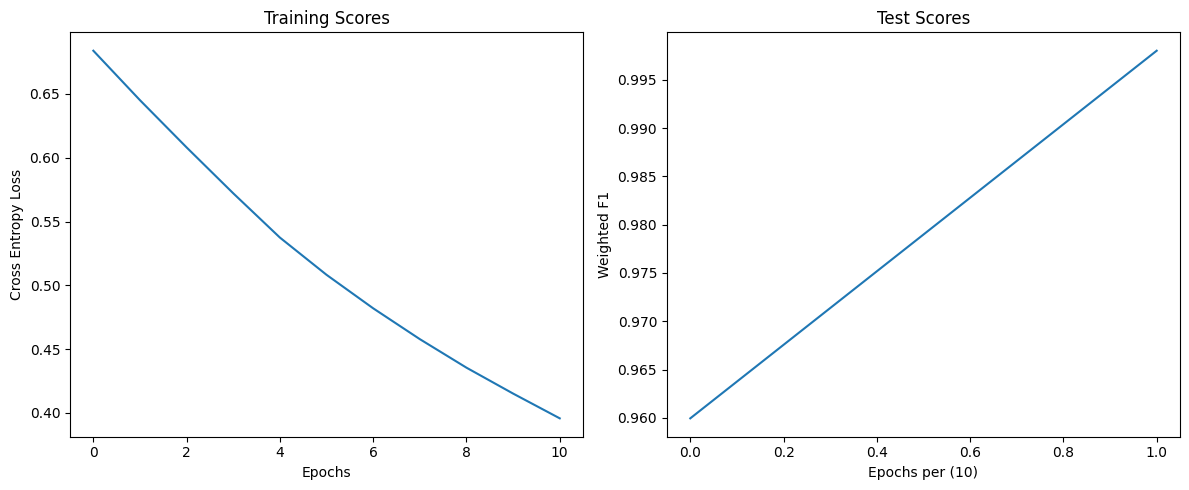

In [15]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm_train, sigm_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Tanh 2

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 9.93332016, Test F1: 0.9240
Epoch 10, Training F1: 0.34359186, Test F1: 0.9920
F1 SCORE ACHIEVED : 0.9920001280020481 stopping at epoch 10
Training Duration: 0.017125606536865234


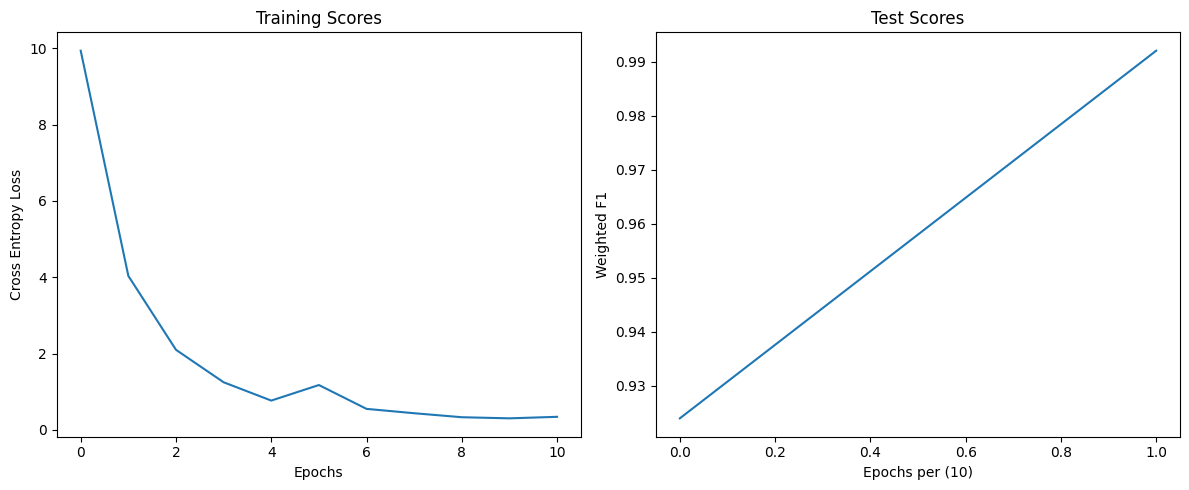

In [16]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='tanh')
tanh_train, tanh_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Relu 2

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 1.53892512, Test F1: 0.9780
Epoch 10, Training F1: 3.17218480, Test F1: 0.9460
Epoch 20, Training F1: 0.04890593, Test F1: 1.0000
F1 SCORE ACHIEVED : 1.0 stopping at epoch 20
Training Duration: 0.026203632354736328


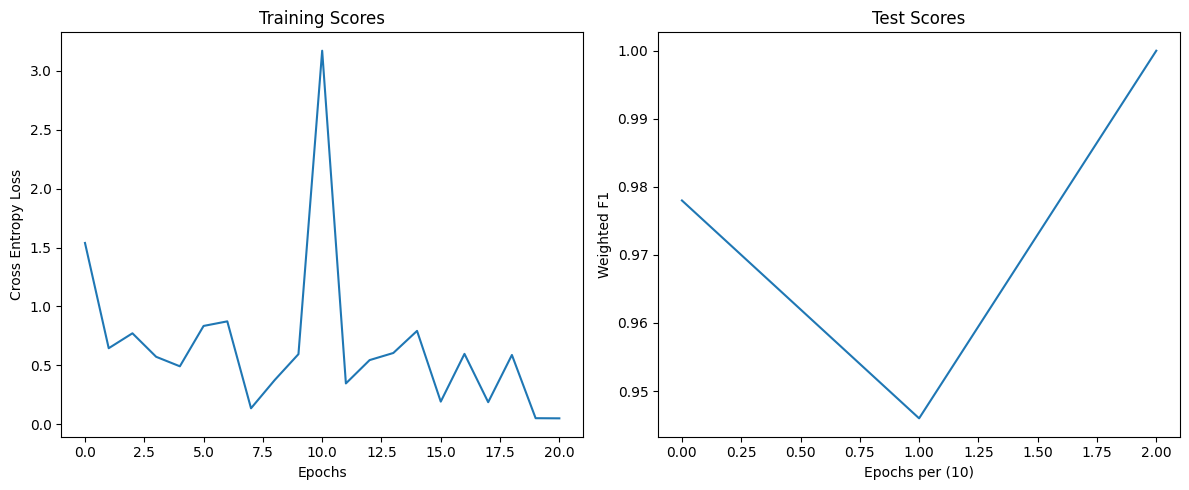

In [17]:
nn = NeuralNetwork(layers=[2, 5, 2], activation="tanh", last_layer_activation='relu')
relu_train, relu_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Comparison 2

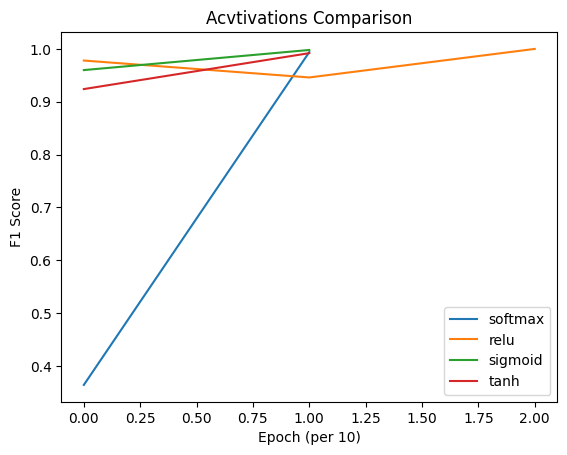

In [18]:
plt.plot(soft_test, label='softmax')
plt.plot(relu_test, label='relu')
plt.plot(sigm_test, label='sigmoid')
plt.plot(tanh_test, label='tanh')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

## Try 2 - [2]

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.37409242, Test F1: 0.7263
Epoch 10, Training F1: 0.05580685, Test F1: 0.9960
F1 SCORE ACHIEVED : 0.996 stopping at epoch 10
Training Duration: 0.029700279235839844


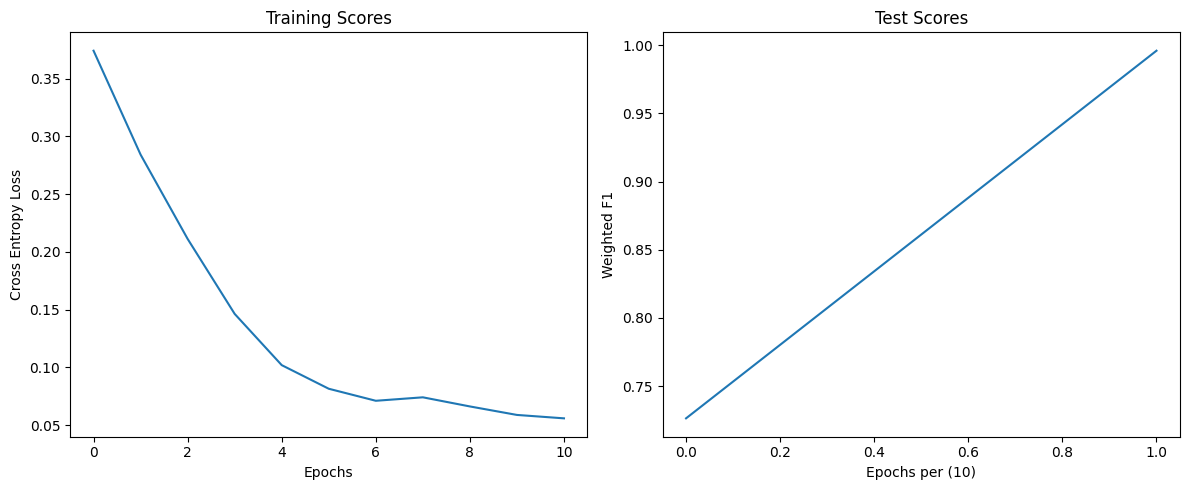

In [13]:
#softmax
nn = NeuralNetwork(layers=[2, 2, 2], activation="relu", last_layer_activation='softmax')
soft_train, soft_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.69388797, Test F1: 0.3289
Epoch 10, Training F1: 0.53199283, Test F1: 0.9820
Epoch 20, Training F1: 0.42637752, Test F1: 0.9980
F1 SCORE ACHIEVED : 0.998000024000864 stopping at epoch 20
Training Duration: 0.04426765441894531


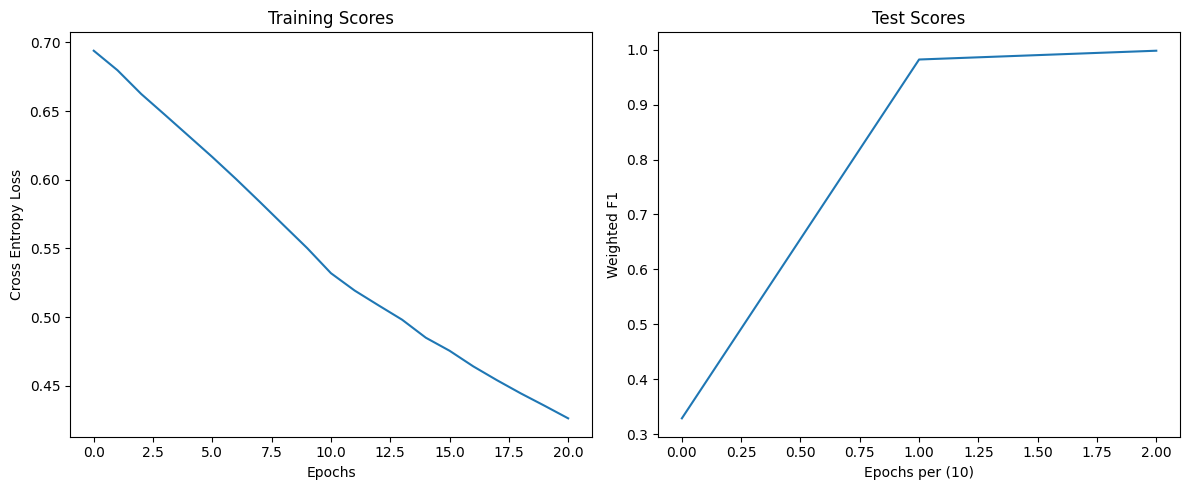

In [14]:
#sigmoid
nn = NeuralNetwork(layers=[2, 2, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm_train, sigm_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 15.33513121, Test F1: 0.5532
Epoch 10, Training F1: 0.62665369, Test F1: 0.8859
Epoch 20, Training F1: 0.22893878, Test F1: 0.9920
F1 SCORE ACHIEVED : 0.9920001280020481 stopping at epoch 20
Training Duration: 0.04614973068237305


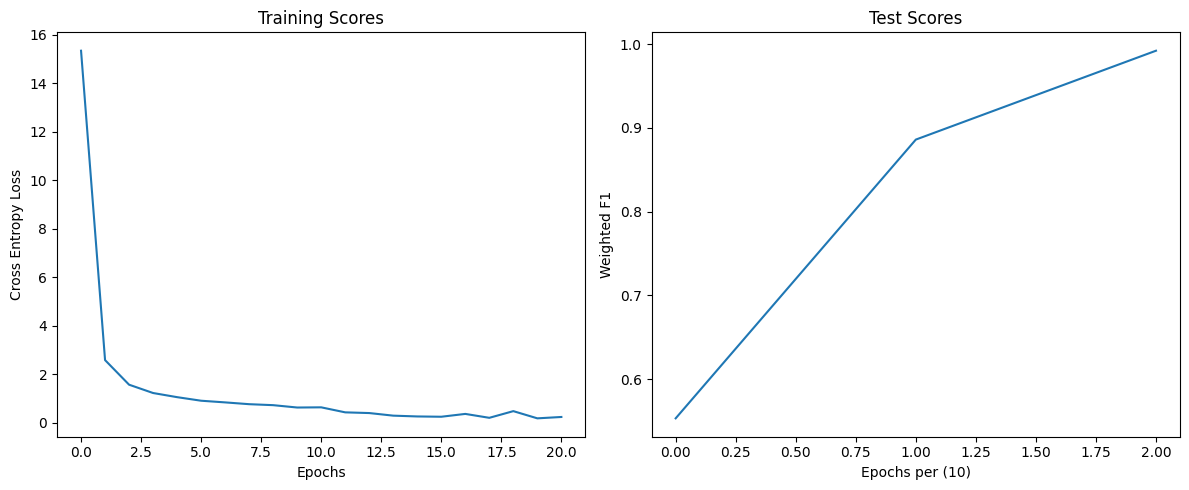

In [15]:
#tanh
nn = NeuralNetwork(layers=[2, 2, 2], activation="tanh", last_layer_activation='tanh')
tanh_train, tanh_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 1.43626089, Test F1: 0.9760
Epoch 10, Training F1: 2.15052281, Test F1: 0.9340
Epoch 20, Training F1: 0.31376864, Test F1: 0.9820
Epoch 30, Training F1: 2.01465467, Test F1: 0.9460
Epoch 40, Training F1: 0.03741201, Test F1: 0.9980
F1 SCORE ACHIEVED : 0.998000024000864 stopping at epoch 40
Training Duration: 0.0562748908996582


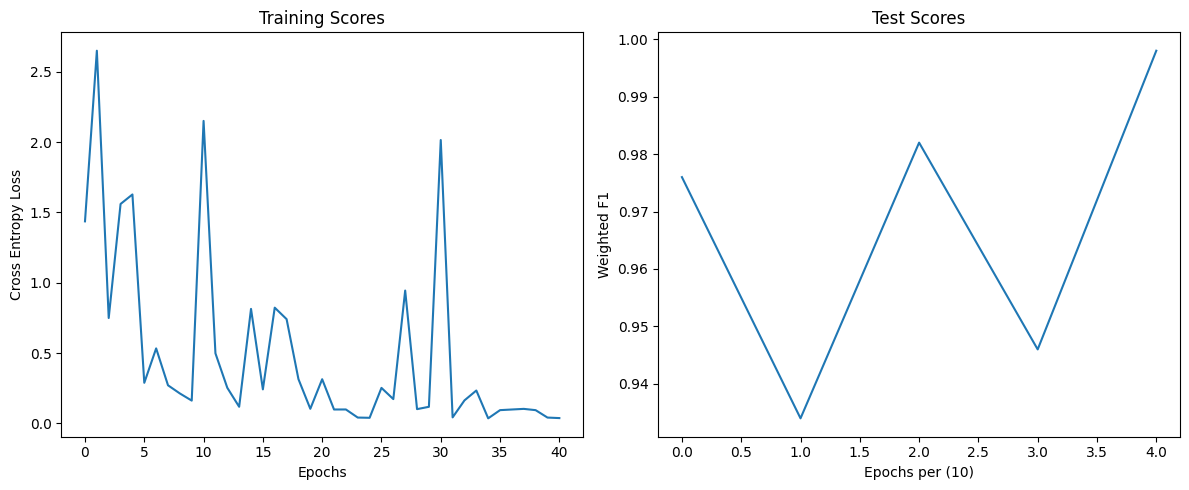

In [16]:
#relu
nn = NeuralNetwork(layers=[2, 2, 2], activation="tanh", last_layer_activation='relu')
relu_train, relu_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=10000, loss_threshold=0.99)

## Comparison 3

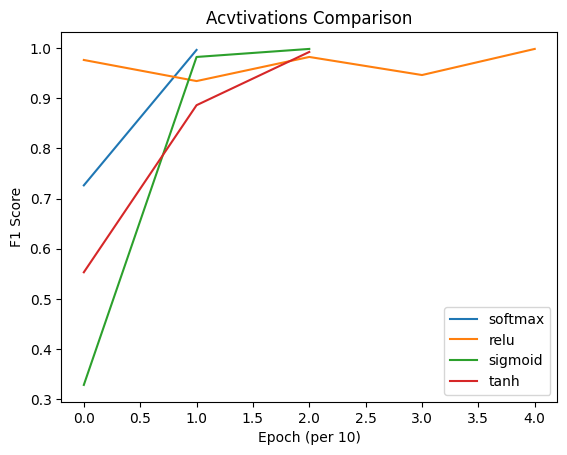

In [17]:
plt.plot(soft_test, label='softmax')
plt.plot(relu_test, label='relu')
plt.plot(sigm_test, label='sigmoid')
plt.plot(tanh_test, label='tanh')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

## Try 3 - without stopping

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.62508746, Test F1: 0.6596
Epoch 10, Training F1: 0.20602375, Test F1: 0.9720
Epoch 20, Training F1: 0.14931235, Test F1: 0.9780
Epoch 30, Training F1: 0.09578439, Test F1: 0.9840
Epoch 40, Training F1: 0.05219191, Test F1: 0.9880
Epoch 50, Training F1: 0.03289991, Test F1: 0.9920
Epoch 60, Training F1: 0.03286036, Test F1: 0.9920
Epoch 70, Training F1: 0.02605116, Test F1: 0.9940
Epoch 80, Training F1: 0.02365260, Test F1: 0.9940
Epoch 90, Training F1: 0.02443563, Test F1: 0.9940
Epoch 100, Training F1: 0.01529928, Test F1: 0.9960
Epoch 110, Training F1: 0.01865708, Test F1: 0.9920
Epoch 120, Training F1: 0.01282970, Test F1: 1.0000
Epoch 130, Training F1: 0.02500533, Test F1: 0.9920
Epoch 140, Training F1: 0.01357800, Test F1: 0.9920
Epoch 150, Training F1: 0.01216565, Test F1: 1.0000
Epoch 160, Training

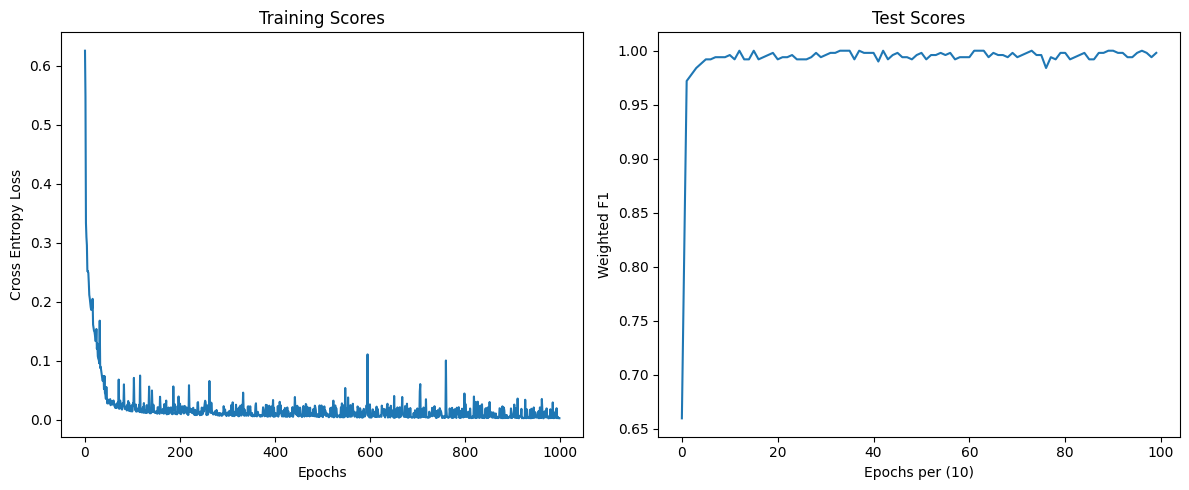

In [29]:
#softmax
nn = NeuralNetwork(layers=[2, 2, 2], activation="relu", last_layer_activation='softmax')
soft_train, soft_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=1000, loss_threshold=1.5)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.71758884, Test F1: 0.3378
Epoch 10, Training F1: 0.61903026, Test F1: 0.7822
Epoch 20, Training F1: 0.55604533, Test F1: 0.8506
Epoch 30, Training F1: 0.50055698, Test F1: 0.8865
Epoch 40, Training F1: 0.44512588, Test F1: 0.9800
Epoch 50, Training F1: 0.38182513, Test F1: 0.9820
Epoch 60, Training F1: 0.33701925, Test F1: 0.9880
Epoch 70, Training F1: 0.30335409, Test F1: 0.9900
Epoch 80, Training F1: 0.27326746, Test F1: 0.9900
Epoch 90, Training F1: 0.25024661, Test F1: 0.9900
Epoch 100, Training F1: 0.22849918, Test F1: 0.9920
Epoch 110, Training F1: 0.21095189, Test F1: 0.9880
Epoch 120, Training F1: 0.19881727, Test F1: 0.9900
Epoch 130, Training F1: 0.18379689, Test F1: 0.9900
Epoch 140, Training F1: 0.16792216, Test F1: 0.9980
Epoch 150, Training F1: 0.16271078, Test F1: 0.9940
Epoch 160, Training

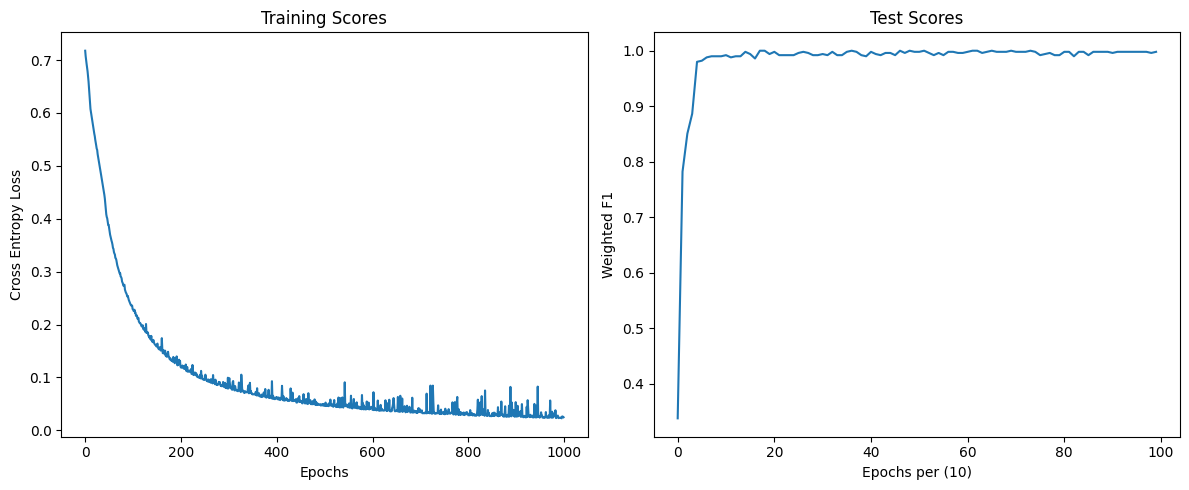

In [31]:
# sigmoid
nn = NeuralNetwork(layers=[2, 2, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm_train, sigm_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=1000, loss_threshold=1.5)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 5.58958639, Test F1: 0.8854
Epoch 10, Training F1: 0.26154333, Test F1: 0.9980
Epoch 20, Training F1: 0.15132227, Test F1: 0.9880
Epoch 30, Training F1: 0.11655306, Test F1: 0.9860
Epoch 40, Training F1: 0.07171931, Test F1: 0.9980
Epoch 50, Training F1: 0.06196220, Test F1: 0.9920
Epoch 60, Training F1: 0.04856605, Test F1: 1.0000
Epoch 70, Training F1: 0.04840377, Test F1: 0.9900
Epoch 80, Training F1: 0.03766528, Test F1: 1.0000
Epoch 90, Training F1: 0.03288521, Test F1: 0.9980
Epoch 100, Training F1: 0.03008418, Test F1: 0.9980
Epoch 110, Training F1: 0.03290453, Test F1: 0.9860
Epoch 120, Training F1: 0.02861917, Test F1: 0.9960
Epoch 130, Training F1: 0.12143238, Test F1: 0.9800
Epoch 140, Training F1: 0.03713585, Test F1: 0.9920
Epoch 150, Training F1: 0.05819744, Test F1: 0.9860
Epoch 160, Training F1

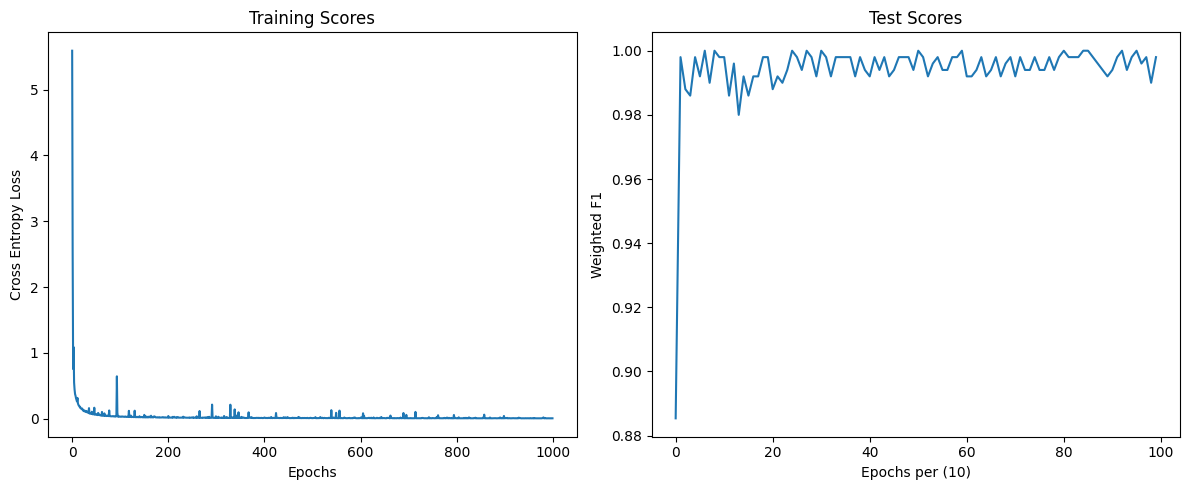

In [33]:
#tanh
nn = NeuralNetwork(layers=[2, 2, 2], activation="tanh", last_layer_activation='tanh')
tanh_train, tanh_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=1000, loss_threshold=1.5)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 6.78587054, Test F1: 0.6479
Epoch 10, Training F1: 0.16377961, Test F1: 0.9820
Epoch 20, Training F1: 0.05717414, Test F1: 0.9940
Epoch 30, Training F1: 0.05383018, Test F1: 0.9900
Epoch 40, Training F1: 0.04532497, Test F1: 0.9900
Epoch 50, Training F1: 0.06413904, Test F1: 0.9820
Epoch 60, Training F1: 0.02216715, Test F1: 0.9980
Epoch 70, Training F1: 0.03224821, Test F1: 0.9920
Epoch 80, Training F1: 0.05957952, Test F1: 0.9880
Epoch 90, Training F1: 0.09511128, Test F1: 0.9900
Epoch 100, Training F1: 0.01749751, Test F1: 0.9980
Epoch 110, Training F1: 0.02098050, Test F1: 0.9960
Epoch 120, Training F1: 0.11713255, Test F1: 0.9820
Epoch 130, Training F1: 0.01737877, Test F1: 0.9980
Epoch 140, Training F1: 0.01661422, Test F1: 0.9960
Epoch 150, Training F1: 0.02183529, Test F1: 0.9960
Epoch 160, Training F1

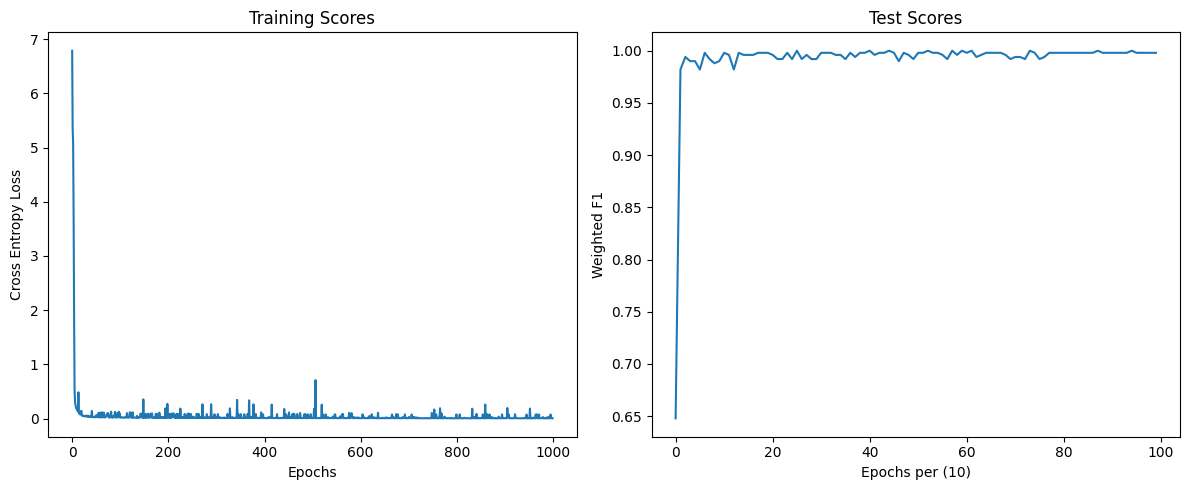

In [34]:
#relu
nn = NeuralNetwork(layers=[2, 2, 2], activation="tanh", last_layer_activation='relu')
relu_train, relu_test = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency=10, epochs=1000, loss_threshold=1.5)

## Comparison

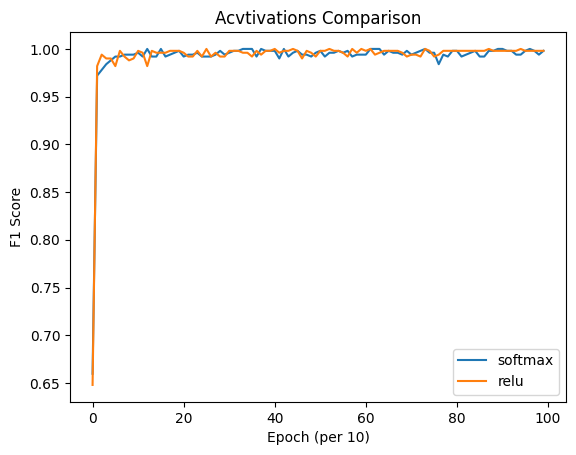

In [36]:
plt.plot(soft_test, label='softmax')
plt.plot(relu_test, label='relu')
#plt.plot(sigm_test, label='sigmoid')
#plt.plot(tanh_test, label='tanh')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

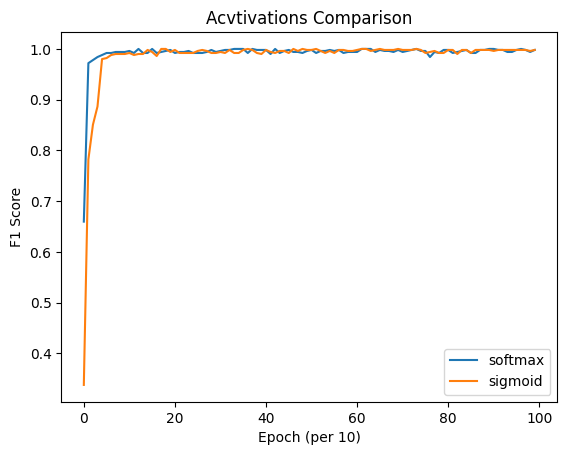

In [37]:
plt.plot(soft_test, label='softmax')
#plt.plot(relu_test, label='relu')
plt.plot(sigm_test, label='sigmoid')
#plt.plot(tanh_test, label='tanh')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

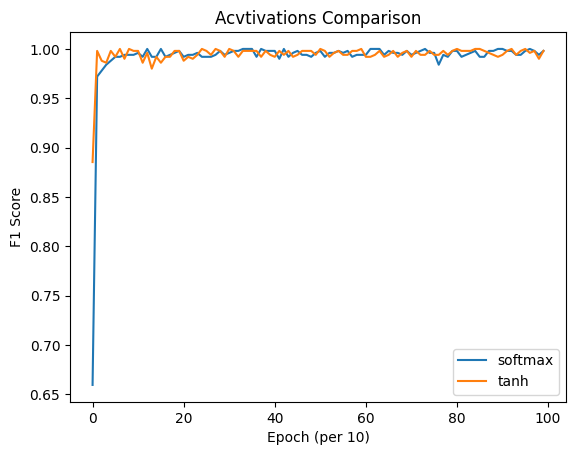

In [38]:
plt.plot(soft_test, label='softmax')
#plt.plot(relu_test, label='relu')
#plt.plot(sigm_test, label='sigmoid')
plt.plot(tanh_test, label='tanh')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 10)')
plt.legend()

# Xor 3 df

In [34]:
train_df = pd.read_csv('data/xor3-training.csv')
test_df = pd.read_csv('data/xor3-test.csv')

print(f'Number of classes: {train_df["c"].nunique()}')

Number of classes: 2


In [35]:
X_train = train_df[['x', 'y']].to_numpy()
Y_train = train_df['c'].to_numpy().reshape(-1,1)  
X_test = test_df[['x', 'y']].to_numpy()
Y_test = test_df['c'].to_numpy().reshape(-1,1)  

# # Kodowanie one-hot dla Y
y_encoder = OneHotEncoder(sparse_output=False)
Y_train_encoded = y_encoder.fit_transform(Y_train)  
Y_test_encoded = y_encoder.transform(Y_test) 

print(X_test.shape)

(500, 2)


Text(0.5, 1.0, 'Xor data')

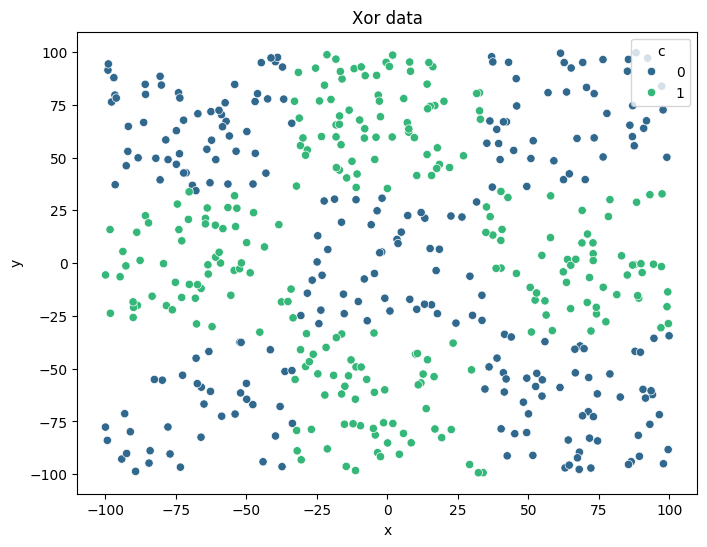

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='x', y='y', hue='c', palette='viridis')
plt.title('Xor data')

# 64 64 Xor

## Softmax activation 

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 7.66265247, Test F1: 0.5029
Epoch 50, Training F1: 0.32813458, Test F1: 0.8275
Epoch 100, Training F1: 0.27000130, Test F1: 0.8370
Epoch 150, Training F1: 0.25833917, Test F1: 0.8312
Epoch 200, Training F1: 0.26176655, Test F1: 0.8347
Epoch 250, Training F1: 0.25467296, Test F1: 0.8483
Epoch 300, Training F1: 0.25546027, Test F1: 0.8503
Epoch 350, Training F1: 0.27809068, Test F1: 0.7993
Epoch 400, Training F1: 0.25075550, Test F1: 0.8547
Epoch 450, Training F1: 0.24719360, Test F1: 0.8544
Epoch 500, Training F1: 0.25604276, Test F1: 0.8485
Epoch 550, Training F1: 0.24344306, Test F1: 0.8469
Epoch 600, Training F1: 0.28353774, Test F1: 0.8245
Epoch 650, Training F1: 0.23511383, Test F1: 0.8370
Epoch 700, Training F1: 0.23743283, Test F1: 0.8332
Epoch 750, Training F1: 0.25179407, Test F1: 0.8292
Epoch 800, 

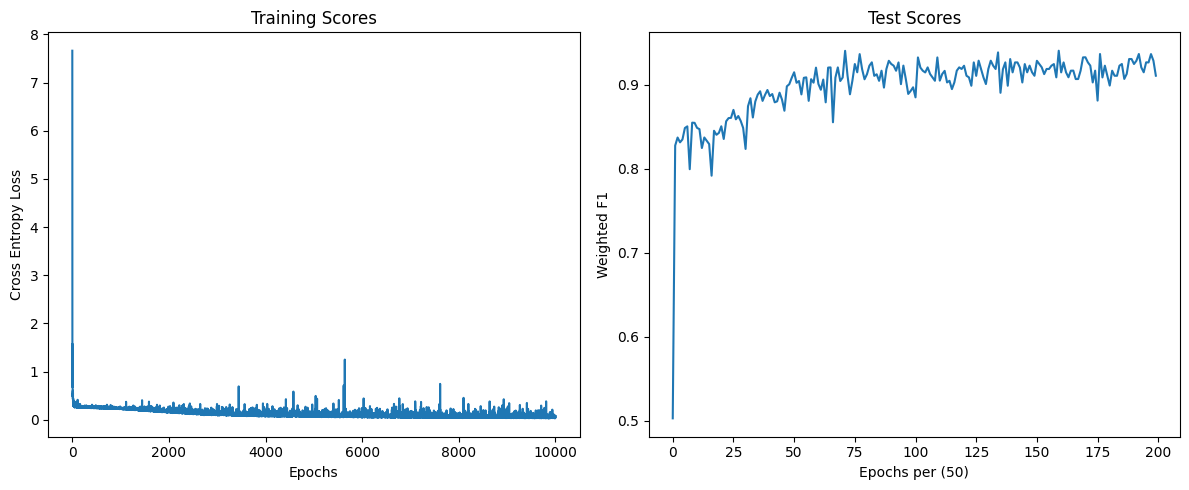

In [209]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='softmax')
soft1_train, soft1_test, soft1_final, soft1_time, soft1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01,batch_size=64,report_frequency=50, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.69481712, Test F1: 0.7664
Epoch 50, Training F1: 0.29084006, Test F1: 0.8133
Epoch 100, Training F1: 0.27836255, Test F1: 0.8214
Epoch 150, Training F1: 0.26908113, Test F1: 0.8368
Epoch 200, Training F1: 0.26381856, Test F1: 0.8313
Epoch 250, Training F1: 0.26923669, Test F1: 0.8425
Epoch 300, Training F1: 0.25774917, Test F1: 0.8390
Epoch 350, Training F1: 0.25418495, Test F1: 0.8312
Epoch 400, Training F1: 0.25168826, Test F1: 0.8349
Epoch 450, Training F1: 0.25200522, Test F1: 0.8324
Epoch 500, Training F1: 0.25670701, Test F1: 0.8365
Epoch 550, Training F1: 0.24140998, Test F1: 0.8483
Epoch 600, Training F1: 0.25364064, Test F1: 0.8503
Epoch 650, Training F1: 0.23972915, Test F1: 0.8449
Epoch 700, Training F1: 0.23423635, Test F1: 0.8521
Epoch 750, Training F1: 0.22713407, Test F1: 0.8525
Epoch 800, 

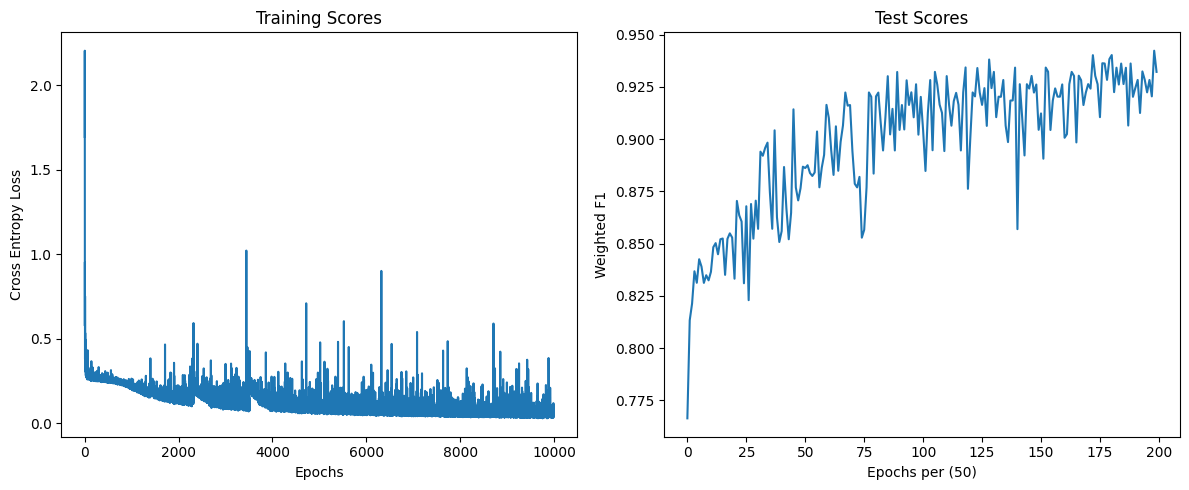

In [210]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='softmax')
soft2_train, soft2_test, soft2_final, soft2_time, soft2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01,batch_size=64,report_frequency=50, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 14.03003881, Test F1: 0.5197
Epoch 50, Training F1: 0.27135632, Test F1: 0.8252
Epoch 100, Training F1: 0.26619179, Test F1: 0.8194
Epoch 150, Training F1: 0.26349589, Test F1: 0.8348
Epoch 200, Training F1: 0.25570805, Test F1: 0.8370
Epoch 250, Training F1: 0.25353519, Test F1: 0.8450
Epoch 300, Training F1: 0.25900153, Test F1: 0.8174
Epoch 350, Training F1: 0.25593889, Test F1: 0.8350
Epoch 400, Training F1: 0.25742371, Test F1: 0.8507
Epoch 450, Training F1: 0.24912279, Test F1: 0.8465
Epoch 500, Training F1: 0.25575113, Test F1: 0.8174
Epoch 550, Training F1: 0.25663175, Test F1: 0.8425
Epoch 600, Training F1: 0.25064621, Test F1: 0.8312
Epoch 650, Training F1: 0.26267362, Test F1: 0.8313
Epoch 700, Training F1: 0.24316247, Test F1: 0.8446
Epoch 750, Training F1: 0.25785267, Test F1: 0.8330
Epoch 800,

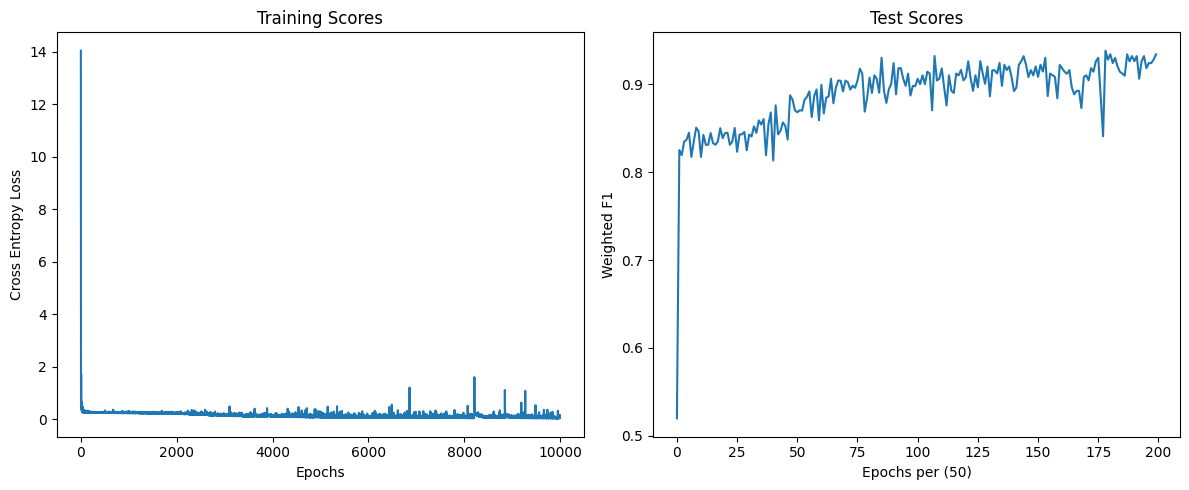

In [211]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='softmax')
soft3_train, soft3_test, soft3_final, soft3_time, soft3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 1.86992884, Test F1: 0.6627
Epoch 50, Training F1: 0.26404382, Test F1: 0.8368
Epoch 100, Training F1: 0.29434326, Test F1: 0.7956
Epoch 150, Training F1: 0.24055313, Test F1: 0.8450
Epoch 200, Training F1: 0.25968204, Test F1: 0.8332
Epoch 250, Training F1: 0.27390385, Test F1: 0.8411
Epoch 300, Training F1: 0.24146291, Test F1: 0.8234
Epoch 350, Training F1: 0.25438481, Test F1: 0.8581
Epoch 400, Training F1: 0.26107750, Test F1: 0.8578
Epoch 450, Training F1: 0.23250204, Test F1: 0.8568
Epoch 500, Training F1: 0.22967968, Test F1: 0.8331
Epoch 550, Training F1: 0.23112445, Test F1: 0.8665
Epoch 600, Training F1: 0.22680209, Test F1: 0.8643
Epoch 650, Training F1: 0.23647186, Test F1: 0.8333
Epoch 700, Training F1: 0.23028116, Test F1: 0.8509
Epoch 750, Training F1: 0.22306147, Test F1: 0.8642
Epoch 800, 

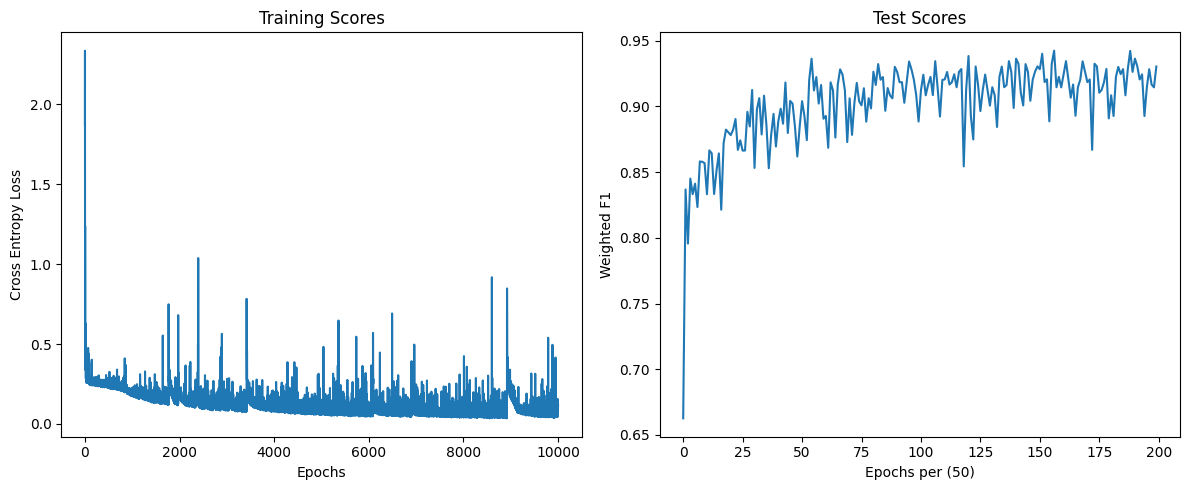

In [212]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='softmax')
soft4_train, soft4_test, soft4_final, soft4_time, soft4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, report_frequency = 50, batch_size=64, epochs=10000, loss_threshold=1.6)

In [213]:
# softmax statistics
soft_mse = [soft1_final, soft2_final, soft3_final, soft4_final]
soft_time = [soft1_time, soft2_time, soft3_time, soft4_time]

print(f'Mean epoch number {np.mean(soft_mse)}')
print(f'Mean time : {np.mean(soft_time)}')

Mean epoch number 0.926841335082942
Mean time : 21.496911644935608


## Tanh activation

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 0.00791060, Test F1: 0.6388
Epoch 50, Training F1: 0.58190500, Test F1: 0.8372
Epoch 100, Training F1: 0.61536074, Test F1: 0.8482
Epoch 150, Training F1: 0.28550954, Test F1: 0.8468
Epoch 200, Training F1: 0.26722091, Test F1: 0.8466
Epoch 250, Training F1: 0.25379432, Test F1: 0.8527
Epoch 300, Training F1: 0.23890443, Test F1: 0.8581
Epoch 350, Training F1: 0.24253858, Test F1: 0.8465
Epoch 400, Training F1: 0.24279762, Test F1: 0.8624
Epoch 450, Training F1: 0.24779078, Test F1: 0.8549
Epoch 500, Training F1: 0.23303929, Test F1: 0.8760
Epoch 550, Training F1: 0.21968606, Test F1: 0.8561
Epoch 600, Training F1: 0.21390248, Test F1: 0.8627
Epoch 650, Training F1: 0.21170409, Test F1: 0.8588
Epoch 700, Training F1: 0.20764171, Test F1: 0.8701
Epoch 750, Training F1: 0.22465358, Test F1: 0.8683
Epoch 800, Tra

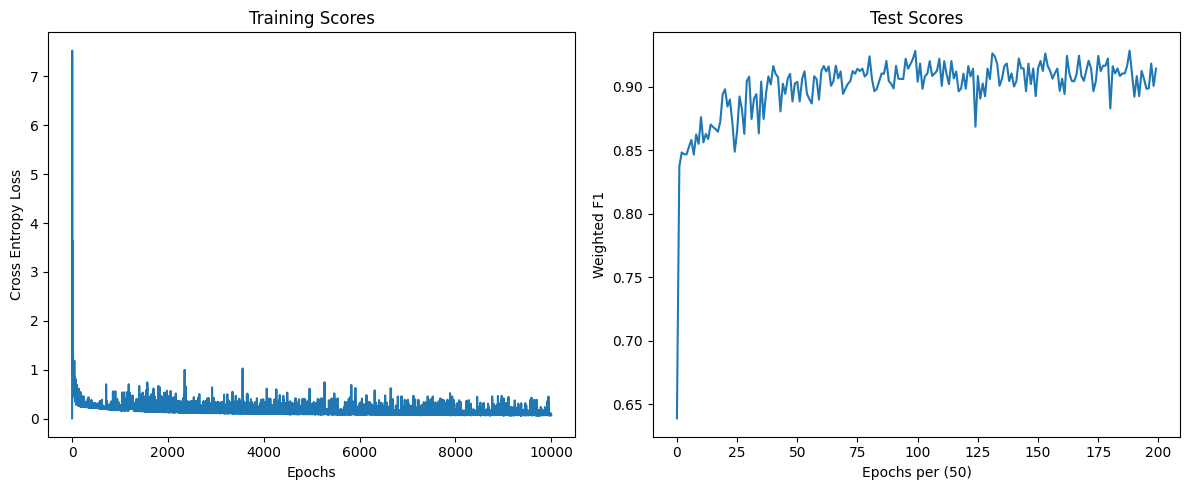

In [214]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='tanh')
tanh1_train, tanh1_test, tanh1_final, tanh1_time, tanh1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 6.59196007, Test F1: 0.4451
Epoch 50, Training F1: 0.32421941, Test F1: 0.8529
Epoch 100, Training F1: 0.23906811, Test F1: 0.8529
Epoch 150, Training F1: 0.25198155, Test F1: 0.8427
Epoch 200, Training F1: 0.22951549, Test F1: 0.8601
Epoch 250, Training F1: 0.24241073, Test F1: 0.8547
Epoch 300, Training F1: 0.22121269, Test F1: 0.8464
Epoch 350, Training F1: 0.21953057, Test F1: 0.8601
Epoch 400, Training F1: 0.22640398, Test F1: 0.8601
Epoch 450, Training F1: 0.22900363, Test F1: 0.8600
Epoch 500, Training F1: 0.20599340, Test F1: 0.8602
Epoch 550, Training F1: 0.21874195, Test F1: 0.8581
Epoch 600, Training F1: 0.20942665, Test F1: 0.8740
Epoch 650, Training F1: 0.41711128, Test F1: 0.8760
Epoch 700, Training F1: 0.19486111, Test F1: 0.8723
Epoch 750, Training F1: 0.18392301, Test F1: 0.8719
Epoch 800, Tra

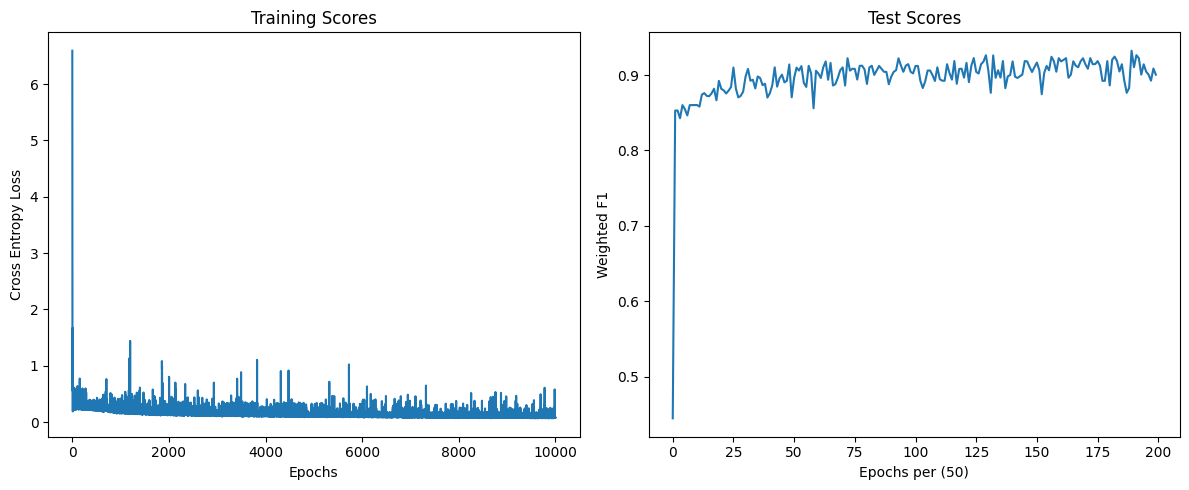

In [215]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='tanh')
tanh2_train, tanh2_test, tanh2_final, tanh2_time, tanh2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 8.85980176, Test F1: 0.5627
Epoch 50, Training F1: 1.09627038, Test F1: 0.8513
Epoch 100, Training F1: 0.36196577, Test F1: 0.8429
Epoch 150, Training F1: 0.92219870, Test F1: 0.8550
Epoch 200, Training F1: 0.27722274, Test F1: 0.8547
Epoch 250, Training F1: 0.24457665, Test F1: 0.8523
Epoch 300, Training F1: 0.30848972, Test F1: 0.8463
Epoch 350, Training F1: 0.23621391, Test F1: 0.8431
Epoch 400, Training F1: 0.25234819, Test F1: 0.8469
Epoch 450, Training F1: 0.29645124, Test F1: 0.8527
Epoch 500, Training F1: 0.24463393, Test F1: 0.8588
Epoch 550, Training F1: 0.22609569, Test F1: 0.8603
Epoch 600, Training F1: 0.45977131, Test F1: 0.8411
Epoch 650, Training F1: 0.21768346, Test F1: 0.8450
Epoch 700, Training F1: 0.21313159, Test F1: 0.8684
Epoch 750, Training F1: 0.21812129, Test F1: 0.8636
Epoch 800, Tra

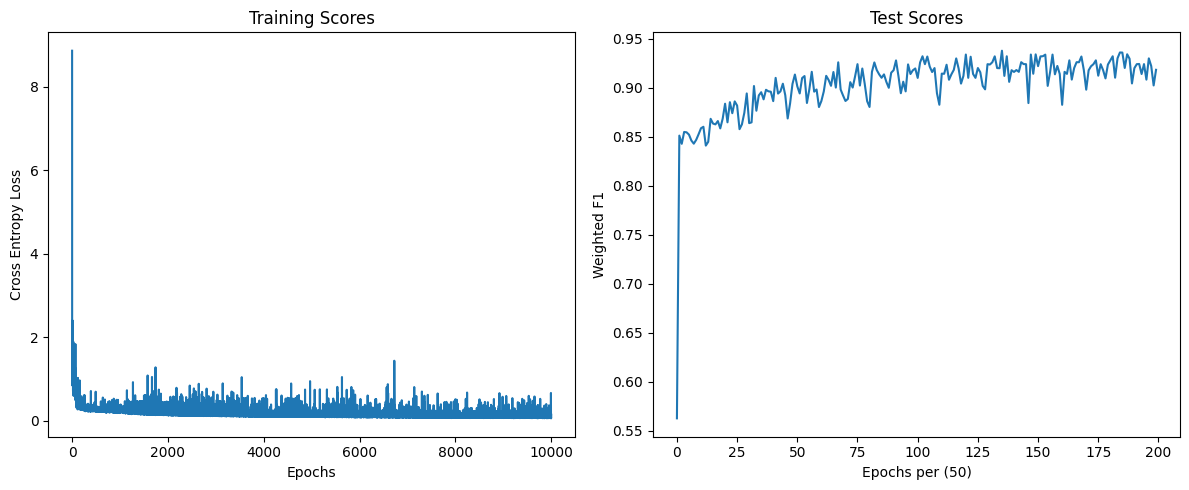

In [216]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='tanh')
tanh3_train, tanh3_test, tanh3_final, tanh3_time, tanh3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',report_frequency=50,  learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 3.49133487, Test F1: 0.6765
Epoch 50, Training F1: 0.48739539, Test F1: 0.8470
Epoch 100, Training F1: 0.32061047, Test F1: 0.8331
Epoch 150, Training F1: 0.25343602, Test F1: 0.8389
Epoch 200, Training F1: 0.34147654, Test F1: 0.8467
Epoch 250, Training F1: 0.30458544, Test F1: 0.8527
Epoch 300, Training F1: 0.24745385, Test F1: 0.8411
Epoch 350, Training F1: 0.25172023, Test F1: 0.8604
Epoch 400, Training F1: 0.22298688, Test F1: 0.8665
Epoch 450, Training F1: 0.21182321, Test F1: 0.8486
Epoch 500, Training F1: 0.36151391, Test F1: 0.8352
Epoch 550, Training F1: 0.23949055, Test F1: 0.8447
Epoch 600, Training F1: 0.19860033, Test F1: 0.8686
Epoch 650, Training F1: 0.19190189, Test F1: 0.8647
Epoch 700, Training F1: 0.35703762, Test F1: 0.8667
Epoch 750, Training F1: 0.22739435, Test F1: 0.8543
Epoch 800, Tra

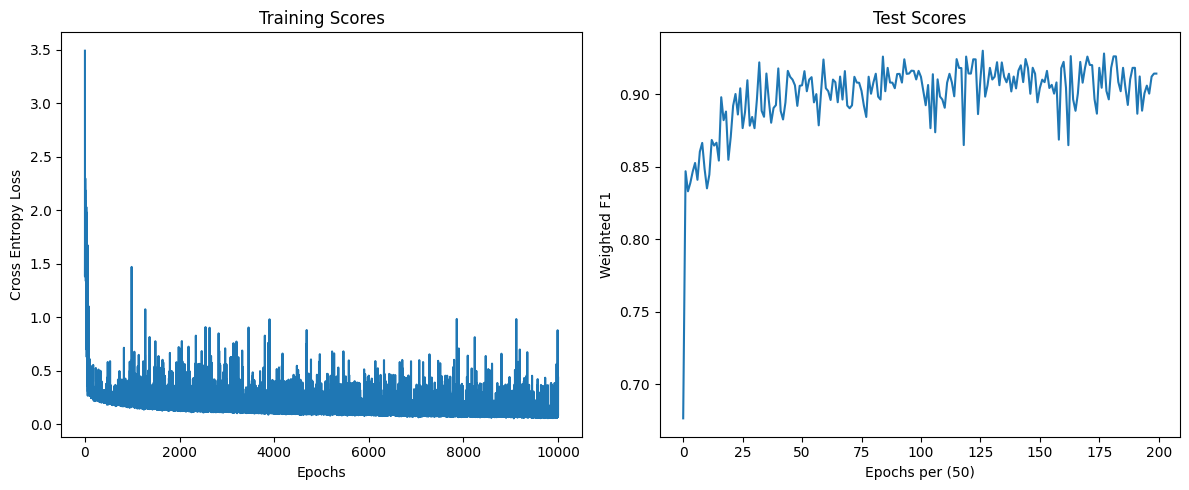

In [217]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='tanh')
tanh4_train, tanh4_test, tanh4_final, tanh4_time, tanh4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

In [218]:
# tanh statistics
tanh_mse = [tanh1_final, tanh2_final, tanh3_final, tanh4_final]
tanh_time = [tanh1_time, tanh2_time, tanh3_time, tanh4_time]

print(f'Mean epoch number {np.mean(tanh_mse)}')
print(f'Mean time : {np.mean(tanh_time)}')

Mean epoch number 0.9118513653373901
Mean time : 18.77439785003662


## Sigmoid

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 1.14756185, Test F1: 0.4354
Epoch 50, Training F1: 0.65106652, Test F1: 0.6957
Epoch 100, Training F1: 0.61714455, Test F1: 0.7773
Epoch 150, Training F1: 0.58341008, Test F1: 0.8015
Epoch 200, Training F1: 0.54458418, Test F1: 0.8194
Epoch 250, Training F1: 0.50218937, Test F1: 0.8430
Epoch 300, Training F1: 0.46173801, Test F1: 0.8469
Epoch 350, Training F1: 0.42686344, Test F1: 0.8489
Epoch 400, Training F1: 0.39792566, Test F1: 0.8489
Epoch 450, Training F1: 0.37469080, Test F1: 0.8489
Epoch 500, Training F1: 0.35708520, Test F1: 0.8469
Epoch 550, Training F1: 0.34342301, Test F1: 0.8469
Epoch 600, Training F1: 0.33293975, Test F1: 0.8469
Epoch 650, Training F1: 0.32462567, Test F1: 0.8469
Epoch 700, Training F1: 0.31771025, Test F1: 0.8450
Epoch 750, Training F1: 0.31227607, Test F1: 0.8450
Epoch 800, 

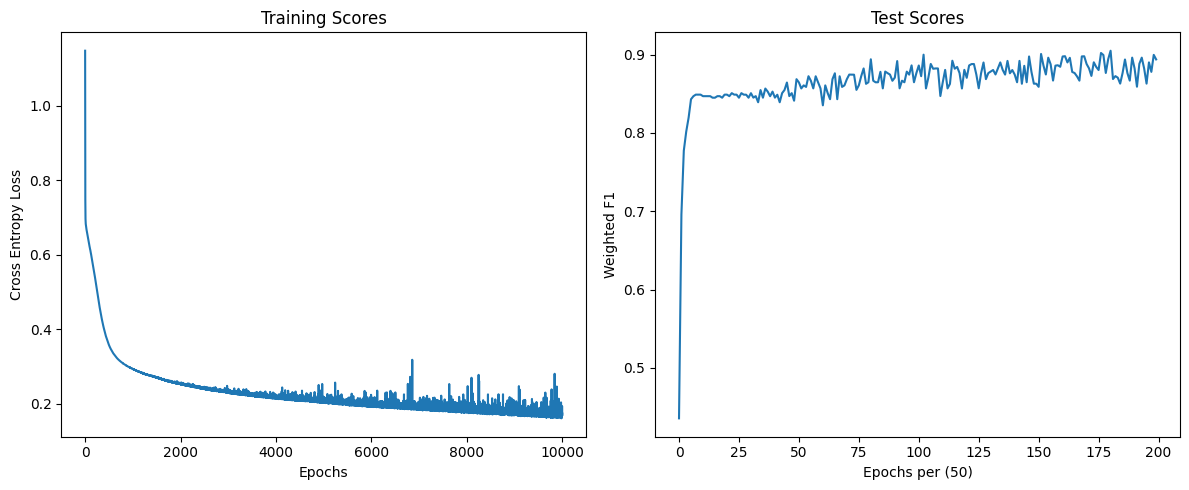

In [219]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm1_train, sigm1_test, sigm1_final, sigm1_time, sigm1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.87342222, Test F1: 0.4124
Epoch 50, Training F1: 0.66718563, Test F1: 0.5458
Epoch 100, Training F1: 0.63764086, Test F1: 0.6507
Epoch 150, Training F1: 0.60464675, Test F1: 0.6780
Epoch 200, Training F1: 0.56584208, Test F1: 0.7677
Epoch 250, Training F1: 0.52197726, Test F1: 0.8391
Epoch 300, Training F1: 0.48017918, Test F1: 0.8409
Epoch 350, Training F1: 0.44359812, Test F1: 0.8428
Epoch 400, Training F1: 0.41351313, Test F1: 0.8408
Epoch 450, Training F1: 0.39006405, Test F1: 0.8388
Epoch 500, Training F1: 0.37225187, Test F1: 0.8428
Epoch 550, Training F1: 0.35838256, Test F1: 0.8408
Epoch 600, Training F1: 0.34735773, Test F1: 0.8428
Epoch 650, Training F1: 0.33932277, Test F1: 0.8428
Epoch 700, Training F1: 0.33298502, Test F1: 0.8448
Epoch 750, Training F1: 0.32799897, Test F1: 0.8468
Epoch 800, 

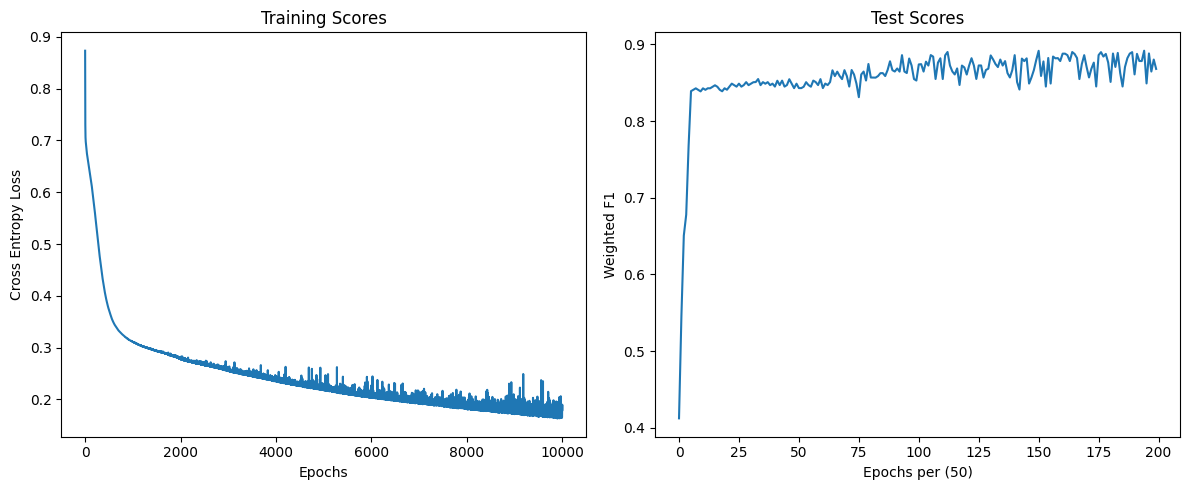

In [220]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm2_train, sigm2_test, sigm2_final, sigm2_time, sigm2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 1.33044492, Test F1: 0.2747
Epoch 50, Training F1: 0.64930477, Test F1: 0.6051
Epoch 100, Training F1: 0.61617596, Test F1: 0.7246
Epoch 150, Training F1: 0.57851681, Test F1: 0.8093
Epoch 200, Training F1: 0.53994709, Test F1: 0.8292
Epoch 250, Training F1: 0.50143479, Test F1: 0.8351
Epoch 300, Training F1: 0.46505651, Test F1: 0.8409
Epoch 350, Training F1: 0.43266908, Test F1: 0.8430
Epoch 400, Training F1: 0.40429782, Test F1: 0.8450
Epoch 450, Training F1: 0.38168272, Test F1: 0.8450
Epoch 500, Training F1: 0.36381357, Test F1: 0.8450
Epoch 550, Training F1: 0.34974798, Test F1: 0.8450
Epoch 600, Training F1: 0.33845692, Test F1: 0.8450
Epoch 650, Training F1: 0.32963993, Test F1: 0.8450
Epoch 700, Training F1: 0.32259853, Test F1: 0.8410
Epoch 750, Training F1: 0.31641269, Test F1: 0.8450
Epoch 800, 

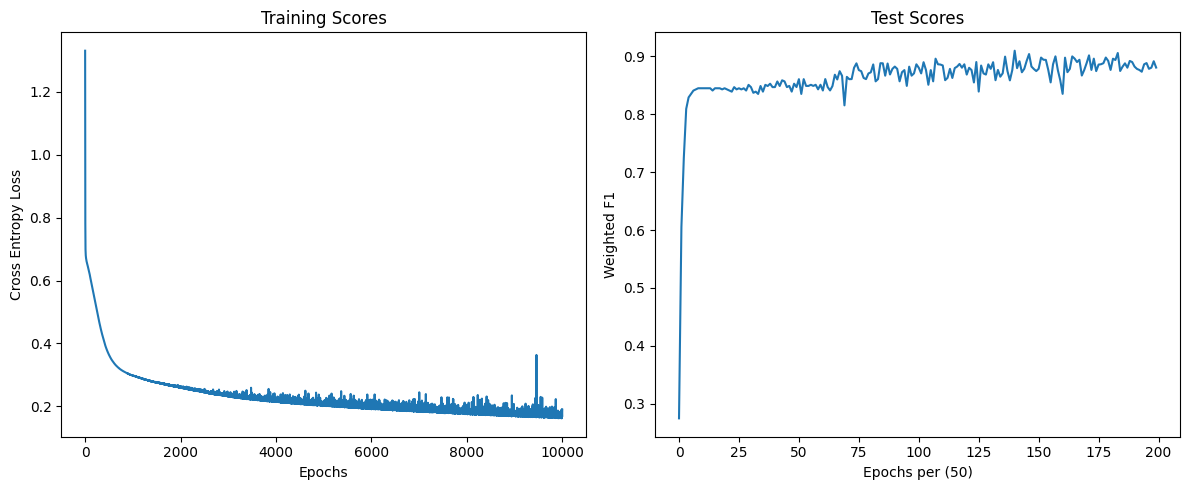

In [221]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm3_train, sigm3_test, sigm3_final, sigm3_time, sigm3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',report_frequency=50,  learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 1.18999312, Test F1: 0.4519
Epoch 50, Training F1: 0.66018699, Test F1: 0.5368
Epoch 100, Training F1: 0.63564640, Test F1: 0.6507
Epoch 150, Training F1: 0.60747178, Test F1: 0.7281
Epoch 200, Training F1: 0.57404540, Test F1: 0.7856
Epoch 250, Training F1: 0.53670184, Test F1: 0.8134
Epoch 300, Training F1: 0.49911751, Test F1: 0.8252
Epoch 350, Training F1: 0.46156184, Test F1: 0.8371
Epoch 400, Training F1: 0.42943527, Test F1: 0.8391
Epoch 450, Training F1: 0.40221632, Test F1: 0.8430
Epoch 500, Training F1: 0.38055831, Test F1: 0.8430
Epoch 550, Training F1: 0.36351683, Test F1: 0.8450
Epoch 600, Training F1: 0.35025427, Test F1: 0.8430
Epoch 650, Training F1: 0.34009835, Test F1: 0.8430
Epoch 700, Training F1: 0.33246707, Test F1: 0.8410
Epoch 750, Training F1: 0.32516678, Test F1: 0.8430
Epoch 800, 

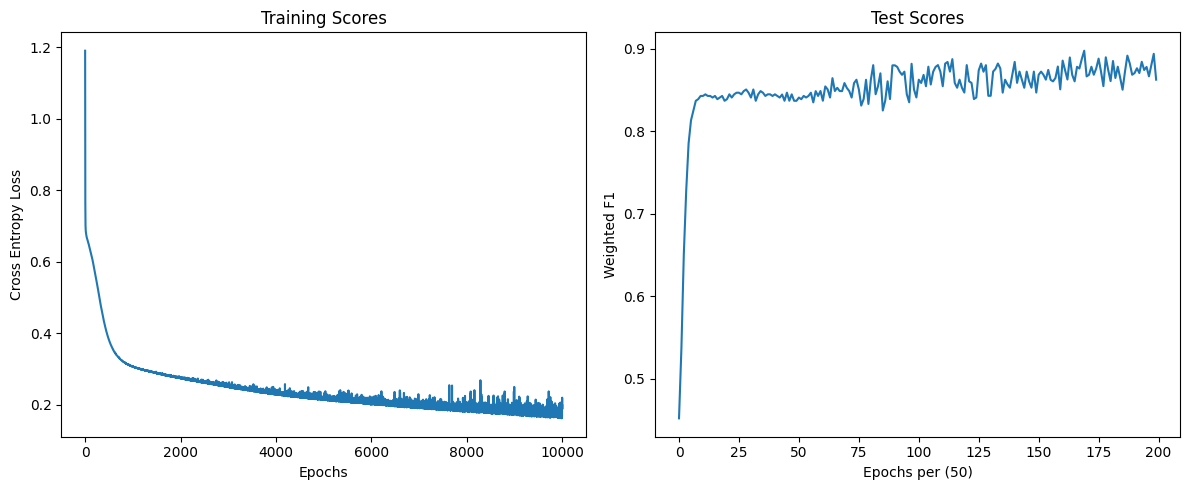

In [222]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="sigmoid", last_layer_activation='sigmoid')
sigm4_train, sigm4_test, sigm4_final, sigm4_time, sigm4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

In [223]:
# sigmoid statistics
sigm_mse = [sigm1_final, sigm2_final, sigm3_final, sigm4_final]
sigm_time = [sigm1_time, sigm2_time, sigm3_time, sigm4_time]

print(f'Mean epoch number {np.mean(sigm_mse)}')
print(f'Mean time : {np.mean(sigm_time)}')

Mean epoch number 0.8763552268557315
Mean time : 43.93764388561249


## Relu 

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 12.41543459, Test F1: 0.4967
Epoch 50, Training F1: 0.56670669, Test F1: 0.8272
Epoch 100, Training F1: 0.43919389, Test F1: 0.8192
Epoch 150, Training F1: 0.24817971, Test F1: 0.8390
Epoch 200, Training F1: 0.24363982, Test F1: 0.8489
Epoch 250, Training F1: 0.30267226, Test F1: 0.8568
Epoch 300, Training F1: 0.28778627, Test F1: 0.8489
Epoch 350, Training F1: 0.22316222, Test F1: 0.8450
Epoch 400, Training F1: 0.22586748, Test F1: 0.8529
Epoch 450, Training F1: 0.21858598, Test F1: 0.8488
Epoch 500, Training F1: 0.29598953, Test F1: 0.8726
Epoch 550, Training F1: 0.28112775, Test F1: 0.8645
Epoch 600, Training F1: 0.21298372, Test F1: 0.8548
Epoch 650, Training F1: 0.20394660, Test F1: 0.8588
Epoch 700, Training F1: 0.20028505, Test F1: 0.8548
Epoch 750, Training F1: 0.20312912, Test F1: 0.8528
Epoch 800, Tr

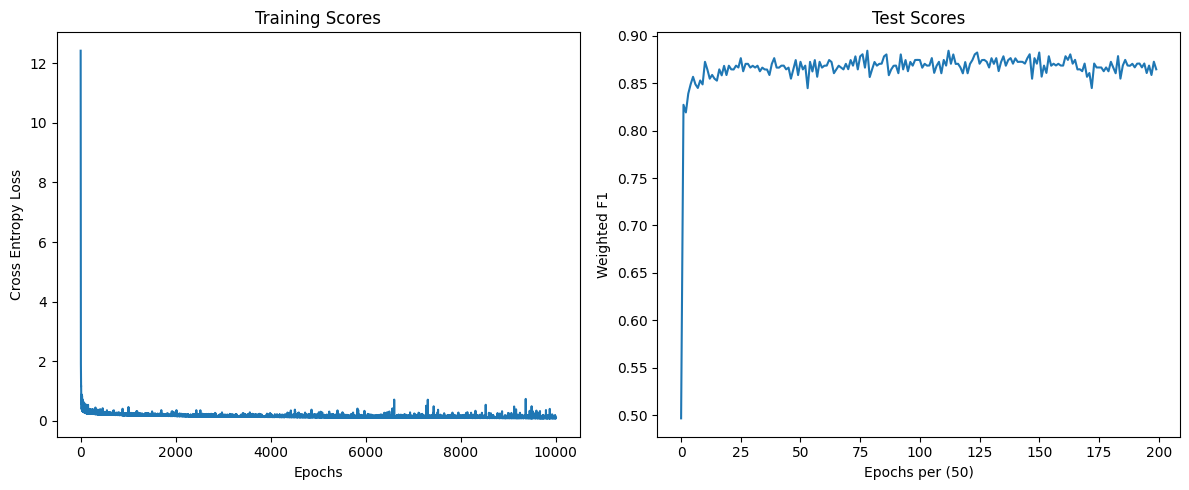

In [238]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="tanh", last_layer_activation='relu')
rel1_train, rel1_test, rel1_final, rel1_time, rel1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 3.48368824, Test F1: 0.5792
Epoch 50, Training F1: 0.47882646, Test F1: 0.8212
Epoch 100, Training F1: 0.54774766, Test F1: 0.8430
Epoch 150, Training F1: 0.60035326, Test F1: 0.8271
Epoch 200, Training F1: 0.52437058, Test F1: 0.8469
Epoch 250, Training F1: 0.44761034, Test F1: 0.8430
Epoch 300, Training F1: 0.57551041, Test F1: 0.8311
Epoch 350, Training F1: 0.38382662, Test F1: 0.8488
Epoch 400, Training F1: 0.43173145, Test F1: 0.8529
Epoch 450, Training F1: 0.31179358, Test F1: 0.8547
Epoch 500, Training F1: 0.42809491, Test F1: 0.8469
Epoch 550, Training F1: 0.36655666, Test F1: 0.8646
Epoch 600, Training F1: 0.36215417, Test F1: 0.8587
Epoch 650, Training F1: 0.37127271, Test F1: 0.8528
Epoch 700, Training F1: 0.37258861, Test F1: 0.8528
Epoch 750, Training F1: 0.42305322, Test F1: 0.8449
Epoch 800, Tra

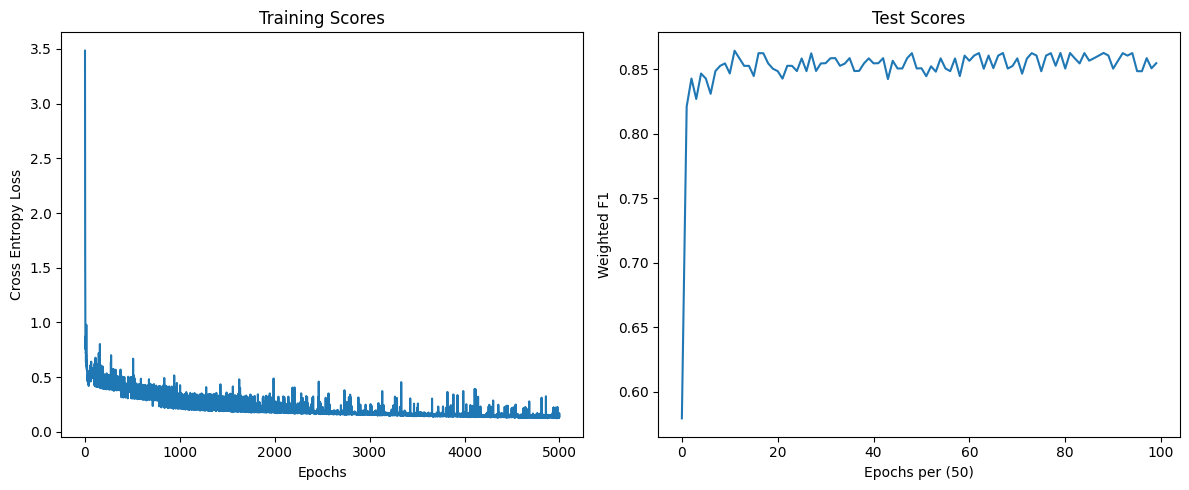

In [231]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="tanh", last_layer_activation='relu')
rel2_train, rel2_test, rel2_final, rel2_time, rel2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=5000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 16.85613152, Test F1: 0.5447
Epoch 50, Training F1: 0.54996451, Test F1: 0.8094
Epoch 100, Training F1: 0.43511875, Test F1: 0.8214
Epoch 150, Training F1: 0.36545858, Test F1: 0.8312
Epoch 200, Training F1: 0.28615764, Test F1: 0.8193
Epoch 250, Training F1: 0.33542751, Test F1: 0.8410
Epoch 300, Training F1: 0.27548239, Test F1: 0.8470
Epoch 350, Training F1: 0.32448551, Test F1: 0.8429
Epoch 400, Training F1: 0.31951558, Test F1: 0.8429
Epoch 450, Training F1: 0.37690460, Test F1: 0.8508
Epoch 500, Training F1: 0.23448451, Test F1: 0.8390
Epoch 550, Training F1: 0.23388767, Test F1: 0.8469
Epoch 600, Training F1: 0.30457544, Test F1: 0.8387
Epoch 650, Training F1: 0.22743519, Test F1: 0.8527
Epoch 700, Training F1: 0.25631180, Test F1: 0.8605
Epoch 750, Training F1: 0.22680574, Test F1: 0.8546
Epoch 800, Tr

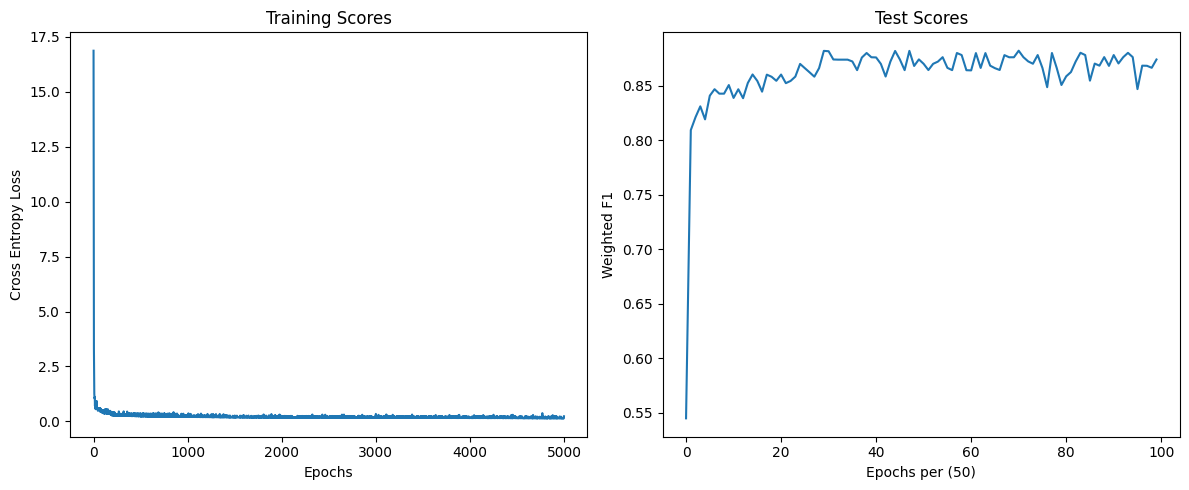

In [232]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="tanh", last_layer_activation='relu')
rel3_train, rel3_test, rel3_final, rel3_time, rel3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50,  learning_rate=0.01,batch_size=64, epochs=5000, loss_threshold=1.6)

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 6.76579839, Test F1: 0.6426
Epoch 50, Training F1: 0.44230897, Test F1: 0.7850
Epoch 100, Training F1: 0.31974921, Test F1: 0.8130
Epoch 150, Training F1: 0.63408237, Test F1: 0.8151
Epoch 200, Training F1: 0.43095935, Test F1: 0.8174
Epoch 250, Training F1: 0.27819332, Test F1: 0.8272
Epoch 300, Training F1: 0.26614404, Test F1: 0.8331
Epoch 350, Training F1: 0.31307052, Test F1: 0.8272
Epoch 400, Training F1: 0.24011889, Test F1: 0.8428
Epoch 450, Training F1: 0.23028562, Test F1: 0.8390
Epoch 500, Training F1: 0.23209647, Test F1: 0.8449
Epoch 550, Training F1: 0.35806190, Test F1: 0.8450
Epoch 600, Training F1: 0.23169228, Test F1: 0.8391
Epoch 650, Training F1: 0.28952450, Test F1: 0.8528
Epoch 700, Training F1: 0.21951220, Test F1: 0.8607
Epoch 750, Training F1: 0.21880332, Test F1: 0.8450
Epoch 800, Tra

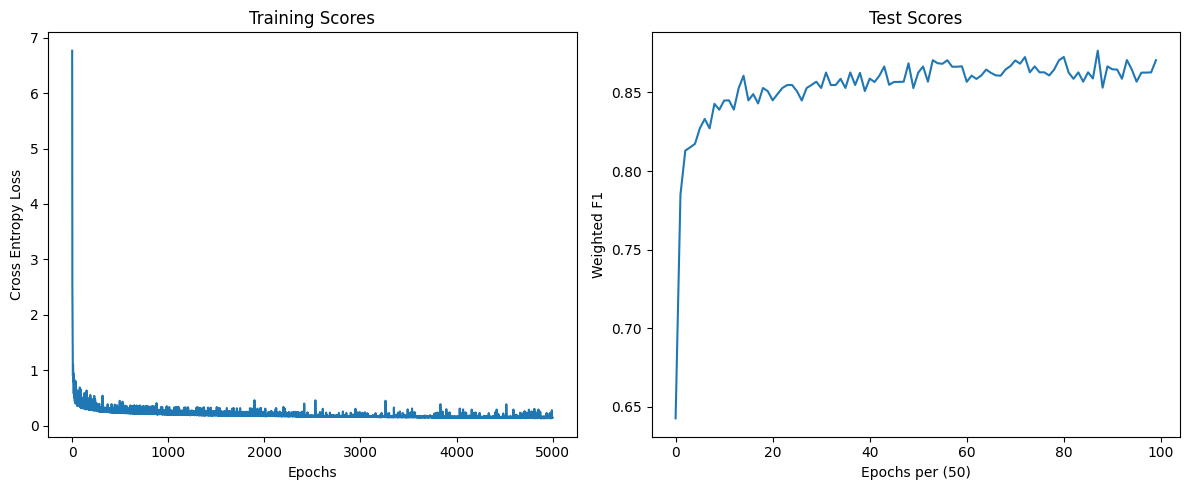

In [233]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="tanh", last_layer_activation='relu')
rel4_train, rel4_test, rel4_final, rel4_time, rel4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50,  learning_rate=0.01,batch_size=64, epochs=5000, loss_threshold=1.6)

In [234]:
# relu statistics
rel_mse = [rel1_final, rel2_final, rel3_final, rel4_final]
rel_time = [rel1_time, rel2_time, rel3_time, rel4_time]

print(f'Mean epoch number {np.mean(rel_mse)}')
print(f'Mean time : {np.mean(rel_time)}')

Mean epoch number 0.8719974670923252
Mean time : 48.45027107000351


## Comparison

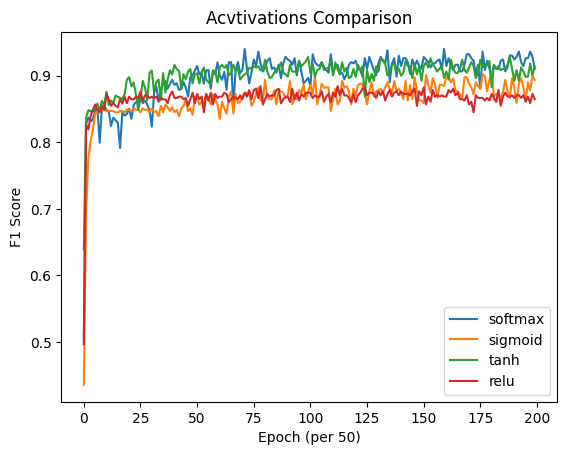

In [239]:
plt.plot(soft1_test, label='softmax')
plt.plot(sigm1_test, label='sigmoid')
plt.plot(tanh1_test, label='tanh')
plt.plot(rel1_test, label='relu') 
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 50)')
plt.legend()

Text(0.5, 1.0, 'Final F1 for each attempt')

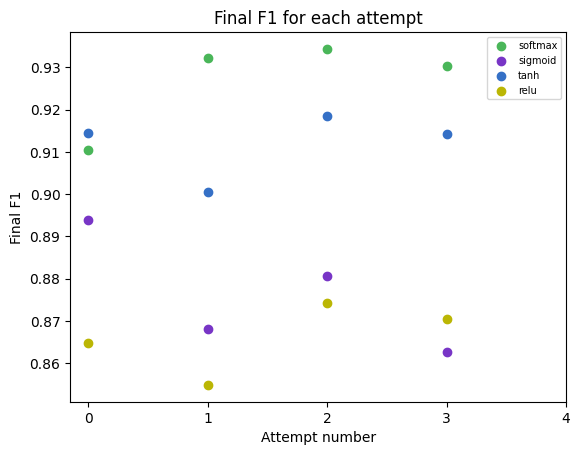

In [243]:
soft_final = [soft1_final, soft2_final, soft3_final, soft4_final]
sigm_final = [ sigm1_final, sigm2_final, sigm3_final, sigm4_final]
tanh_final = [tanh1_final, tanh2_final, tanh3_final, tanh4_final]
relu_final = [rel1_final, rel2_final, rel3_final, rel4_final]

plt.scatter(np.arange(len(soft_final)),soft_final, color='#4ab659', label='softmax')
plt.scatter(np.arange(len(sigm_final)),sigm_final, color='#7835c6', label='sigmoid')
plt.scatter(np.arange(len(tanh_final)),tanh_final, color='#3570c6', label='tanh')
plt.scatter(np.arange(len(relu_final)),relu_final, color='#bbb604', label='relu')
plt.xticks([0,1,2,3,4])
plt.xlabel('Attempt number')
plt.ylabel('Final F1')
plt.legend(loc='upper right', fontsize = 7)
plt.title('Final F1 for each attempt')

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
tanh function chosen for last layer.
Epoch 0, Training F1: 7.55197748, Test F1: 0.5148
Epoch 50, Training F1: 0.26512937, Test F1: 0.8332
Epoch 100, Training F1: 0.27227026, Test F1: 0.8431
Epoch 150, Training F1: 0.25553597, Test F1: 0.8386
Epoch 200, Training F1: 0.27737260, Test F1: 0.8425
Epoch 250, Training F1: 0.38177594, Test F1: 0.8330
Epoch 300, Training F1: 0.32846873, Test F1: 0.8313
Epoch 350, Training F1: 0.24730921, Test F1: 0.8567
Epoch 400, Training F1: 0.26303868, Test F1: 0.8486
Epoch 450, Training F1: 0.26215639, Test F1: 0.8539
Epoch 500, Training F1: 0.23648089, Test F1: 0.8351
Epoch 550, Training F1: 0.24404986, Test F1: 0.8483
Epoch 600, Training F1: 0.24982445, Test F1: 0.8603
Epoch 650, Training F1: 0.24817560, Test F1: 0.8468
Epoch 700, Training F1: 0.24150361, Test F1: 0.8271
Epoch 750, Training F1: 0.23198354, Test F1: 0.8491
Epoch 800, Tra

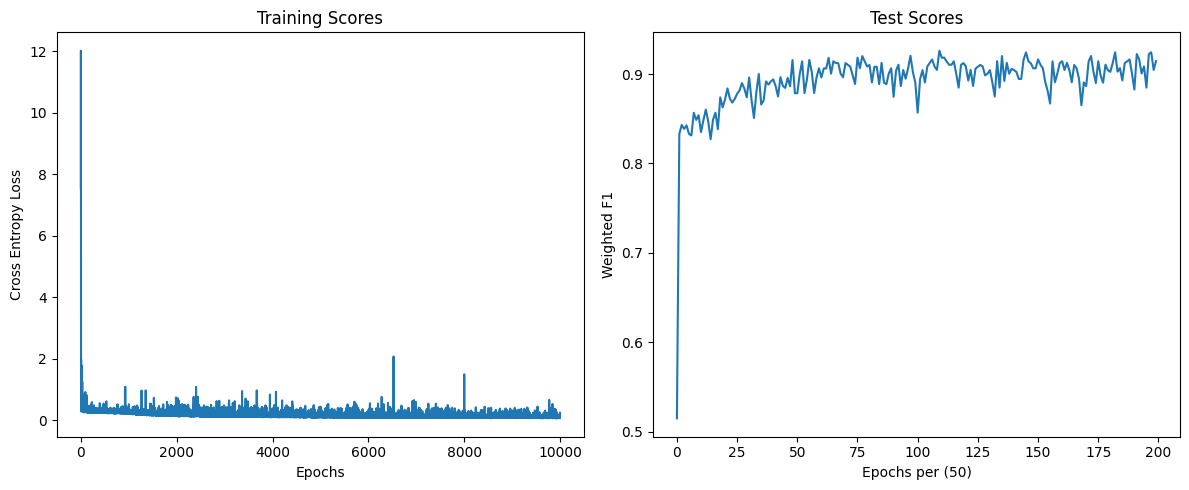

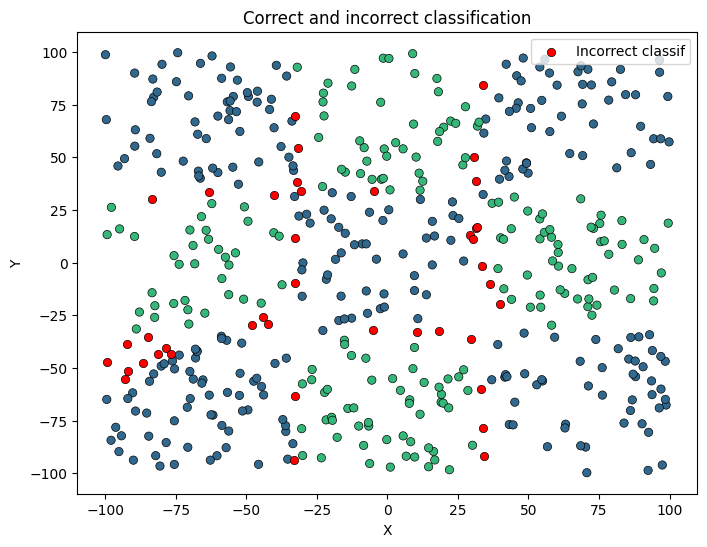

In [241]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='tanh')
tanh1_train, tanh1_test, tanh1_final, tanh1_time, tanh1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=1.6)

y_pred_probs = nn.forward(X_test)  # Macierz (n_samples, n_classes)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test = Y_test.ravel()

correct = y_test == y_pred
df_plot = pd.DataFrame({
    'x': X_test[:, 0],
    'y': X_test[:, 1],
    'class': y_test,  # Klasa prawdziwa
    'correct': correct  # Czy poprawnie sklasyfikowane?
})


palette = sns.color_palette("viridis", as_cmap=True)
df_plot['class'] = df_plot['class'].astype('category')
plt.figure(figsize=(8, 6))


sns.scatterplot(
    data=df_plot[df_plot['correct']], 
    x='x', y='y', 
    hue='class', palette="viridis", 
    edgecolor='k', legend=False
)

#Następnie rysujemy błędne predykcje (zawsze na czerwono)
sns.scatterplot(
    data=df_plot[~df_plot['correct']], 
    x='x', y='y', 
    color='red', 
    edgecolor='k', label="Incorrect classif"
)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Correct and incorrect classification')
plt.legend()
plt.show()

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 11.87178052, Test F1: 0.5235
Epoch 50, Training F1: 0.27490713, Test F1: 0.8333
Epoch 100, Training F1: 0.29200986, Test F1: 0.7831
Epoch 150, Training F1: 0.26917431, Test F1: 0.8054
Epoch 200, Training F1: 0.25615211, Test F1: 0.8274
Epoch 250, Training F1: 0.24776171, Test F1: 0.8392
Epoch 300, Training F1: 0.24126077, Test F1: 0.8468
Epoch 350, Training F1: 0.24686977, Test F1: 0.8194
Epoch 400, Training F1: 0.25027675, Test F1: 0.8639
Epoch 450, Training F1: 0.24651612, Test F1: 0.8544
Epoch 500, Training F1: 0.23214399, Test F1: 0.8598
Epoch 550, Training F1: 0.24475949, Test F1: 0.8522
Epoch 600, Training F1: 0.23026795, Test F1: 0.8604
Epoch 650, Training F1: 0.24081936, Test F1: 0.8274
Epoch 700, Training F1: 0.21874663, Test F1: 0.8588
Epoch 750, Training F1: 0.23069189, Test F1: 0.8583
Epoch 800,

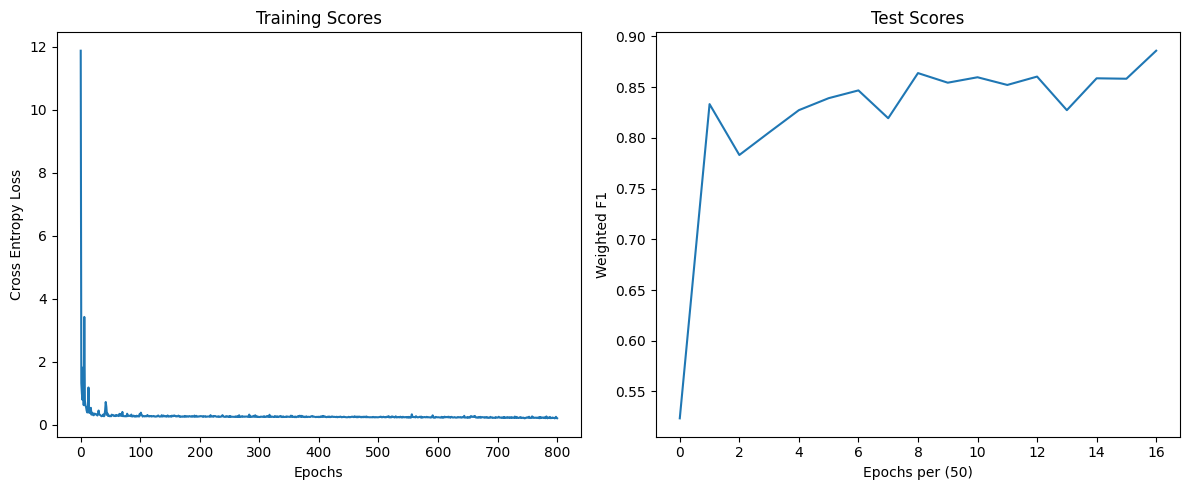

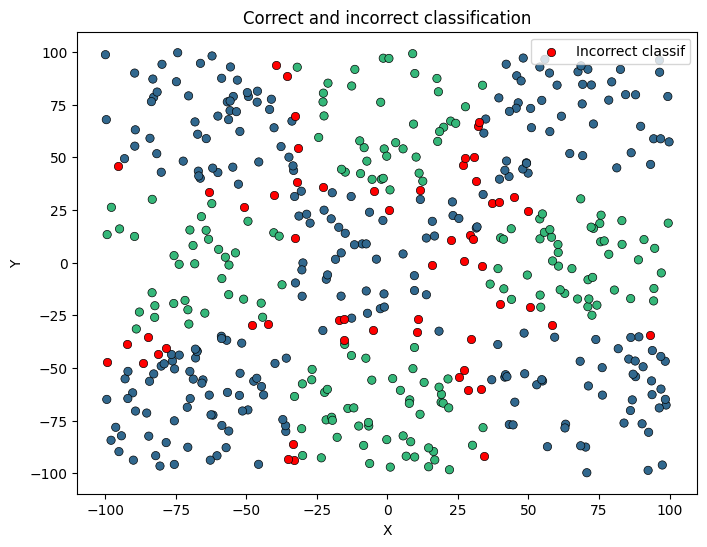

In [269]:
nn = NeuralNetwork(layers=[2, 64,64, 2], activation="relu", last_layer_activation='softmax')
tanh1_train, tanh1_test, tanh1_final, tanh1_time, tanh1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1', report_frequency=50, learning_rate=0.01,batch_size=64, epochs=10000, loss_threshold=0.88)

y_pred_probs = nn.forward(X_test)  # Macierz (n_samples, n_classes)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test = Y_test.ravel()

correct = y_test == y_pred
df_plot = pd.DataFrame({
    'x': X_test[:, 0],
    'y': X_test[:, 1],
    'class': y_test,  # Klasa prawdziwa
    'correct': correct  # Czy poprawnie sklasyfikowane?
})


palette = sns.color_palette("viridis", as_cmap=True)
df_plot['class'] = df_plot['class'].astype('category')
plt.figure(figsize=(8, 6))


sns.scatterplot(
    data=df_plot[df_plot['correct']], 
    x='x', y='y', 
    hue='class', palette="viridis", 
    edgecolor='k', legend=False
)

#Następnie rysujemy błędne predykcje (zawsze na czerwono)
sns.scatterplot(
    data=df_plot[~df_plot['correct']], 
    x='x', y='y', 
    color='red', 
    edgecolor='k', label="Incorrect classif"
)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Correct and incorrect classification')
plt.legend()
plt.show()

# 64 120 64 Xor

## Softmax 

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.53195641, Test F1: 0.6622
Epoch 100, Training F1: 0.39543001, Test F1: 0.7730
Epoch 200, Training F1: 0.38908257, Test F1: 0.7581
Epoch 300, Training F1: 0.37657806, Test F1: 0.7524
Epoch 400, Training F1: 0.37447731, Test F1: 0.7402
Epoch 500, Training F1: 0.37712890, Test F1: 0.7516
Epoch 600, Training F1: 0.37501172, Test F1: 0.7553
Epoch 700, Training F1: 0.37465711, Test F1: 0.7400
Epoch 800, Training F1: 0.37277028, Test F1: 0.7530
Epoch 900, Training F1: 0.37092665, Test F1: 0.7473
Epoch 1000, Training F1: 0.36958642, Test F1: 0.7502
Epoch 1100, Training F1: 0.36689553, Test F1: 0.7473
Epoch 1200, Training F1: 0.38846142, Test F1: 0.7358
Epoch 1300, Training F1: 0.36853210, Test F1: 0.7516
Epoch 1400, Training F1: 0.37329770, Test F1: 0.7548
Epoch 1500, Training F1: 0.37023524, Test F1: 0.7548
Epoc

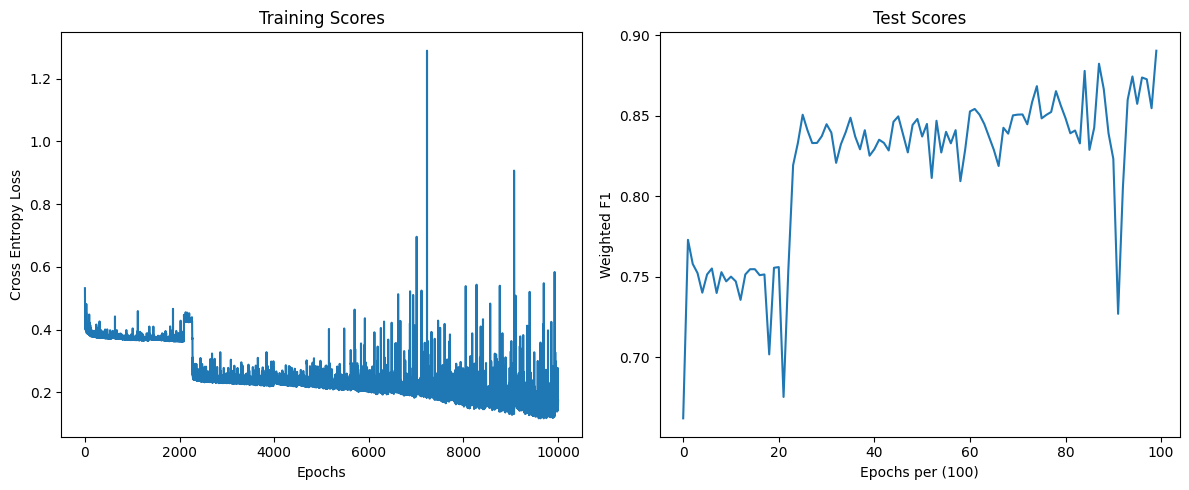

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.33230116, Test F1: 0.8392
Epoch 100, Training F1: 0.25311112, Test F1: 0.8463
Epoch 200, Training F1: 0.25740750, Test F1: 0.8386
Epoch 300, Training F1: 0.25828830, Test F1: 0.8496
Epoch 400, Training F1: 0.24661296, Test F1: 0.8480
Epoch 500, Training F1: 0.25834564, Test F1: 0.8499
Epoch 600, Training F1: 0.23884830, Test F1: 0.8483
Epoch 700, Training F1: 0.26643786, Test F1: 0.8426
Epoch 800, Training F1: 0.23661471, Test F1: 0.8522
Epoch 900, Training F1: 0.23439572, Test F1: 0.8484
Epoch 1000, Training F1: 0.23532436, Test F1: 0.8424
Epoch 1100, Training F1: 0.23622819, Test F1: 0.8442
Epoch 1200, Training F1: 0.23200111, Test F1: 0.8484
Epoch 1300, Training F1: 0.23597426, Test F1: 0.8459
Epoch 1400, Training F1: 0.24310059, Test F1: 0.8453
Epoch 1500, Training F1: 0.23424340, Test F1: 0.8458
Epoc

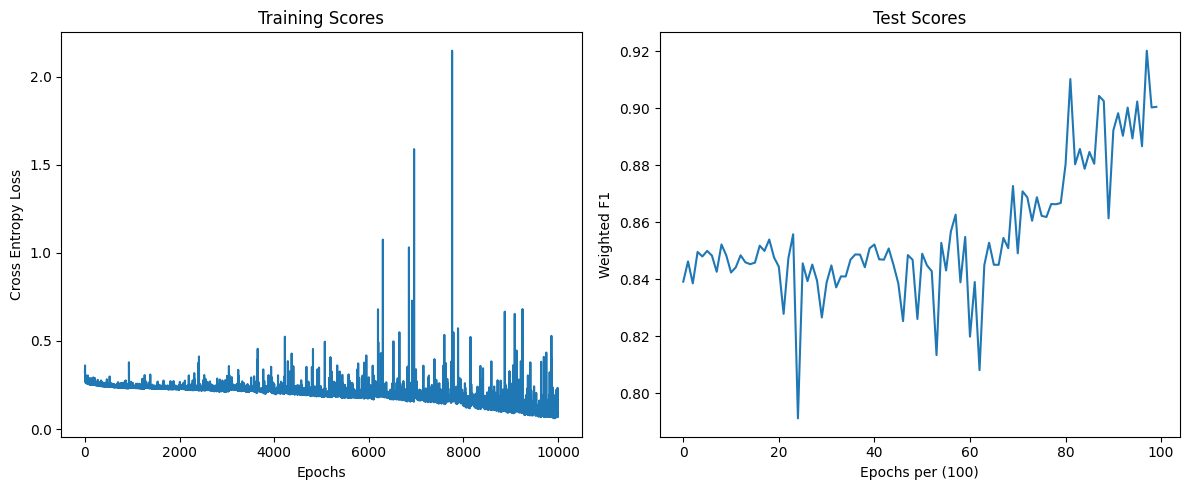

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 0.57499329, Test F1: 0.7155
Epoch 100, Training F1: 0.36655555, Test F1: 0.8060
Epoch 200, Training F1: 0.36782432, Test F1: 0.8026
Epoch 300, Training F1: 0.36432236, Test F1: 0.8042
Epoch 400, Training F1: 0.36578010, Test F1: 0.8003
Epoch 500, Training F1: 0.35780466, Test F1: 0.8045
Epoch 600, Training F1: 0.35925755, Test F1: 0.8095
Epoch 700, Training F1: 0.35970310, Test F1: 0.8054
Epoch 800, Training F1: 0.35756387, Test F1: 0.8042
Epoch 900, Training F1: 0.31301002, Test F1: 0.7969
Epoch 1000, Training F1: 0.24249801, Test F1: 0.8370
Epoch 1100, Training F1: 0.23767274, Test F1: 0.8369
Epoch 1200, Training F1: 0.24024611, Test F1: 0.8381
Epoch 1300, Training F1: 0.23643485, Test F1: 0.8462
Epoch 1400, Training F1: 0.23510462, Test F1: 0.8264
Epoch 1500, Training F1: 0.24408204, Test F1: 0.8322
Epoc

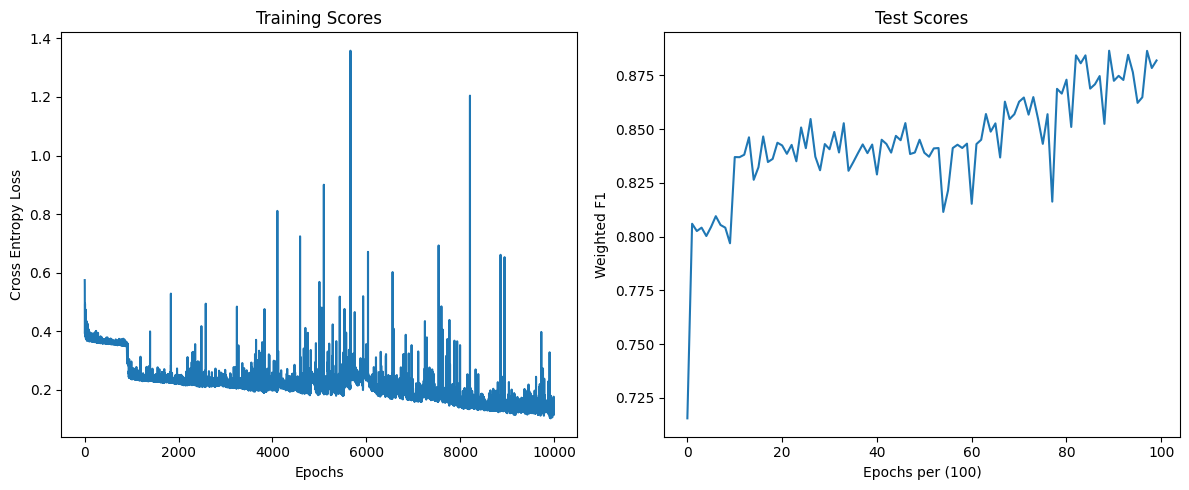

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
softmax function chosen for last layer.
Epoch 0, Training F1: 2.98186197, Test F1: 0.5963
Epoch 100, Training F1: 0.41138453, Test F1: 0.7652
Epoch 200, Training F1: 0.40966002, Test F1: 0.7671
Epoch 300, Training F1: 0.40628504, Test F1: 0.7700
Epoch 400, Training F1: 0.40197903, Test F1: 0.7518
Epoch 500, Training F1: 0.37213657, Test F1: 0.7286
Epoch 600, Training F1: 0.34576475, Test F1: 0.7325
Epoch 700, Training F1: 0.34741462, Test F1: 0.7278
Epoch 800, Training F1: 0.34156155, Test F1: 0.7402
Epoch 900, Training F1: 0.34556194, Test F1: 0.7328
Epoch 1000, Training F1: 0.33931343, Test F1: 0.7255
Epoch 1100, Training F1: 0.34072697, Test F1: 0.7303
Epoch 1200, Training F1: 0.34992962, Test F1: 0.7472
Epoch 1300, Training F1: 0.34097140, Test F1: 0.7546
Epoch 1400, Training F1: 0.33917533, Test F1: 0.7568
Epoch 1500, Training F1: 0.32781362, Test F1: 0.7337
Epoc

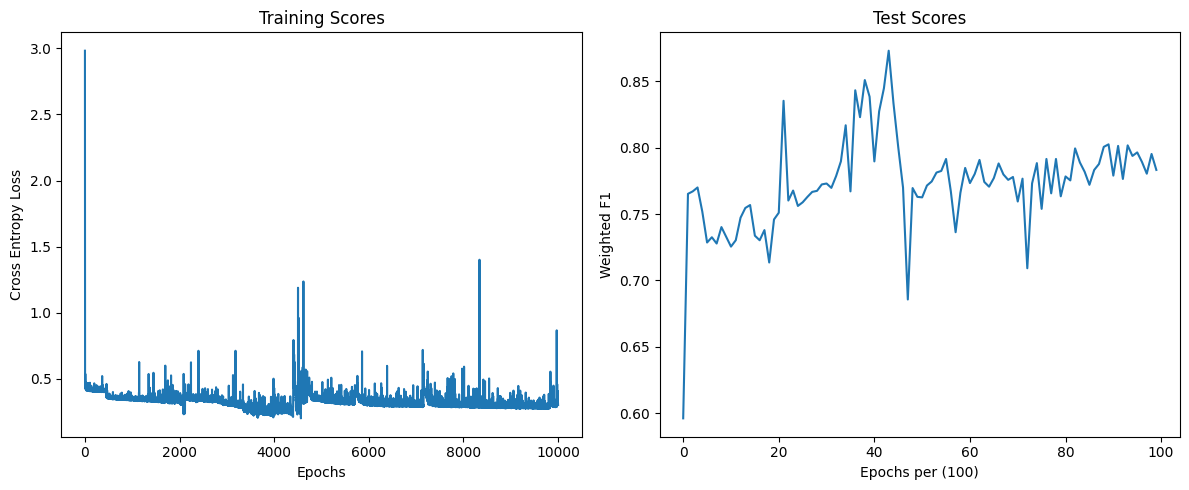

In [37]:
nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='softmax', weights_initialize='He')
soft1_train, soft1_test, soft1_final, soft1_time, soft1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='softmax', weights_initialize='He')
soft2_train, soft2_test, soft2_final, soft2_time, soft2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='softmax', weights_initialize='He')
soft3_train, soft3_test, soft3_final, soft3_time, soft3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)


nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='softmax', weights_initialize='He')
soft4_train, soft4_test, soft4_final, soft4_time, soft4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)


## Sigmoid

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.47518020, Test F1: 0.7327


C:\Users\rogal\AppData\Local\Temp\ipykernel_876\23662379.py:87: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100, Training F1: 0.36692400, Test F1: 0.7677
Epoch 200, Training F1: 0.38227744, Test F1: 0.7440
Epoch 300, Training F1: 0.37631903, Test F1: 0.7716
Epoch 400, Training F1: 0.30325828, Test F1: 0.8411
Epoch 500, Training F1: 0.28218767, Test F1: 0.8372
Epoch 600, Training F1: 0.32451455, Test F1: 0.8289
Epoch 700, Training F1: 0.27901701, Test F1: 0.8194
Epoch 800, Training F1: 0.27841956, Test F1: 0.8174
Epoch 900, Training F1: 0.27882018, Test F1: 0.8213
Epoch 1000, Training F1: 0.27009790, Test F1: 0.8253
Epoch 1100, Training F1: 0.27755144, Test F1: 0.8155
Epoch 1200, Training F1: 0.27196736, Test F1: 0.8211
Epoch 1300, Training F1: 0.27479372, Test F1: 0.8213
Epoch 1400, Training F1: 0.27260968, Test F1: 0.8272
Epoch 1500, Training F1: 0.26778937, Test F1: 0.8252
Epoch 1600, Training F1: 0.27977779, Test F1: 0.8351
Epoch 1700, Training F1: 0.27862351, Test F1: 0.8333
Epoch 1800, Training F1: 0.26489096, Test F1: 0.8253
Epoch 1900, Training F1: 0.26017338, Test F1: 0.8292
Ep

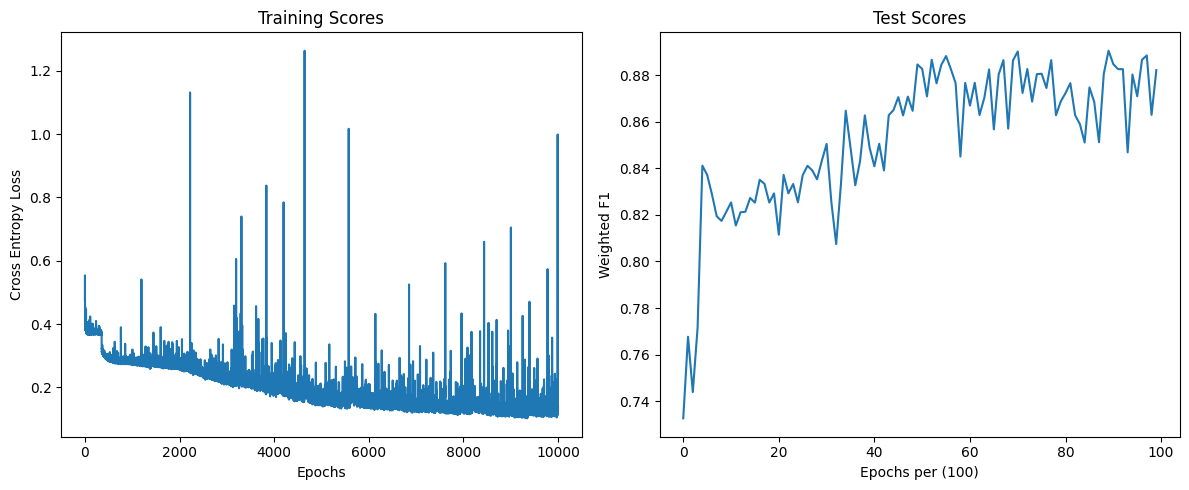

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.39060259, Test F1: 0.8095


C:\Users\rogal\AppData\Local\Temp\ipykernel_876\23662379.py:87: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100, Training F1: 0.25101140, Test F1: 0.8419
Epoch 200, Training F1: 0.25418123, Test F1: 0.8402
Epoch 300, Training F1: 0.24565574, Test F1: 0.8464
Epoch 400, Training F1: 0.24345465, Test F1: 0.8520
Epoch 500, Training F1: 0.24729363, Test F1: 0.8406
Epoch 600, Training F1: 0.24172993, Test F1: 0.8327
Epoch 700, Training F1: 0.24332562, Test F1: 0.8405
Epoch 800, Training F1: 0.24525912, Test F1: 0.8440
Epoch 900, Training F1: 0.23757318, Test F1: 0.8479
Epoch 1000, Training F1: 0.23710229, Test F1: 0.8485
Epoch 1100, Training F1: 0.23531977, Test F1: 0.8438
Epoch 1200, Training F1: 0.23079590, Test F1: 0.8347
Epoch 1300, Training F1: 0.23337020, Test F1: 0.8346
Epoch 1400, Training F1: 0.23003953, Test F1: 0.8502
Epoch 1500, Training F1: 0.26354655, Test F1: 0.8427
Epoch 1600, Training F1: 0.22628336, Test F1: 0.8464
Epoch 1700, Training F1: 0.22711314, Test F1: 0.8503
Epoch 1800, Training F1: 0.21927839, Test F1: 0.8502
Epoch 1900, Training F1: 0.22180723, Test F1: 0.8423
Ep

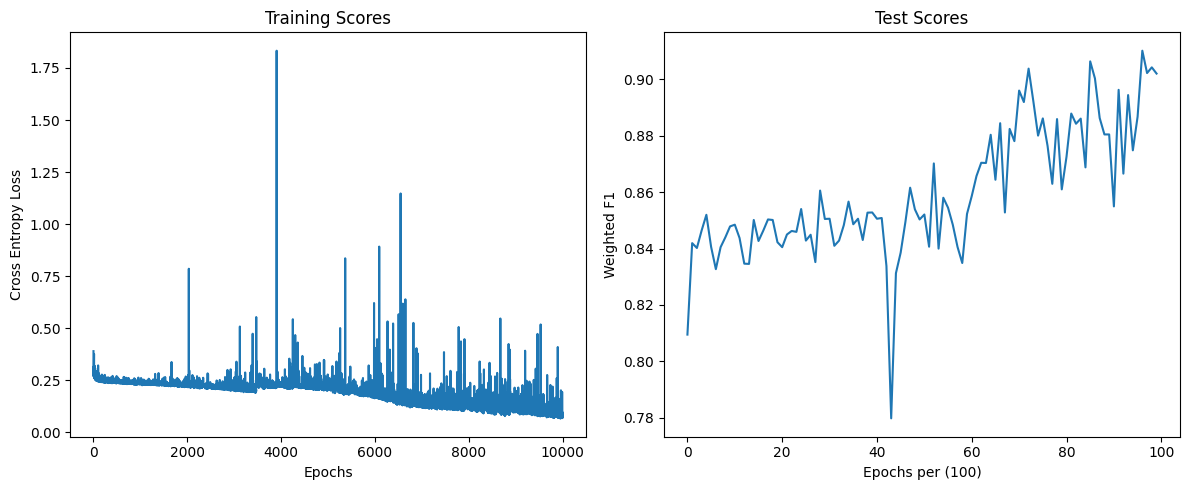

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.92464034, Test F1: 0.6548


C:\Users\rogal\AppData\Local\Temp\ipykernel_876\23662379.py:87: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100, Training F1: 0.25369770, Test F1: 0.8528
Epoch 200, Training F1: 0.25333184, Test F1: 0.8484
Epoch 300, Training F1: 0.24717238, Test F1: 0.8507
Epoch 400, Training F1: 0.24381565, Test F1: 0.8546
Epoch 500, Training F1: 0.24133277, Test F1: 0.8408
Epoch 600, Training F1: 0.24238040, Test F1: 0.8388
Epoch 700, Training F1: 0.28677964, Test F1: 0.8392
Epoch 800, Training F1: 0.24422290, Test F1: 0.8422
Epoch 900, Training F1: 0.23133840, Test F1: 0.8484
Epoch 1000, Training F1: 0.23128411, Test F1: 0.8438
Epoch 1100, Training F1: 0.22934392, Test F1: 0.8423
Epoch 1200, Training F1: 0.23561578, Test F1: 0.8423
Epoch 1300, Training F1: 0.22526685, Test F1: 0.8422
Epoch 1400, Training F1: 0.23603345, Test F1: 0.8344
Epoch 1500, Training F1: 0.23381447, Test F1: 0.8384
Epoch 1600, Training F1: 0.22800274, Test F1: 0.8347
Epoch 1700, Training F1: 0.22750444, Test F1: 0.8458
Epoch 1800, Training F1: 0.23689696, Test F1: 0.8424
Epoch 1900, Training F1: 0.22032788, Test F1: 0.8332
Ep

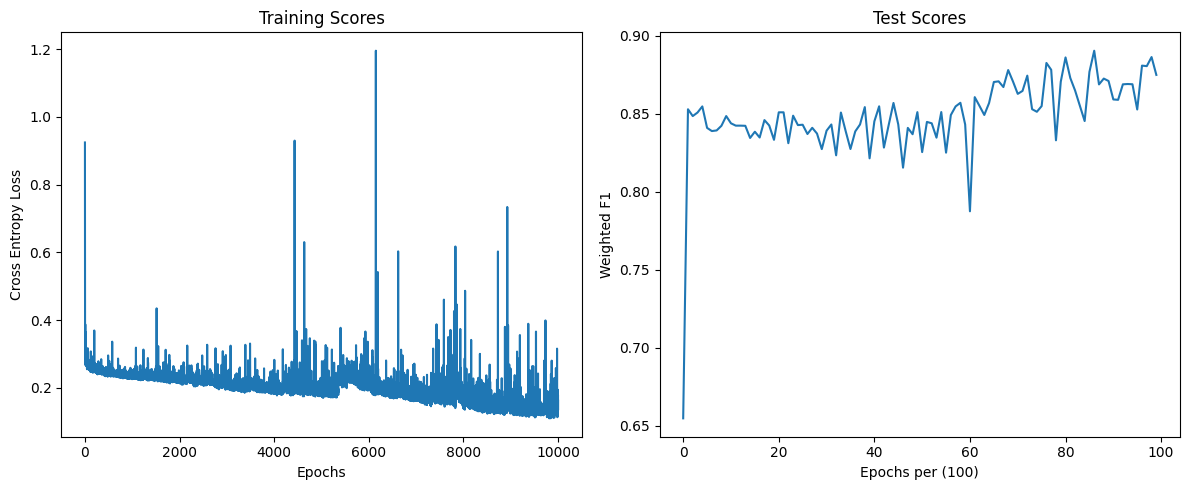

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
sigmoid function chosen for last layer.
Epoch 0, Training F1: 0.76980401, Test F1: 0.7061


C:\Users\rogal\AppData\Local\Temp\ipykernel_876\23662379.py:87: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 100, Training F1: 0.43148473, Test F1: 0.6852
Epoch 200, Training F1: 0.32147756, Test F1: 0.8326
Epoch 300, Training F1: 0.29342204, Test F1: 0.8254
Epoch 400, Training F1: 0.26761301, Test F1: 0.8526
Epoch 500, Training F1: 0.27291507, Test F1: 0.8443
Epoch 600, Training F1: 0.24688929, Test F1: 0.8566
Epoch 700, Training F1: 0.25984537, Test F1: 0.8583
Epoch 800, Training F1: 0.26188759, Test F1: 0.8405
Epoch 900, Training F1: 0.25362705, Test F1: 0.8445
Epoch 1000, Training F1: 0.24684139, Test F1: 0.8250
Epoch 1100, Training F1: 0.26274490, Test F1: 0.8602
Epoch 1200, Training F1: 0.25401964, Test F1: 0.8410
Epoch 1300, Training F1: 0.25013124, Test F1: 0.8466
Epoch 1400, Training F1: 0.25154574, Test F1: 0.8427
Epoch 1500, Training F1: 0.27809487, Test F1: 0.8481
Epoch 1600, Training F1: 0.24232417, Test F1: 0.8526
Epoch 1700, Training F1: 0.24113274, Test F1: 0.8565
Epoch 1800, Training F1: 0.23183497, Test F1: 0.8445
Epoch 1900, Training F1: 0.24103998, Test F1: 0.8526
Ep

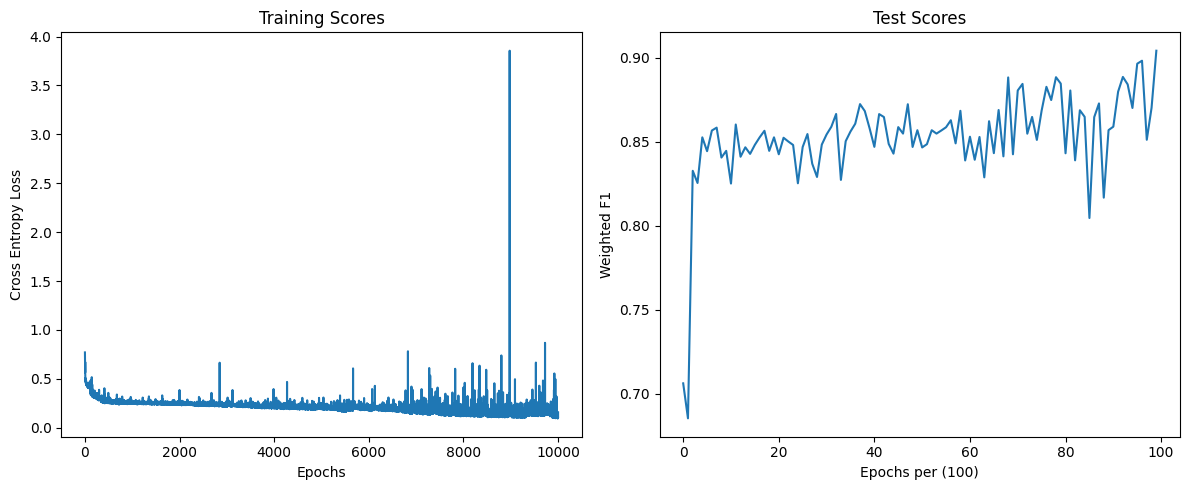

In [38]:
nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='sigmoid', weights_initialize='He')
sigm1_train, sigm1_test, sigm1_final, sigm1_time, sigm1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='sigmoid', weights_initialize='He')
sigm2_train, sigm2_test, sigm2_final, sigm2_time, sigm2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='sigmoid', weights_initialize='He')
sigm3_train, sigm3_test, sigm3_final, sigm3_time, sigm3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="relu", last_layer_activation='sigmoid', weights_initialize='He')
sigm4_train, sigm4_test, sigm4_final, sigm4_time, sigm4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)




## Relu 

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 19.51294756, Test F1: 0.6181
Epoch 100, Training F1: 0.28766153, Test F1: 0.8210
Epoch 200, Training F1: 0.47492349, Test F1: 0.8269
Epoch 300, Training F1: 0.26102108, Test F1: 0.8384
Epoch 400, Training F1: 0.45691571, Test F1: 0.8247
Epoch 500, Training F1: 0.45697732, Test F1: 0.8265
Epoch 600, Training F1: 0.31184147, Test F1: 0.8347
Epoch 700, Training F1: 0.31005569, Test F1: 0.8327
Epoch 800, Training F1: 0.38603406, Test F1: 0.8324
Epoch 900, Training F1: 0.22241504, Test F1: 0.8407
Epoch 1000, Training F1: 0.22660336, Test F1: 0.8290
Epoch 1100, Training F1: 0.27721374, Test F1: 0.8191
Epoch 1200, Training F1: 0.21475741, Test F1: 0.8503
Epoch 1300, Training F1: 0.21901173, Test F1: 0.8428
Epoch 1400, Training F1: 0.21193318, Test F1: 0.8230
Epoch 1500, Training F1: 0.20215181, Test F1: 0.8484
Epoch 

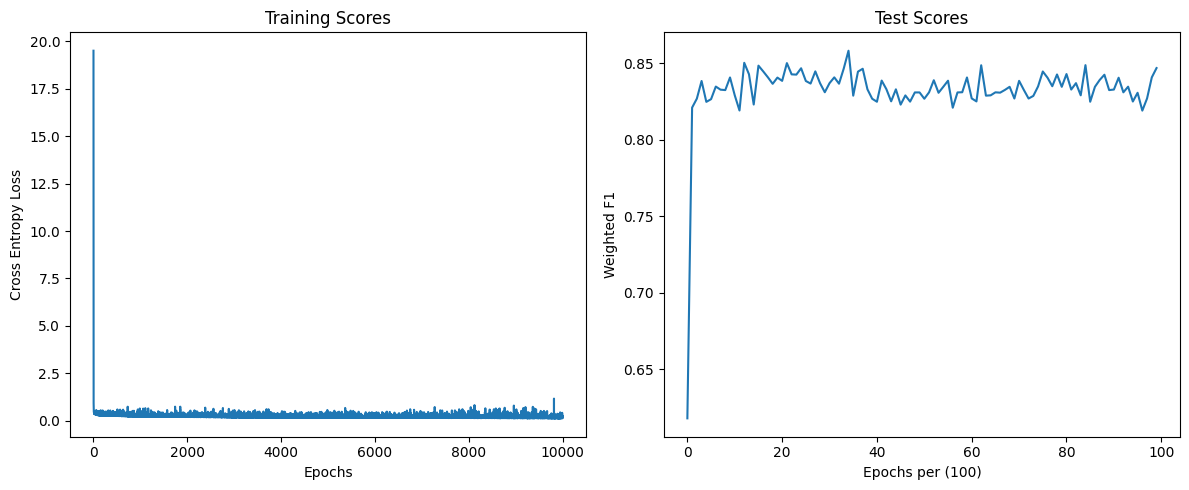

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 4.65479837, Test F1: 0.5264
Epoch 100, Training F1: 0.34945163, Test F1: 0.8348
Epoch 200, Training F1: 0.26820562, Test F1: 0.8350
Epoch 300, Training F1: 0.39657625, Test F1: 0.8167
Epoch 400, Training F1: 0.31143580, Test F1: 0.8211
Epoch 500, Training F1: 0.23303962, Test F1: 0.8269
Epoch 600, Training F1: 0.24375329, Test F1: 0.8249
Epoch 700, Training F1: 0.21934498, Test F1: 0.8211
Epoch 800, Training F1: 0.20863135, Test F1: 0.8331
Epoch 900, Training F1: 0.21114311, Test F1: 0.8247
Epoch 1000, Training F1: 0.20367479, Test F1: 0.8347
Epoch 1100, Training F1: 0.19437339, Test F1: 0.8253
Epoch 1200, Training F1: 0.19208099, Test F1: 0.8250
Epoch 1300, Training F1: 0.20198119, Test F1: 0.8187
Epoch 1400, Training F1: 0.20751660, Test F1: 0.8307
Epoch 1500, Training F1: 0.18524870, Test F1: 0.8308
Epoch 1

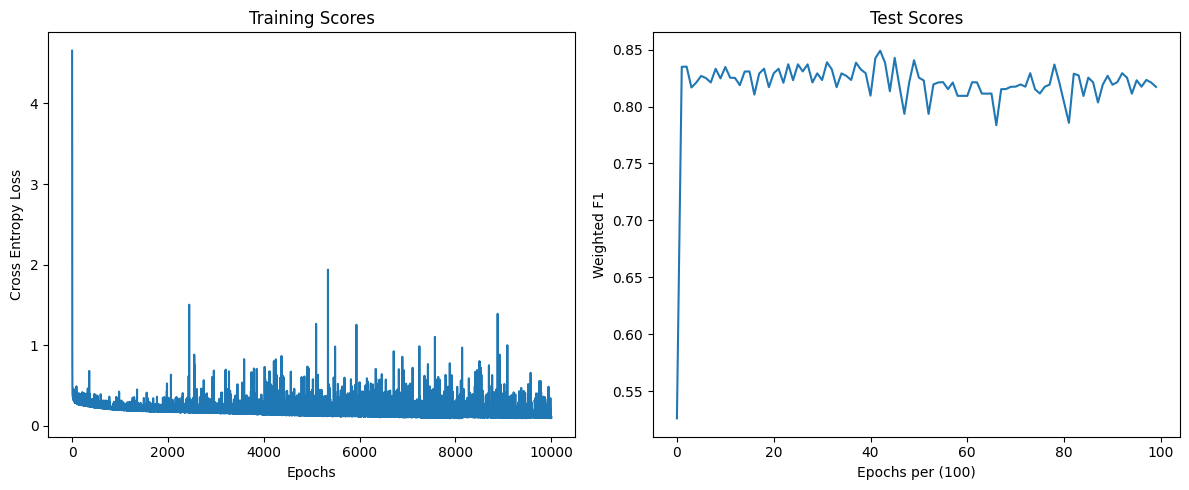

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 14.44589495, Test F1: 0.5007
Epoch 100, Training F1: 0.48104422, Test F1: 0.8170
Epoch 200, Training F1: 0.26040440, Test F1: 0.8193
Epoch 300, Training F1: 0.31046102, Test F1: 0.8231
Epoch 400, Training F1: 0.23914189, Test F1: 0.8291
Epoch 500, Training F1: 0.21877130, Test F1: 0.8329
Epoch 600, Training F1: 0.20863115, Test F1: 0.8351
Epoch 700, Training F1: 0.27853046, Test F1: 0.8351
Epoch 800, Training F1: 0.22216290, Test F1: 0.8407
Epoch 900, Training F1: 0.20232850, Test F1: 0.8309
Epoch 1000, Training F1: 0.27748467, Test F1: 0.8387
Epoch 1100, Training F1: 0.20550403, Test F1: 0.8487
Epoch 1200, Training F1: 0.18222642, Test F1: 0.8408
Epoch 1300, Training F1: 0.19747094, Test F1: 0.8386
Epoch 1400, Training F1: 0.21883150, Test F1: 0.8287
Epoch 1500, Training F1: 0.19691691, Test F1: 0.8348
Epoch 

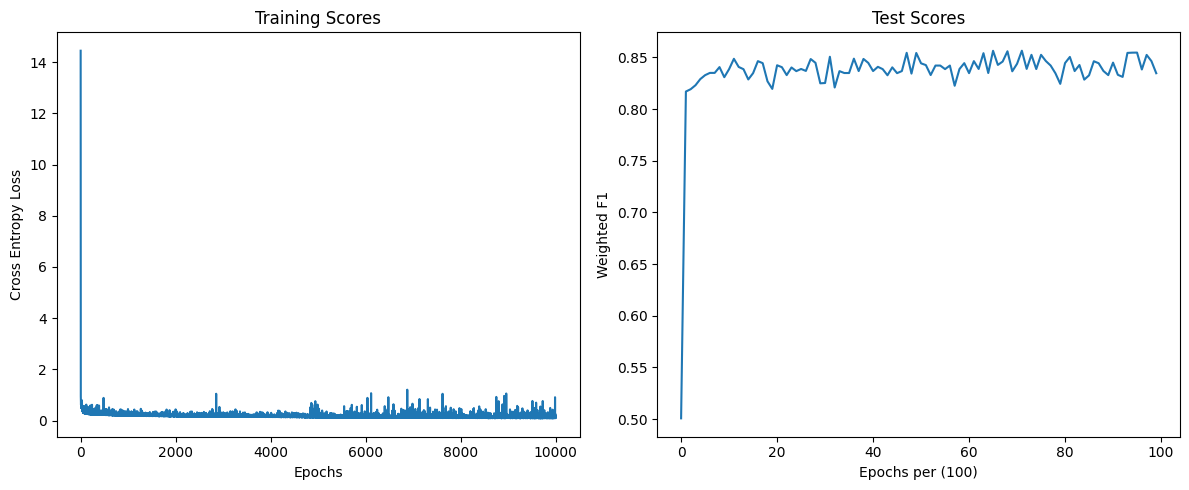

INIT INFO : ------------------------------------------------------------------------------------
No optimisation method
relu function chosen for last layer.
Epoch 0, Training F1: 8.47407736, Test F1: 0.4432
Epoch 100, Training F1: 0.33430065, Test F1: 0.8307
Epoch 200, Training F1: 0.26448964, Test F1: 0.8148
Epoch 300, Training F1: 0.32696141, Test F1: 0.8251
Epoch 400, Training F1: 0.25296189, Test F1: 0.8330
Epoch 500, Training F1: 0.23452013, Test F1: 0.8192
Epoch 600, Training F1: 0.24015086, Test F1: 0.8289
Epoch 700, Training F1: 0.25589862, Test F1: 0.8267
Epoch 800, Training F1: 0.22045694, Test F1: 0.8269
Epoch 900, Training F1: 0.22588309, Test F1: 0.8130
Epoch 1000, Training F1: 0.21141084, Test F1: 0.8151
Epoch 1100, Training F1: 0.20117544, Test F1: 0.8290
Epoch 1200, Training F1: 0.19734369, Test F1: 0.8249
Epoch 1300, Training F1: 0.20084268, Test F1: 0.8191
Epoch 1400, Training F1: 0.19118273, Test F1: 0.8567
Epoch 1500, Training F1: 0.19914259, Test F1: 0.8371
Epoch 1

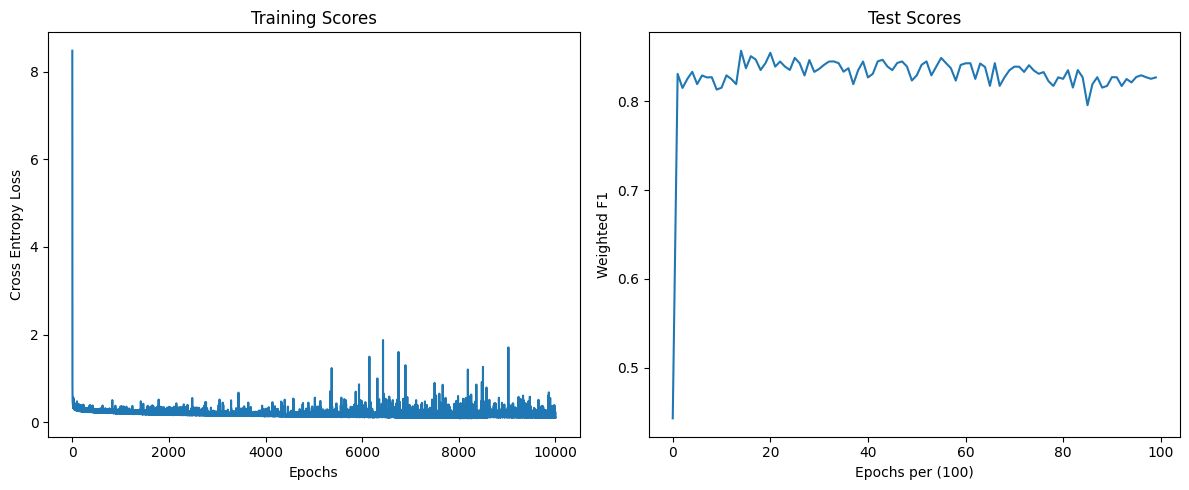

In [39]:
nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="tanh", last_layer_activation='relu', weights_initialize='He')
relu1_train, relu1_test, relu1_final, relu1_time, relu1_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="tanh", last_layer_activation='relu', weights_initialize='He')
relu2_train, relu2_test, relu2_final, relu2_time, relu2_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="tanh", last_layer_activation='relu', weights_initialize='He')
relu3_train, relu3_test, relu3_final, relu3_time, relu3_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)

nn = NeuralNetwork(layers=[2, 64,120,64, 2], activation="tanh", last_layer_activation='relu', weights_initialize='He')
relu4_train, relu4_test, relu4_final, relu4_time, relu4_epoch = nn.train(X_train, Y_train_encoded, X_test, Y_test_encoded,loss_func='F1',  learning_rate=0.01, epochs=10000, loss_threshold=1.7)




## Comparison 2

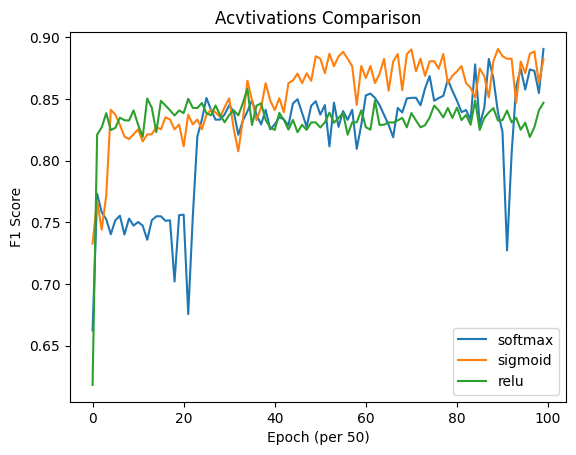

In [40]:
plt.plot(soft1_test, label='softmax')
plt.plot(sigm1_test, label='sigmoid')
plt.plot(relu1_test, label='relu')
plt.title('Acvtivations Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Epoch (per 50)')
plt.legend()

Text(0.5, 1.0, 'Final F1 for each attempt')

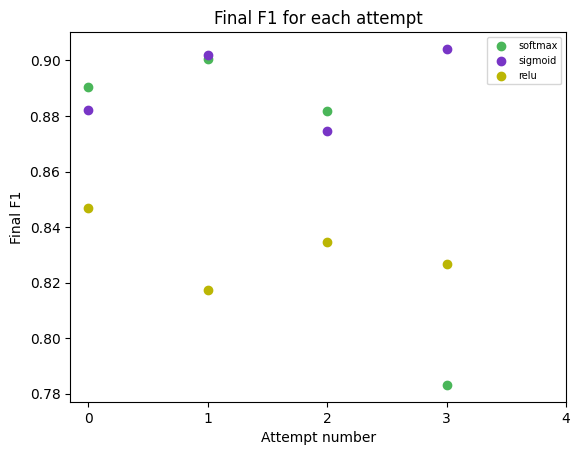

In [41]:
soft_final = [soft1_final, soft2_final, soft3_final, soft4_final]
sigm_final = [ sigm1_final, sigm2_final, sigm3_final, sigm4_final]
relu_final = [relu1_final, relu2_final, relu3_final, relu4_final]

plt.scatter(np.arange(len(soft_final)),soft_final, color='#4ab659', label='softmax')
plt.scatter(np.arange(len(sigm_final)),sigm_final, color='#7835c6', label='sigmoid')
plt.scatter(np.arange(len(relu_final)),relu_final, color='#bbb604', label='relu')
plt.xticks([0,1,2,3,4])
plt.xlabel('Attempt number')
plt.ylabel('Final F1')
plt.legend(loc='upper right', fontsize = 7)
plt.title('Final F1 for each attempt')